# chips-net analysis

This notebook contains the full analysis of chipsnet showing the full path taken to the final version...

## Finding the best models
- [Exploring the data](#explore)
- [Which training sample is best?](#sample)
- [Which image representation is best?](#repr)
- [Which network architecture works best?](#arch)
- [Which channel configuration is best?](#channel)
- [Which categorisation is best?](#cat)
- [Does escapes help cosmic classifier?](#cosmic)
- [Does primary count help beam classifier?](#beam)
- [Does lepton energy and vertex position help neutrino energy estimation?](#energy_multi)
- [Final performance and comparison with old reco/pid](#final)

## Explainability and resilience
- [Model calibration sensitivity: time](#calib_time)
- [Model calibration sensitivity: charge](#calib_charge)
- [Model calibration sensitivity: noise](#calib_noise)
- [Clustering: cosmic classification](#cosmic_cluster)
- [Clustering: beam classification](#beam_cluster)
- [Explanation: cosmic/beam/energy](#explain)

In [1]:
# Default input parameters for this notebook, they are overridden by 'papermill' at runtime if specified
config_path = "./config/results.yaml"
save_path = "./outputs/"
nuel_map_file = "/unix/chips/jtingey/prod/nuel_all_numuflux/map/chips_1200/selected_000_sim_map.root"
numu_map_file = "/unix/chips/jtingey/prod/numu_all_numuflux/map/chips_1200/selected_000_sim_map.root"
cosmic_map_file = "/unix/chips/jtingey/prod/cosmics/map/chips_1200/selected_000_sim_map.root"
old_nuel_file = "./inputs/old_reco/old_reco_el.root"
old_numu_file = "./inputs/old_reco/old_reco_mu.root"
vac_osc_file_zero_f = "./inputs/oscillations/vac_osc_cp_zero.root"
vac_osc_file_plus_f = "./inputs/oscillations/vac_osc_cp_plushalfpi.root"
vac_osc_file_minus_f = "./inputs/oscillations/vac_osc_cp_minushalfpi.root"
matter_osc_file_zero_f = "./inputs/oscillations/matter_osc_cp_zero.root"
matter_osc_file_plus_f = "./inputs/oscillations/matter_osc_cp_plushalfpi.root"
matter_osc_file_minus_f = "./inputs/oscillations/matter_osc_cp_minushalfpi.root"
total_flux_events = 1822592
total_uniform_events = 3086208
total_cosmic_events = 1327744

In [2]:
# Standard inports
import os
import logging
import importlib
import copy
import math
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scipy.optimize import curve_fit
import seaborn as sns
import mplhep as hep
import uproot

# Setup Tensorflow with correct logging and GPU's for inference
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.disable(logging.CRITICAL)
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if tf.config.list_physical_devices('GPU'):
    try:  # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:  # Memory growth must be set before GPUs have been initialized
        print(e)

import chipsnet.config
import chipsnet.data
import chipsnet.models
import chipsnet.utils
import chipsnet.plotting

# Setup matplotlib style using mplhep
extra_styling = {
    "text.usetex": True,
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "axes.xmargin": 0
}

style = hep.style.ROOT
del style['xaxis.labellocation']
del style['yaxis.labellocation']
plt.style.use([style, extra_styling])

In [3]:
# Reload method to import chipsnet modules on the fly if changes are made to them
config = chipsnet.config.get(config_path)
def reload():
    importlib.reload(chipsnet.config)
    importlib.reload(chipsnet.data)
    importlib.reload(chipsnet.models)
    importlib.reload(chipsnet.utils)
    importlib.reload(chipsnet.plotting)
    config = chipsnet.config.get(config_path)

# Finding the best models

<a id='explore'></a>

## Exploring the data (explore)

In [4]:
s_both_ev, s_both_out = chipsnet.utils.evaluate(config, "sample_both_cosmic")
s_flux_ev, s_flux_out = chipsnet.utils.evaluate(config, "sample_flux_cosmic")
s_uniform_ev, s_uniform_out = chipsnet.utils.evaluate(config, "sample_uniform_cosmic")
flux_ev, flux_out = chipsnet.utils.evaluate(config, "flux_cosmic")


************************ Evaluating sample_both_cosmic ************************
Weights: (0,0.00000), (0,0.00000), (384899,0.00871), (0,0.00000), (259648,8.10215)
Cuts:    (281796,0.95429), (274862,0.92423), (123442,0.71910), (53411,0.20571)
took 392.91 seconds

************************ Evaluating sample_flux_cosmic ************************
Weights: (0,0.00000), (0,0.00000), (198914,0.01686), (0,0.00000), (353008,5.95938)
Cuts:    (165397,0.94681), (157159,0.91504), (35579,0.66250), (72590,0.20563)
took 149.34 seconds

************************ Evaluating sample_uniform_cosmic ************************
Weights: (0,0.00000), (0,0.00000), (286487,0.01170), (0,0.00000), (352903,5.96115)
Cuts:    (191131,0.96049), (182383,0.93058), (133632,0.73773), (72557,0.20560)
took 163.66 seconds

************************ Evaluating flux_cosmic ************************
Weights: (178619,0.00022), (170335,0.00001), (148811,0.02253), (135788,0.00054), (254434,8.26819)
Cuts:    (396410,0.96036), (227860,0.

In [5]:
# Get oscillation arrays...
vac_osc_file_zero = uproot.open(vac_osc_file_zero_f)
vac_osc_file_plus = uproot.open(vac_osc_file_plus_f)
vac_osc_file_minus = uproot.open(vac_osc_file_minus_f)
matter_osc_file_zero = uproot.open(matter_osc_file_zero_f)
matter_osc_file_plus = uproot.open(matter_osc_file_plus_f)
matter_osc_file_minus = uproot.open(matter_osc_file_minus_f)

vac_numu_prop_zero = vac_osc_file_zero["hist_mumu"].values[113]
vac_nuel_prop_zero = vac_osc_file_zero["hist_mue"].values[113]
vac_numu_prop_plus = vac_osc_file_plus["hist_mumu"].values[113]
vac_nuel_prop_plus = vac_osc_file_plus["hist_mue"].values[113]
vac_numu_prop_minus = vac_osc_file_minus["hist_mumu"].values[113]
vac_nuel_prop_minus = vac_osc_file_minus["hist_mue"].values[113]

matter_numu_prop_zero = matter_osc_file_zero["hist_mumu"].values
matter_nuel_prop_zero = matter_osc_file_zero["hist_mue"].values
matter_numu_prop_plus = matter_osc_file_plus["hist_mumu"].values
matter_nuel_prop_plus = matter_osc_file_plus["hist_mue"].values
matter_numu_prop_minus = matter_osc_file_minus["hist_mumu"].values
matter_nuel_prop_minus = matter_osc_file_minus["hist_mue"].values

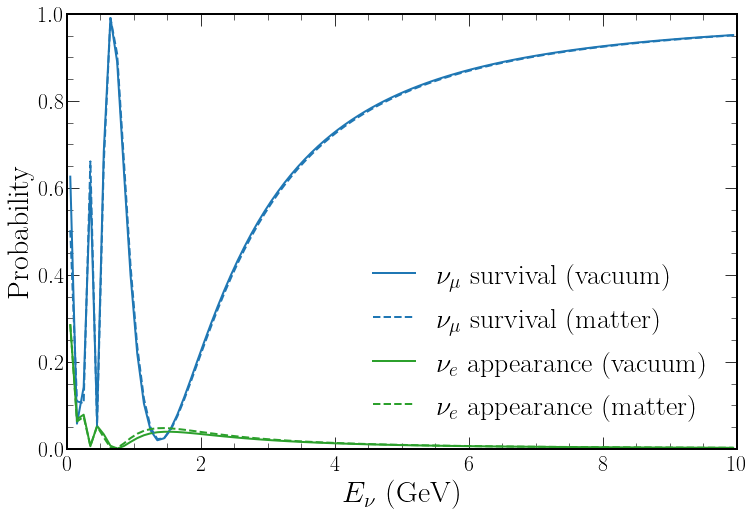

In [6]:
energies = np.arange(0.05, 10.05, 0.1)
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.plot(energies, vac_numu_prop_zero, color="tab:blue", linewidth=2)
axs.plot(energies, vac_nuel_prop_zero, color="tab:green", linewidth=2)
axs.plot(energies, matter_numu_prop_zero, color="tab:blue", linewidth=2, linestyle="dashed")
axs.plot(energies, matter_nuel_prop_zero, color="tab:green", linewidth=2, linestyle="dashed")
axs.set_ylim(0, 1)
axs.set_xlim(0, 10)
axs.set_xlabel(r"$E_{\nu}$ (GeV)", fontsize=30)
axs.set_ylabel(r"Probability", fontsize=30)
vac_numu = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"$\nu_{\mu}$ survival (vacuum)")
vac_nuel = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$\nu_{e}$ appearance (vacuum)")
matter_numu = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="dashed", label=r"$\nu_{\mu}$ survival (matter)")
matter_nuel = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="dashed", label=r"$\nu_{e}$ appearance (matter)")
axs.legend(handles=[vac_numu, matter_numu, vac_nuel, matter_nuel], loc="lower right", fontsize=28)
chipsnet.plotting.save(save_path + "explore_osc_vac_vs_matter_probs")

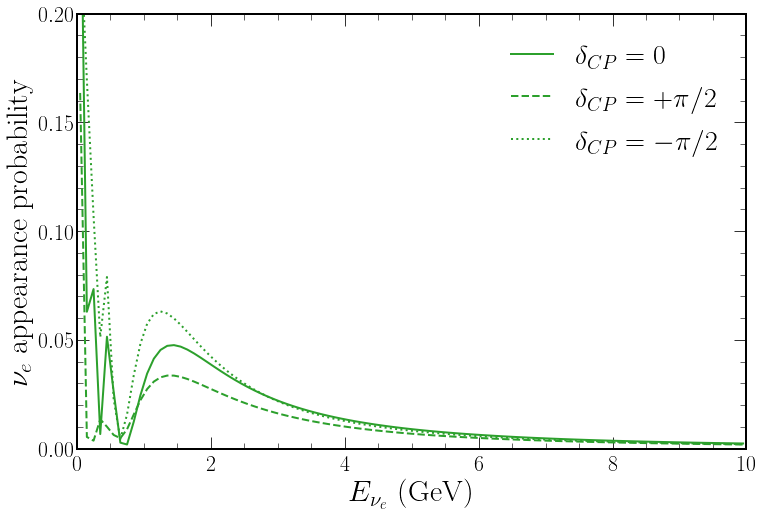

In [7]:
energies = np.arange(0.05, 10.05, 0.1)
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
plt.setp(axs, yticks=[0, 0.05, 0.1, 0.15, 0.2])
axs.plot(energies, matter_nuel_prop_zero, color="tab:green", linewidth=2)
axs.plot(energies, matter_nuel_prop_plus, color="tab:green", linewidth=2, linestyle="dashed")
axs.plot(energies, matter_nuel_prop_minus, color="tab:green", linewidth=2, linestyle="dotted")
axs.set_ylim(0, 0.2)
axs.set_xlim(0, 10)
axs.set_xlabel(r"$E_{\nu_{e}}$ (GeV)", fontsize=30)
axs.set_ylabel(r"$\nu_{e}$ appearance probability", fontsize=30)
zero_cp = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$\delta_{CP}=0$")
plus_cp = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="dashed", label=r"$\delta_{CP}=+\pi/2$")
minus_cp = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="dotted", label=r"$\delta_{CP}=-\pi/2$")
axs.legend(handles=[zero_cp, plus_cp, minus_cp], loc="upper right", fontsize=28)
chipsnet.plotting.save(save_path + "explore_osc_cp_probs")

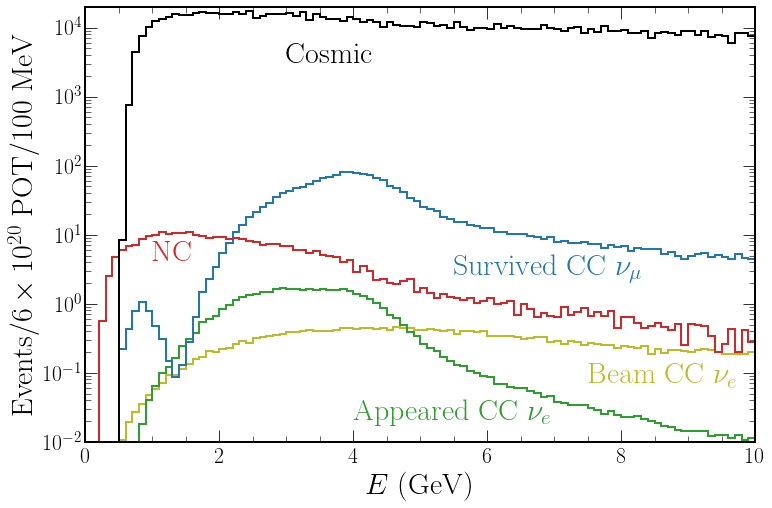

In [8]:
nuel_ev = flux_ev[
    (flux_ev["t_comb_cat"] == 0) & 
    (flux_ev["t_sample_type"] == 0)
]
osc_nuel_ev = flux_ev[
    (flux_ev["t_comb_cat"] == 0) & 
    (flux_ev["t_sample_type"] == 1)
]
numu_ev = flux_ev[
    (flux_ev["t_comb_cat"] == 1) & 
    (flux_ev["t_sample_type"] == 0)
]
nc_ev = flux_ev[
    (flux_ev["t_comb_cat"] == 2) & 
    (flux_ev["t_sample_type"] == 0)
]
cosmic_ev = flux_ev[flux_ev["t_comb_cat"] == 3]

fig, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw={"hspace": 0.3})
axs.hist(nuel_ev["t_nu_energy"]/1000, weights=nuel_ev["w"], range=(0, 10), bins=100, color='tab:olive', histtype='step', linewidth=2)
axs.hist(osc_nuel_ev["t_nu_energy"]/1000, weights=osc_nuel_ev["w"], range=(0, 10), bins=100, color='tab:green', histtype='step', linewidth=2)
axs.hist(numu_ev["t_nu_energy"]/1000, weights=numu_ev["w"], range=(0, 10), bins=100, color='tab:blue', histtype='step', linewidth=2)
axs.hist(nc_ev["t_had_energy"]/1000, weights=nc_ev["w"], range=(0, 10), bins=100, color='tab:red', histtype='step', linewidth=2)
axs.hist(cosmic_ev["t_nu_energy"]/1000, weights=cosmic_ev["w"], range=(0, 10), bins=100, color='black', histtype='step', linewidth=2)
axs.text(5.5, 2.7, r"Survived CC $\nu_{\mu}$", color='tab:blue', fontsize=30)
axs.text(4, 0.02, r"Appeared CC $\nu_{e}$", color='tab:green', fontsize=30)
axs.text(7.5, 0.07, r"Beam CC $\nu_{e}$", color='tab:olive', fontsize=30)
axs.text(1, 4, r"NC", color='tab:red', fontsize=30)
axs.text(3, 3000, r"Cosmic", color='black', fontsize=30)
axs.set_yscale('log')
axs.set_xlabel(r"$E$ (GeV)", fontsize=30)
axs.set_ylabel(r"Events/$6\times10^{20}$ POT/100 MeV", fontsize=30)
axs.set_ylim(10e-3, 20e3)

chipsnet.plotting.save(save_path + "explore_osc_fluxes")

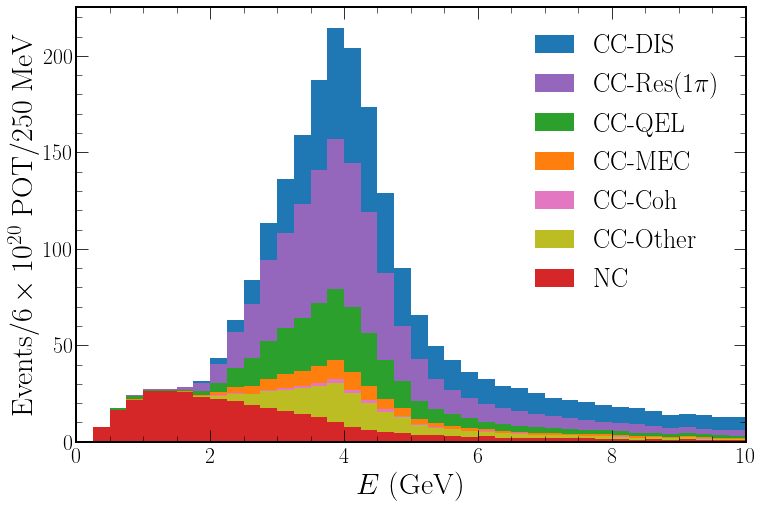

In [9]:
e_range=(0, 10)
e_bins=40
bin_range=(e_range[1]-e_range[0])/e_bins

qel_ev = flux_ev[flux_ev["t_cc_cat"] == 0].reset_index(drop=True)
res_ev = flux_ev[flux_ev["t_cc_cat"] == 1].reset_index(drop=True)
dis_ev = flux_ev[flux_ev["t_cc_cat"] == 2].reset_index(drop=True)
coh_ev = flux_ev[flux_ev["t_cc_cat"] == 3].reset_index(drop=True)
mec_ev = flux_ev[flux_ev["t_cc_cat"] == 4].reset_index(drop=True)
other_ev = flux_ev[flux_ev["t_cc_cat"] == 5].reset_index(drop=True)
nc_ev = nc_ev.reset_index(drop=True)

qel_h, qel_err, c, e = chipsnet.utils.extended_hist(qel_ev["t_nu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=qel_ev["w"])
res_h, res_err, c, e = chipsnet.utils.extended_hist(res_ev["t_nu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=res_ev["w"])
dis_h, dis_err, c, e = chipsnet.utils.extended_hist(dis_ev["t_nu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=dis_ev["w"])
coh_h, coh_err, c, e = chipsnet.utils.extended_hist(coh_ev["t_nu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=coh_ev["w"])
mec_h, mec_err, c, e = chipsnet.utils.extended_hist(mec_ev["t_nu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=mec_ev["w"])
other_h, other_err, c, e = chipsnet.utils.extended_hist(other_ev["t_nu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=other_ev["w"])
nc_h, nc_err, c, e = chipsnet.utils.extended_hist(nc_ev["t_had_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nc_ev["w"])
err = qel_err + res_err + dis_err + coh_err + mec_err + other_err + nc_err

fig, axs = plt.subplots(1, 1, figsize=(12, 8))
bins = np.arange(0+(bin_range/2), 10+(bin_range/2), bin_range)

axs.bar(bins, nc_h, bin_range, color="tab:red")
axs.bar(bins, other_h, bin_range, color="tab:olive", bottom=nc_h)
axs.bar(bins, coh_h, bin_range, color="tab:pink", bottom=nc_h+other_h)
axs.bar(bins, mec_h, bin_range, color="tab:orange", bottom=nc_h+other_h+coh_h)
axs.bar(bins, qel_h, bin_range, color="tab:green", bottom=nc_h+other_h+coh_h+mec_h)
axs.bar(bins, res_h, bin_range, color="tab:purple", bottom=nc_h+other_h+coh_h+mec_h+qel_h)
axs.bar(bins, dis_h, bin_range, color="tab:blue", bottom=nc_h+other_h+coh_h+mec_h+qel_h+res_h)

dis = Patch(facecolor="tab:blue", label=r"CC-DIS")
res = Patch(facecolor="tab:purple", label=r"CC-Res($1\pi$)")
qel = Patch(facecolor="tab:green", label=r"CC-QEL")
mec = Patch(facecolor="tab:orange", label=r"CC-MEC")
coh = Patch(facecolor="tab:pink", label=r"CC-Coh")
other = Patch(facecolor="tab:olive", label=r"CC-Other")
nc = Patch(facecolor="tab:red", label=r"NC")
axs.legend(handles=[dis, res, qel, mec, coh, other, nc], loc="upper right", fontsize=26)
axs.set_xlabel(r"$E$ (GeV)", fontsize=30)
axs.set_ylabel(r"Events/$6\times10^{20}$ POT/250 MeV", fontsize=30)
chipsnet.plotting.save(save_path + "explore_stacked_int_types")

In [10]:
def plot_training_sample(events, total_num, save_name, cosmic=True):
    data = [
        len(events[events["t_all_cat"] == i])
        for i in range(len(chipsnet.data.MAP_ALL_CAT["labels"]))
    ]
    scale = total_num/sum(data)
    data = [x * scale for x in data]
    labels = chipsnet.data.MAP_ALL_CAT["labels"]

    if cosmic is False:
        data = data[:-1]
        labels = labels[:-1]
        
    data = np.asarray(data)
    print("Total training events = {}".format(data.sum()))
    
    cats = np.arange(len(labels))
    width = 1

    fig, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw={"hspace": 0.3})
    barlist = axs.bar(cats, data, color="tab:blue", width=width, label="training sample", edgecolor='black', linewidth=2)
    if cosmic is True:
        barlist[16].set_color("tab:red")
        barlist[16].set_edgecolor("black")
        barlist[16].set_linewidth(2)
    axs.set_xticks(cats)
    axs.set_xticklabels(labels, fontsize=24, rotation="vertical")
    axs.set_ylabel("Number of training events", fontsize=30)
    axs.set_yscale('log')
    axs.set_ylim(10e2, 2e6)
    if cosmic is False:
        axs.set_ylim(10e2, 5e5)
    chipsnet.plotting.save(save_name)

Total training events = 3150336.0


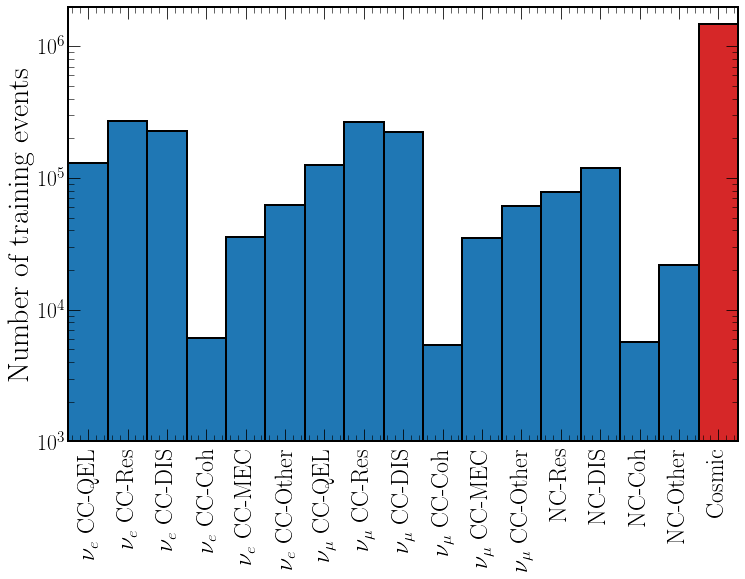

In [11]:
plot_training_sample(s_flux_ev, (total_flux_events+total_cosmic_events), save_path + "explore_cosmic_training_sample", cosmic=True)

Total training events = 1673749.8518014955


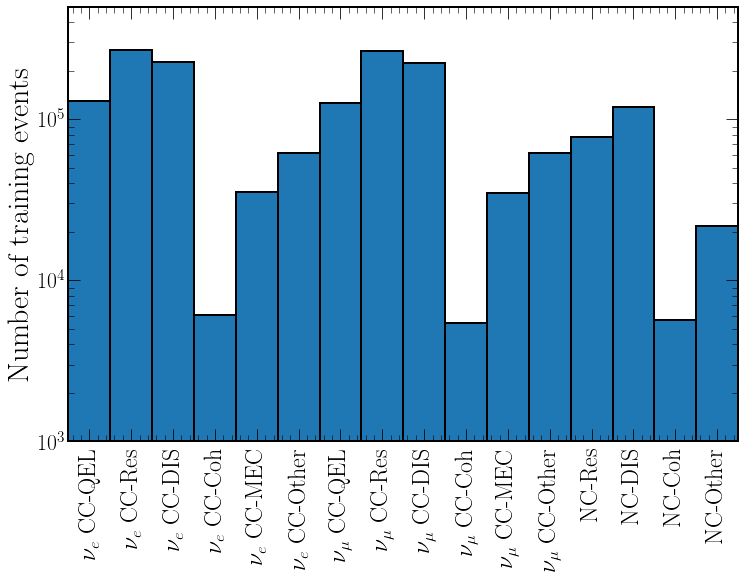

In [12]:
plot_training_sample(s_flux_ev, (total_flux_events+total_cosmic_events), save_path + "explore_beam_training_sample", cosmic=False)

Total training events = 2737249.4577018465


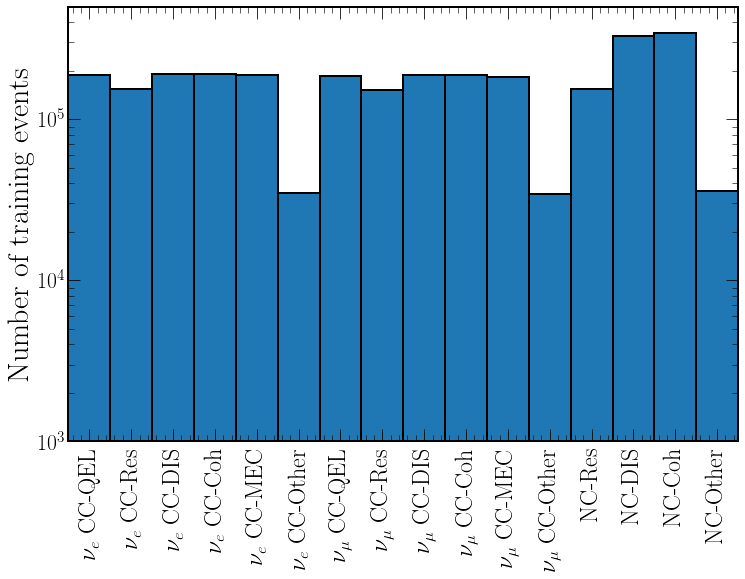

In [13]:
plot_training_sample(s_uniform_ev, (total_uniform_events+total_cosmic_events), save_path + "explore_uniform_training_sample", cosmic=False)

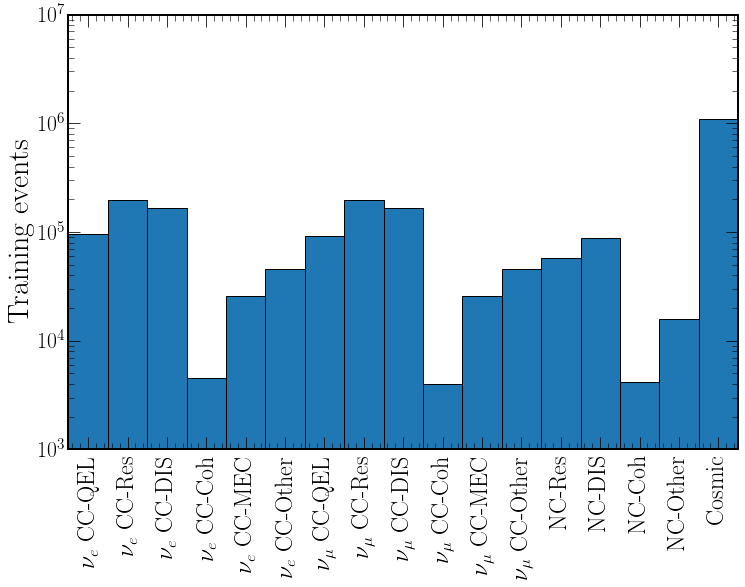

In [14]:
chipsnet.plotting.plot_cats(s_flux_ev, (total_flux_events+total_cosmic_events) / config.eval.examples, chipsnet.data.MAP_ALL_CAT, save_path)

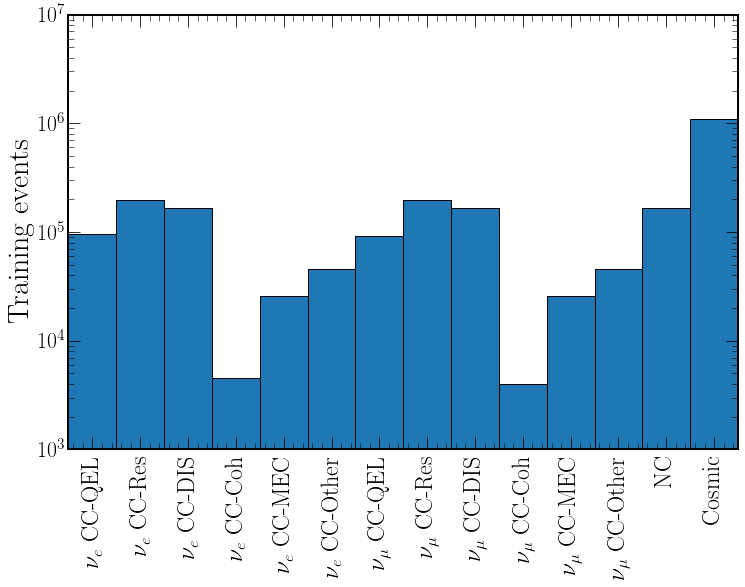

In [15]:
chipsnet.plotting.plot_cats(s_flux_ev, (total_flux_events+total_cosmic_events) / config.eval.examples, chipsnet.data.MAP_NC_COMB_CAT, save_path)

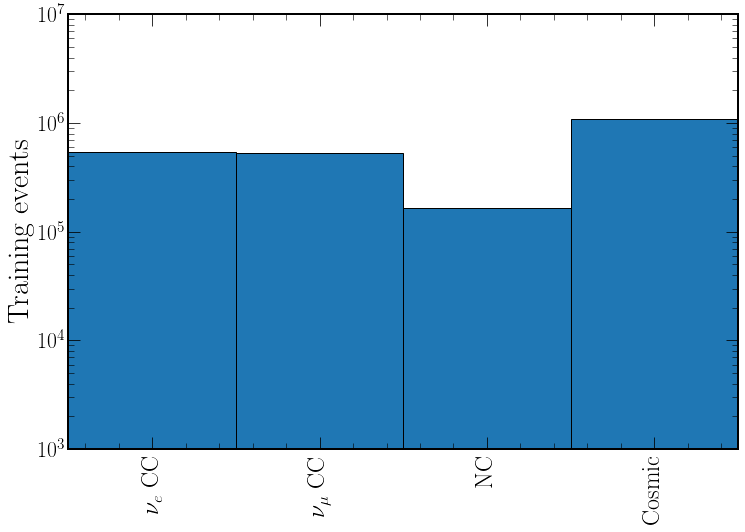

In [16]:
chipsnet.plotting.plot_cats(s_flux_ev, (total_flux_events+total_cosmic_events) / config.eval.examples, chipsnet.data.MAP_FULL_COMB_CAT, save_path)

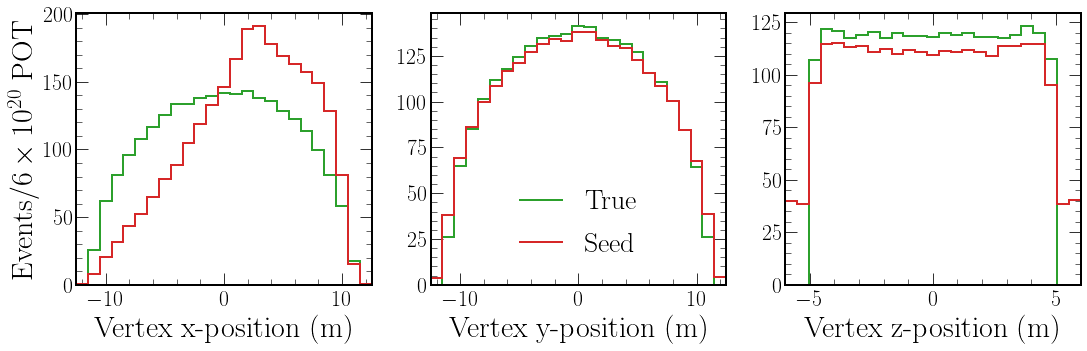

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_x"]/100, 
            range=(-12.5, 12.5), bins=25, color='tab:green', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], linewidth=2)
axs[0].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_x"]*1250/100, 
            range=(-12.5, 12.5), bins=25, color='tab:red', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], linewidth=2)
axs[0].set_xlabel('Vertex x-position (m)', fontsize=30)
axs[0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
single = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"True")
multi = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"Seed")
axs[1].legend(handles=[single, multi], loc="lower center", fontsize=28)

axs[1].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_y"]/100,
            range=(-12.5, 12.5), bins=25, color='tab:green', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], linewidth=2)
axs[1].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_y"]*1250/100, 
            range=(-12.5, 12.5), bins=25, color='tab:red', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], linewidth=2)
axs[1].set_xlabel('Vertex y-position (m)', fontsize=30)

axs[2].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_z"]/100,
            range=(-6, 6), bins=25, color='tab:green', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], linewidth=2)
axs[2].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_z"]*600/100, 
            range=(-6, 6), bins=25, color='tab:red', histtype='step', 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], linewidth=2)
axs[2].set_xlabel('Vertex z-position (m)', fontsize=30)
chipsnet.plotting.save(save_path + "explore_vtx_positions")

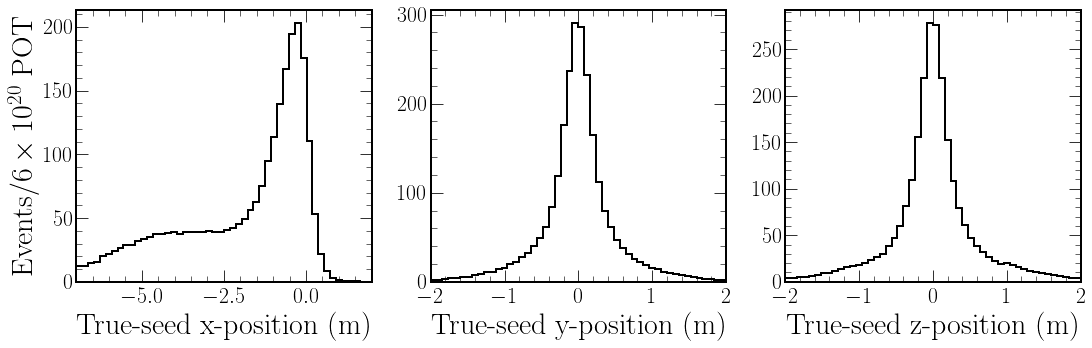

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_x"]/100-(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_x"]*1250/100),
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], range=(-7, 2), bins=50, color='black', histtype='step', linewidth=2)
axs[0].set_xlabel('True-seed x-position (m)', fontsize=30)
axs[0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)

axs[1].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_y"]/100-(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_y"]*1250/100),
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], range=(-2, 2), bins=50, color='black', histtype='step', linewidth=2)
axs[1].set_xlabel('True-seed y-position (m)', fontsize=30)

axs[2].hist(flux_ev[flux_ev["t_cosmic_cat"] == 0]["t_vtx_z"]/100-(flux_ev[flux_ev["t_cosmic_cat"] == 0]["r_vtx_z"]*600/100), 
            weights=flux_ev[flux_ev["t_cosmic_cat"] == 0]["w"], range=(-2, 2), bins=50, color='black', histtype='step', linewidth=2)
axs[2].set_xlabel('True-seed z-position (m)', fontsize=30)
chipsnet.plotting.save(save_path + "explore_true_reco_vtx")

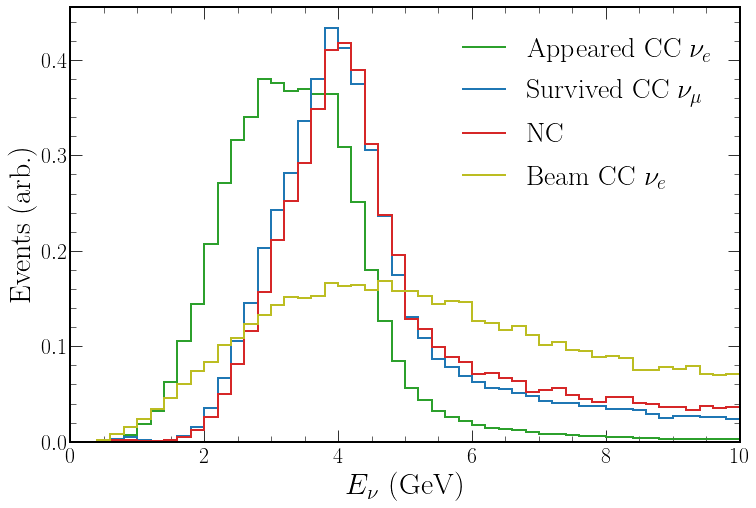

In [19]:
osc_nuel = matplotlib.lines.Line2D([], [], c='tab:green', linewidth=2)
numu = matplotlib.lines.Line2D([], [], c='tab:blue', linewidth=2)
nc = matplotlib.lines.Line2D([], [], c='tab:red', linewidth=2)
nuel = matplotlib.lines.Line2D([], [], c='tab:olive', linewidth=2)

fig, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw={'hspace': 0.3})
axs.hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_sample_type"] == 1)]["t_nu_energy"]/1000, 
         weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_sample_type"] == 1)]["w"],
         range=(0, 10), bins=50, color='tab:green', histtype='step', density=True, linewidth=2)
axs.hist(flux_ev[flux_ev["t_comb_cat"] == 1]["t_nu_energy"]/1000, weights=flux_ev[flux_ev["t_comb_cat"] == 1]["w"],
         range=(0, 10), bins=50, color='tab:blue', histtype='step', density=True, linewidth=2)
axs.hist(flux_ev[flux_ev["t_comb_cat"] == 2]["t_nu_energy"]/1000, weights=flux_ev[flux_ev["t_comb_cat"] == 2]["w"],
         range=(0, 10), bins=50, color='tab:red', histtype='step', density=True, linewidth=2)
axs.hist(flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_sample_type"] == 0)]["t_nu_energy"]/1000, 
         weights=flux_ev[(flux_ev["t_comb_cat"] == 0) & (flux_ev["t_sample_type"] == 0)]["w"],
         range=(0, 10), bins=50, color='tab:olive', histtype='step', density=True, linewidth=2)
axs.legend(loc="upper right", handles=[osc_nuel, numu, nc, nuel], fontsize=28, labels=[r"Appeared CC $\nu_{e}$", r"Survived CC $\nu_{\mu}$", r"NC", r"Beam CC $\nu_{e}$"])
axs.set_xlabel(r'$E_{\nu}$ (GeV)', fontsize=30)
axs.set_ylabel('Events (arb.)', fontsize=30)
#plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
chipsnet.plotting.save(save_path + "explore_nu_energies")

In [20]:
# Setup an images dictionary to hold example images
image_size = [64, 64]
images_dict = {"r_charge_map_origin": [], "r_charge_map_iso": [], "r_charge_map_vtx": [],
               "r_time_map_origin": [], "r_time_map_iso": [], "r_time_map_vtx": [], "r_hough_map_vtx": []}
true_dict = {"t_code": [], "t_nu_energy": [], "t_lep_energy":[], "t_p_pdgs": [], "t_p_energies": [], "t_escapes": []}
               
# Load the images into the dictionary
nuel_file = uproot.open(nuel_map_file)
numu_file = uproot.open(numu_map_file)
cosmic_file = uproot.open(cosmic_map_file)
for image_name in images_dict.keys():
    images_dict[image_name].extend(nuel_file['reco'].array(image_name))
    images_dict[image_name].extend(numu_file['reco'].array(image_name))
    images_dict[image_name].extend(cosmic_file['reco'].array(image_name))
for truth_info in true_dict.keys():
    true_dict[truth_info].extend(nuel_file['true'].array(truth_info))
    true_dict[truth_info].extend(numu_file['true'].array(truth_info))
    true_dict[truth_info].extend(cosmic_file['true'].array(truth_info))    

# Calculate fraction of hits in the endcaps
cap_total = 0
barrel_total = 0
for event in images_dict['r_charge_map_vtx']:
    sections = np.split(event, [18, 46], axis=0)
    cap_total += (sections[0].sum() + sections[2].sum())
    barrel_total += sections[1].sum()

# This is with cosmic events included
print("Fraction of deposited charge in endcaps = {}".format(cap_total/(cap_total+barrel_total)))

Fraction of deposited charge in endcaps = 0.4769380479133997


3
3307.41
2777.48
[  11 2212 2212  111 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999]
[2777.48  1085.32   991.703  318.527 -999.    -999.    -999.    -999.
 -999.    -999.    -999.    -999.    -999.    -999.    -999.    -999.
 -999.    -999.    -999.    -999.   ]
0


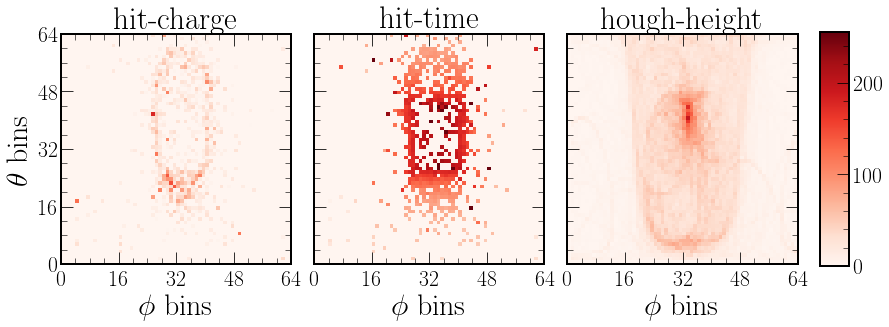

In [21]:
event_num = 1009
print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
print(true_dict["t_escapes"][event_num])
chipsnet.plotting.plot_event(images_dict, event_num, save_path+"explore_nuel_ccres_event")

91
3520.17
1862.55
[2212   13 2112  211  211   22 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999]
[2022.37  1862.55  1038.34   226.973  223.71     6.32  -999.    -999.
 -999.    -999.    -999.    -999.    -999.    -999.    -999.    -999.
 -999.    -999.    -999.    -999.   ]
0


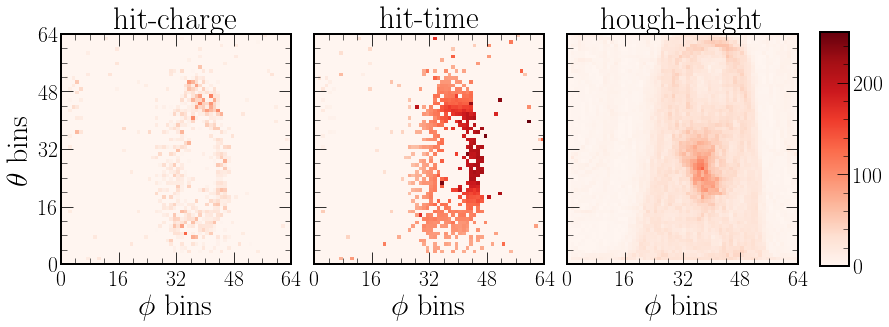

In [22]:
event_num = 2014
print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
print(true_dict["t_escapes"][event_num])
chipsnet.plotting.plot_event(images_dict, event_num, save_path+"explore_numu_ccdis_event")

100
2928.5
2928.5
[  13 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999]
[2928.5 -999.  -999.  -999.  -999.  -999.  -999.  -999.  -999.  -999.
 -999.  -999.  -999.  -999.  -999.  -999.  -999.  -999.  -999.  -999. ]
0


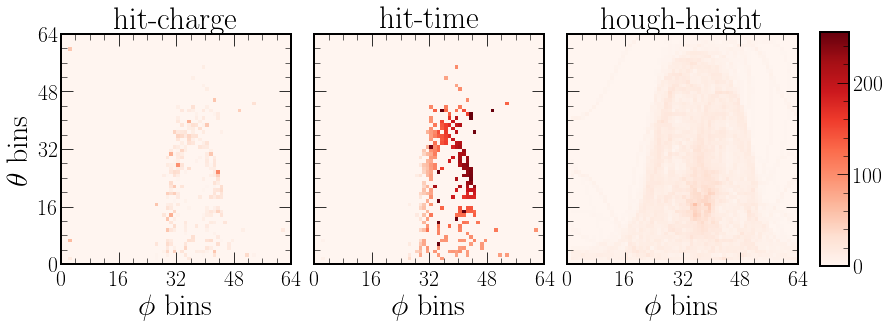

In [23]:
event_num = 4006
print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
print(true_dict["t_escapes"][event_num])
chipsnet.plotting.plot_event(images_dict, event_num, save_path+"explore_cosmic_event")

92
9301.59
-1.0
[  12 2212  211 2212 2212 2112 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999]
[4731.25  2635.15  2511.54  1046.97   998.676  993.868 -999.    -999.
 -999.    -999.    -999.    -999.    -999.    -999.    -999.    -999.
 -999.    -999.    -999.    -999.   ]
-1


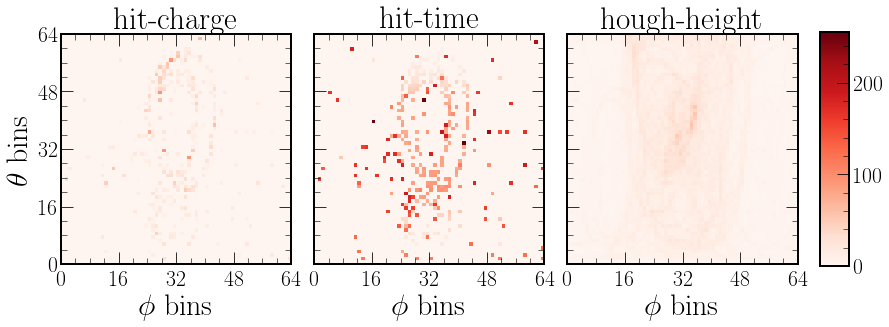

In [24]:
event_num = 1045
print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
print(true_dict["t_escapes"][event_num])
chipsnet.plotting.plot_event(images_dict, event_num, save_path+"explore_nuel_ncdis_event")

3
3307.41
2777.48
[  11 2212 2212  111 -999 -999 -999 -999 -999 -999 -999 -999 -999 -999
 -999 -999 -999 -999 -999 -999]
[2777.48  1085.32   991.703  318.527 -999.    -999.    -999.    -999.
 -999.    -999.    -999.    -999.    -999.    -999.    -999.    -999.
 -999.    -999.    -999.    -999.   ]
0


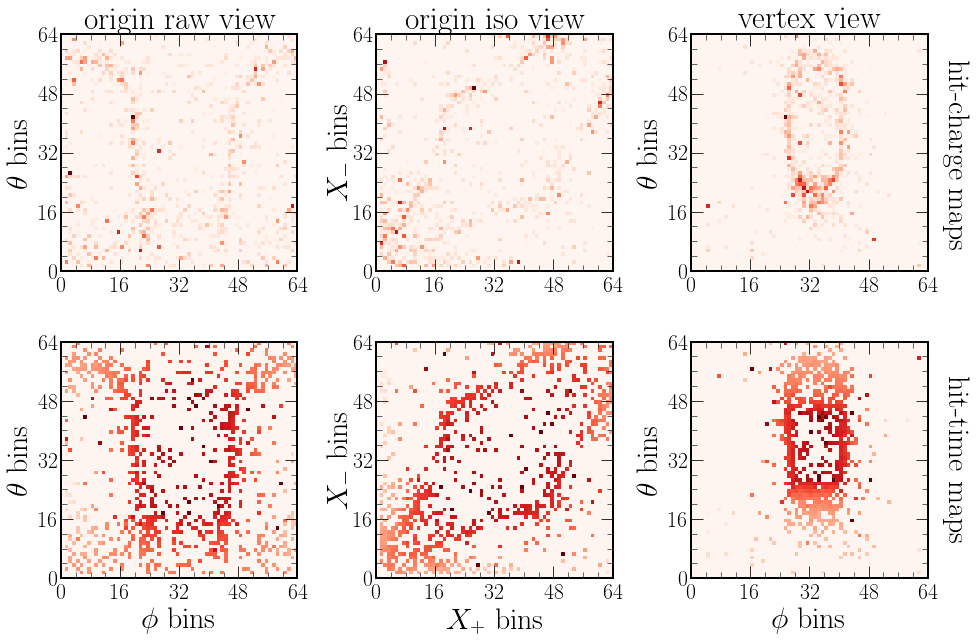

In [25]:
event_num = 1009
print(true_dict["t_code"][event_num])
print(true_dict["t_nu_energy"][event_num])
print(true_dict["t_lep_energy"][event_num])
print(true_dict["t_p_pdgs"][event_num])
print(true_dict["t_p_energies"][event_num])
print(true_dict["t_escapes"][event_num])
chipsnet.plotting.plot_hit_time(images_dict, event_num, save_path+"explore_repr_nuel_ccres_event")

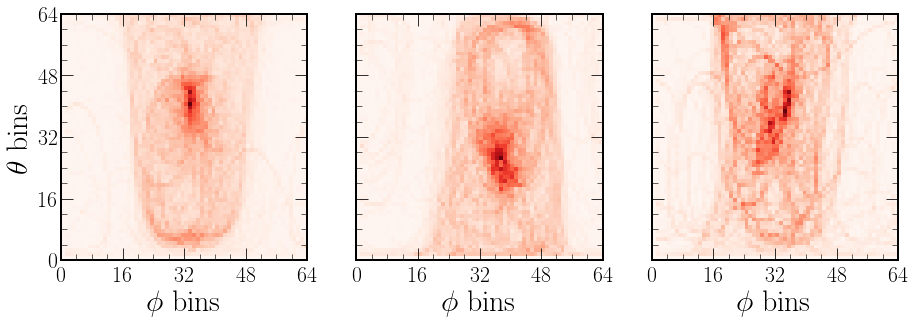

In [26]:
chipsnet.plotting.plot_hough(images_dict, [1009, 2014, 1045], save_path+"explore_hough_events")

[0,25], outside range: 0.0010
[0,120], outside range: 0.0015
[0,3500], outside range: 0.0023


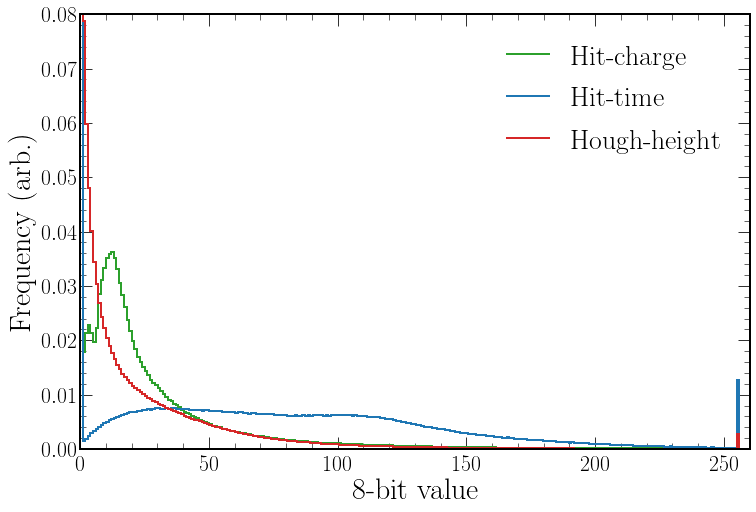

In [44]:
chipsnet.plotting.plot_8bit_range(images_dict, save_path=save_path)

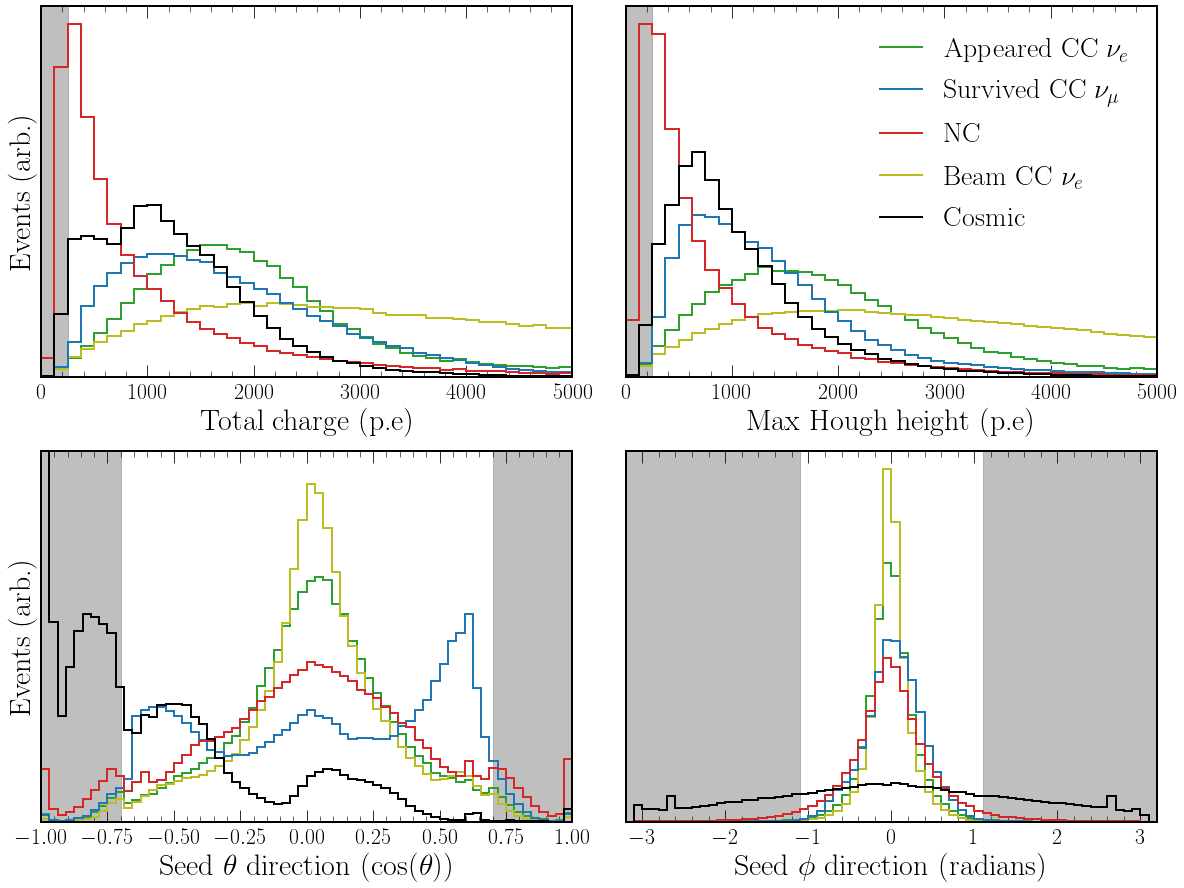

In [45]:
chipsnet.plotting.plot_cuts(config, flux_ev, save_path)

In [46]:
# Tidy up
del s_both_ev, s_both_out
del s_flux_ev, s_flux_out
del s_uniform_ev, s_uniform_out
del flux_ev, flux_out
del images_dict
del numu_ev, nuel_ev, osc_nuel_ev

<a id='sample'></a>

## Which training sample is best? (sample)

In [27]:
ev, outputs = chipsnet.utils.evaluate(
    config, 
    "flux", 
    ["sample_both", "sample_flux", "sample_uniform"],
    ["t_all_cat", "t_all_cat", "t_all_cat"]
)


************************ Evaluating flux ************************
Loading best checkpoint (7)
Loading best checkpoint (6)
Loading best checkpoint (6)
Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ sample_both report ------------------------
- Comb-> Prec: (0.93985,0.69922), Rec: (0.90417,0.86363), F1: (0.91707,0.73937)
- Cat->  Prec: (0.58614,0.33926), Rec: (0.49472,0.43360), F1: (0.50882,0.30762)

- Nuel-> ROC-AUC: 0.82063, PRC-AUC: 0.63435, S-Eff: 0.83424, S-Pur: 0.36824
- FOM1-> 0.38633, 0.84000, 52.60899, 19.58427, 18.26930, 0.66430, 0.58156
- FOM2-> 10.10865, 0.96000, 30.52769, 4.49055, 4.62960, 0.38548, 0.76997

- Numu-> ROC-AUC: 0.66439, PRC-AUC: 0.92134, S-Eff: 0.85416, S-Pur: 0.99373
- FOM1-> 0.87120, 0.10500, 4.15660, 1834.53772, 48.01004, 0.89598, 0.97235
- FOM2-> 2162.32989, 0.99500, 0.02434, 1409.12873, 0.40033, 0.68821, 0.9997

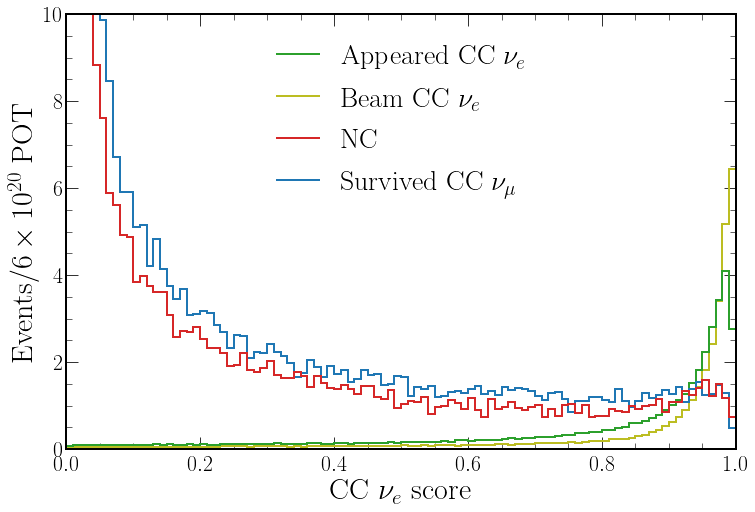

In [28]:
chipsnet.plotting.plot_combined_values(ev, 0, "sample_both_", save_path+"sample_both_output_values")

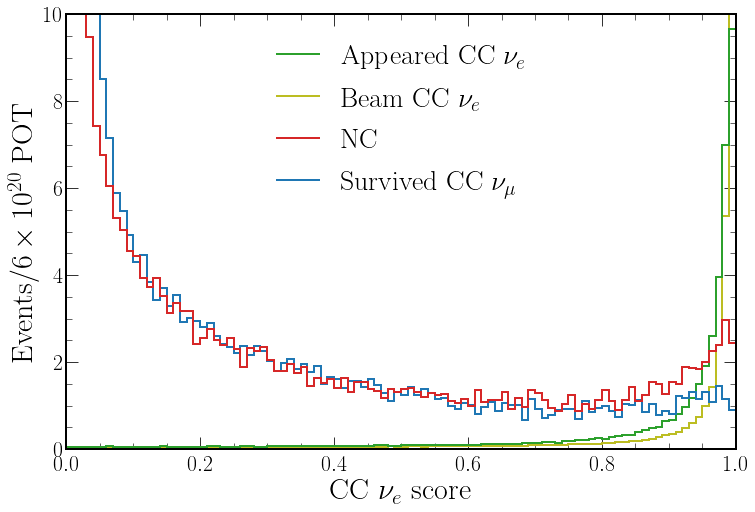

In [29]:
chipsnet.plotting.plot_combined_values(ev, 0, "sample_flux_", save_path+"sample_flux_output_values")

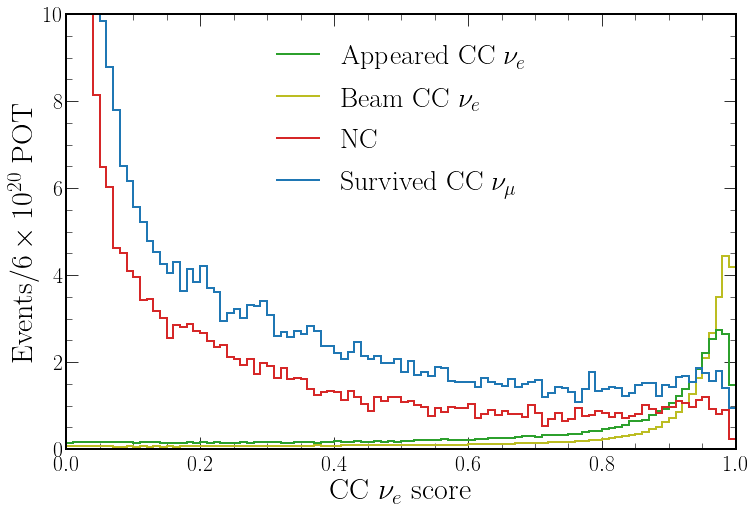

In [30]:
chipsnet.plotting.plot_combined_values(ev, 0, "sample_uniform_", save_path+"sample_uniform_output_values")

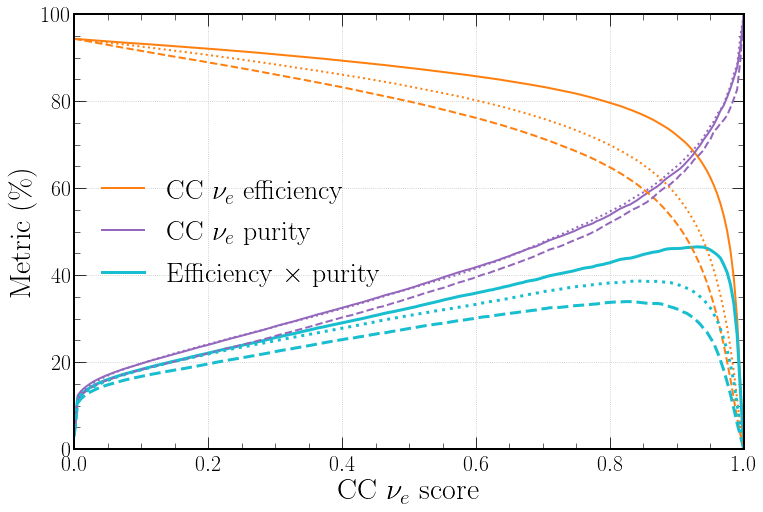

In [31]:
chipsnet.plotting.plot_eff_curves([outputs[1], outputs[2], outputs[0]], 0, save_path+"sample_nuel_eff_curves")

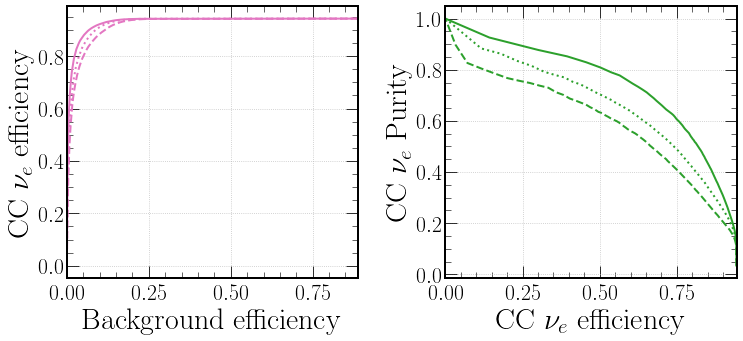

In [32]:
chipsnet.plotting.plot_comp_curves([outputs[1], outputs[2], outputs[0]], 0, save_path+"sample_nuel_comp_curves")

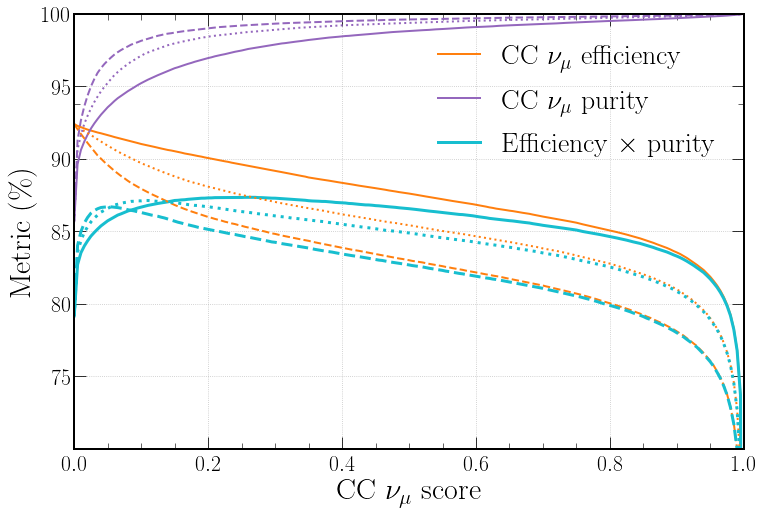

In [33]:
chipsnet.plotting.plot_eff_curves([outputs[1], outputs[2], outputs[0]], 1, save_path+"sample_numu_eff_curves")

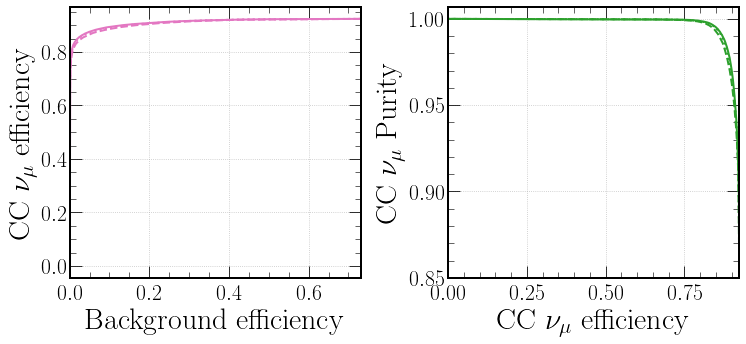

In [34]:
chipsnet.plotting.plot_comp_curves([outputs[1], outputs[2], outputs[0]], 1, save_path+"sample_numu_comp_curves")

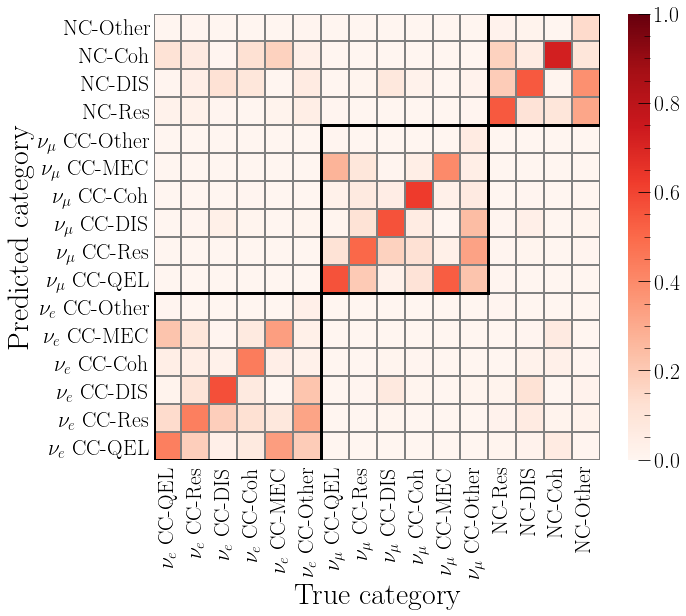

In [35]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    outputs[0]["cat_matrix"],
    annot=False, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16],
    yticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16][::-1],
    cbar=True,
    cbar_kws={"shrink": .82},
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
axs.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
axs.set_xlabel('True category', fontsize = 30)
axs.set_ylabel('Predicted category', fontsize = 30)
axs.add_patch(patches.Rectangle((0, 10), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((6, 4), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((12, 0), 4, 4, linewidth=3, edgecolor='black', facecolor='none'))
chipsnet.plotting.save(save_path + "sample_both_matrix")

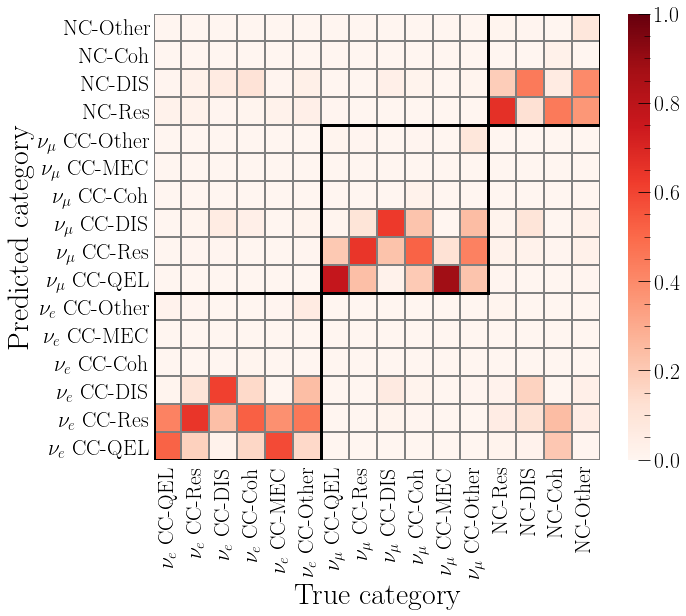

In [36]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    outputs[1]["cat_matrix"],
    annot=False, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16],
    yticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16][::-1],
    cbar=True,
    cbar_kws={"shrink": .82},
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
axs.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
axs.set_xlabel('True category', fontsize = 30)
axs.set_ylabel('Predicted category', fontsize = 30)
axs.add_patch(patches.Rectangle((0, 10), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((6, 4), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((12, 0), 4, 4, linewidth=3, edgecolor='black', facecolor='none'))
chipsnet.plotting.save(save_path + "sample_flux_matrix")

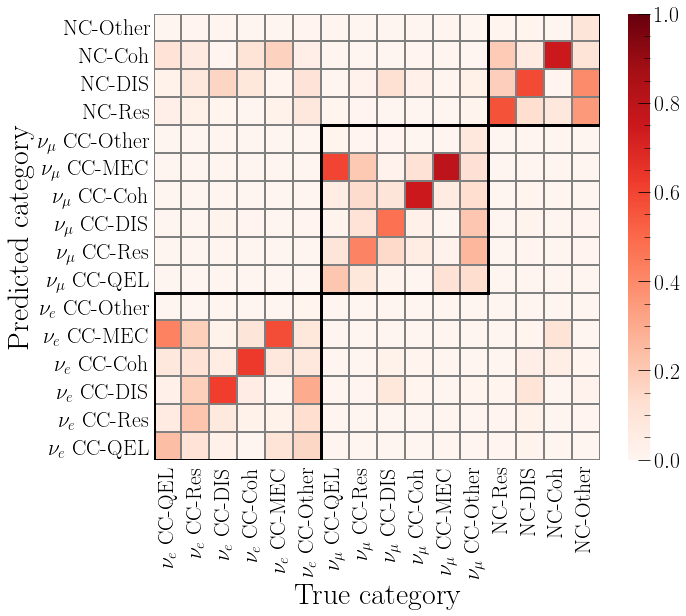

In [37]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    outputs[2]["cat_matrix"],
    annot=False, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16],
    yticklabels=chipsnet.data.MAP_ALL_CAT["labels"][:16][::-1],
    cbar=True,
    cbar_kws={"shrink": .82},
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
axs.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
axs.set_xlabel('True category', fontsize = 30)
axs.set_ylabel('Predicted category', fontsize = 30)
axs.add_patch(patches.Rectangle((0, 10), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((6, 4), 6, 6, linewidth=3, edgecolor='black', facecolor='none'))
axs.add_patch(patches.Rectangle((12, 0), 4, 4, linewidth=3, edgecolor='black', facecolor='none'))
chipsnet.plotting.save(save_path + "sample_uniform_matrix")

In [38]:
# Tidy up
del ev, outputs

<a id='repr'></a>

## Which image representation is best? (repr)

In [39]:
v_out = chipsnet.utils.evaluate(config, "v_ct_flux", ["repr_v_ct"], ["t_all_cat"], just_out=True)  # Vertex theta/phi repr
o_out = chipsnet.utils.evaluate(config, "o_ct_flux", ["repr_o_ct"], ["t_all_cat"], just_out=True)  # Origin theta/phi repr
i_out = chipsnet.utils.evaluate(config, "i_ct_flux", ["repr_i_ct"], ["t_all_cat"], just_out=True)  # Origin x+/x- repr


************************ Evaluating v_ct_flux ************************
Loading best checkpoint (6)
Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ repr_v_ct report ------------------------
- Comb-> Prec: (0.94500,0.71825), Rec: (0.90759,0.85194), F1: (0.91984,0.73190)
- Cat->  Prec: (0.58095,0.35857), Rec: (0.55901,0.32609), F1: (0.54126,0.27741)

- Nuel-> ROC-AUC: 0.82509, PRC-AUC: 0.70687, S-Eff: 0.87787, S-Pur: 0.35429
- FOM1-> 0.46126, 0.93000, 52.98655, 8.61419, 15.25688, 0.66907, 0.68941
- FOM2-> 13.26466, 0.98500, 29.73851, 1.43964, 3.58663, 0.37551, 0.85542

- Numu-> ROC-AUC: 0.66452, PRC-AUC: 0.92136, S-Eff: 0.87094, S-Pur: 0.98952
- FOM1-> 0.87257, 0.21500, 3.47305, 1832.93848, 44.05568, 0.89520, 0.97473
- FOM2-> 1808.01638, 0.99500, 0.02799, 1479.19995, 0.64136, 0.72243, 0.99955

took 516.90 seconds

************************ Evalu

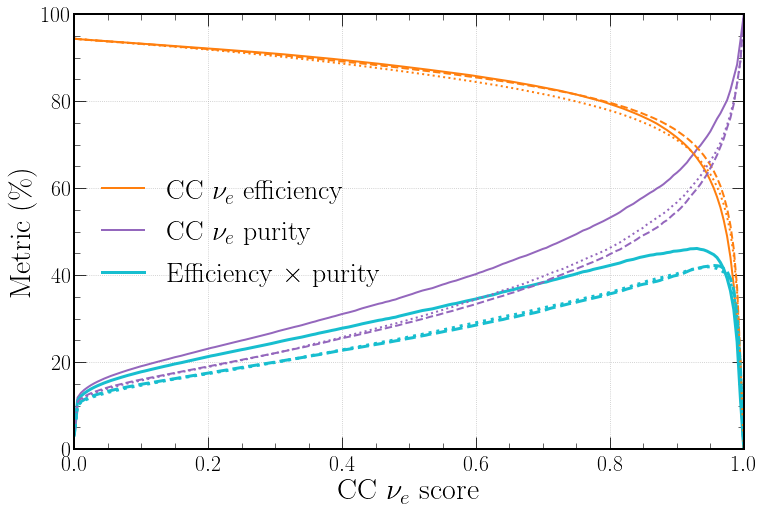

In [40]:
chipsnet.plotting.plot_eff_curves([v_out[0], o_out[0], i_out[0]], 0, save_path+"repr_nuel_eff_curves")

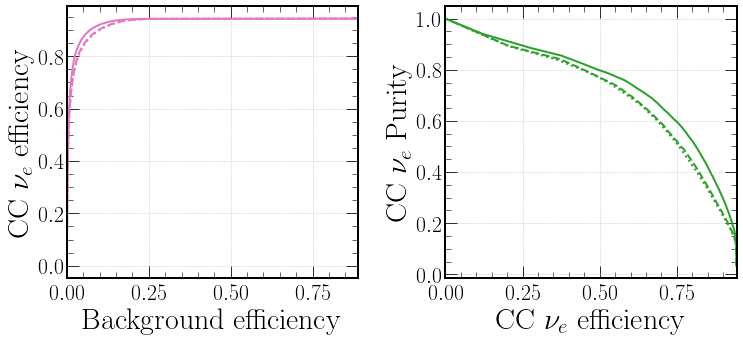

In [41]:
chipsnet.plotting.plot_comp_curves([v_out[0], o_out[0], i_out[0]], 0, save_path+"repr_nuel_comp_curves")

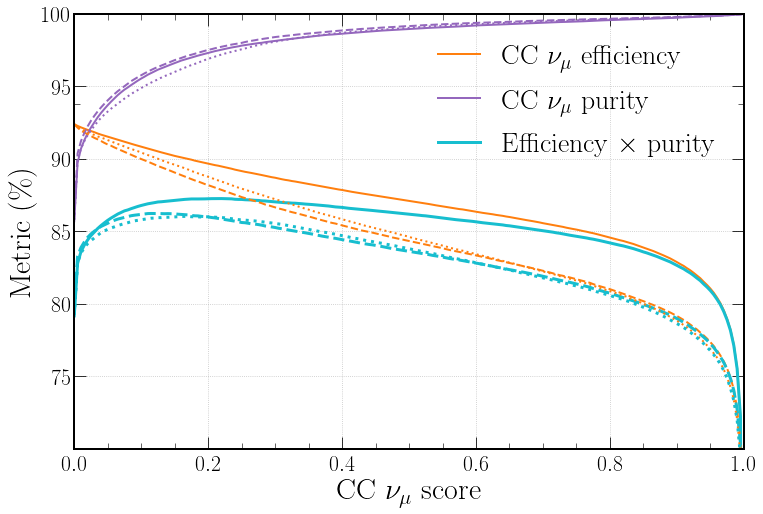

In [42]:
chipsnet.plotting.plot_eff_curves([v_out[0], o_out[0], i_out[0]], 1, save_path+"repr_numu_eff_curves")

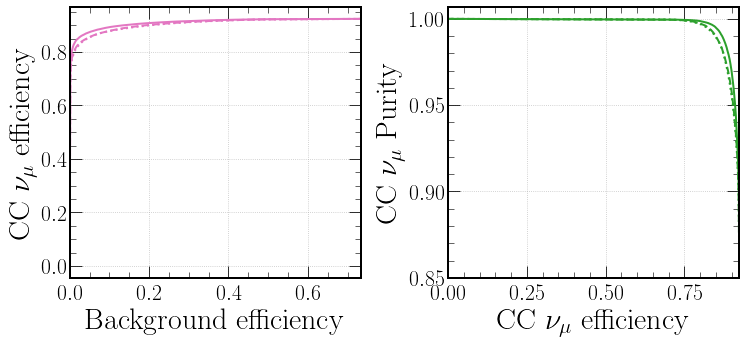

In [43]:
chipsnet.plotting.plot_comp_curves([v_out[0], o_out[0], i_out[0]], 1, save_path+"repr_numu_comp_curves")

In [44]:
# Tidy up
del v_out
del o_out
del i_out

<a id='arch'></a>

## Which network architecture works best?

In [10]:
outputs = chipsnet.utils.evaluate(
    config, 
    "flux", 
    ["arch_vgg", "arch_inception", "arch_resnet", "arch_inception_resnet"],
    ["t_all_cat", "t_all_cat", "t_all_cat", "t_all_cat"],
    just_out=True
)


************************ Evaluating flux ************************
Loading best checkpoint (6)
Loading best checkpoint (7)
Loading best checkpoint (6)
Loading best checkpoint (8)
Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ arch_vgg report ------------------------
- Comb-> Prec: (0.94475,0.72482), Rec: (0.91101,0.85060), F1: (0.92157,0.73694)
- Cat->  Prec: (0.58298,0.37149), Rec: (0.56389,0.32640), F1: (0.54442,0.27884)

- Nuel-> ROC-AUC: 0.82559, PRC-AUC: 0.71155, S-Eff: 0.87661, S-Pur: 0.36926
- FOM1-> 0.46502, 0.93000, 53.44466, 8.36064, 15.75486, 0.67485, 0.68907
- FOM2-> 13.44660, 0.98500, 31.21698, 1.57028, 3.81933, 0.39418, 0.85277

- Numu-> ROC-AUC: 0.66483, PRC-AUC: 0.92144, S-Eff: 0.87597, S-Pur: 0.98808
- FOM1-> 0.87339, 0.25500, 3.22958, 1833.71393, 43.34867, 0.89558, 0.97523
- FOM2-> 1850.91122, 0.99500, 0.03552, 1509.61970, 

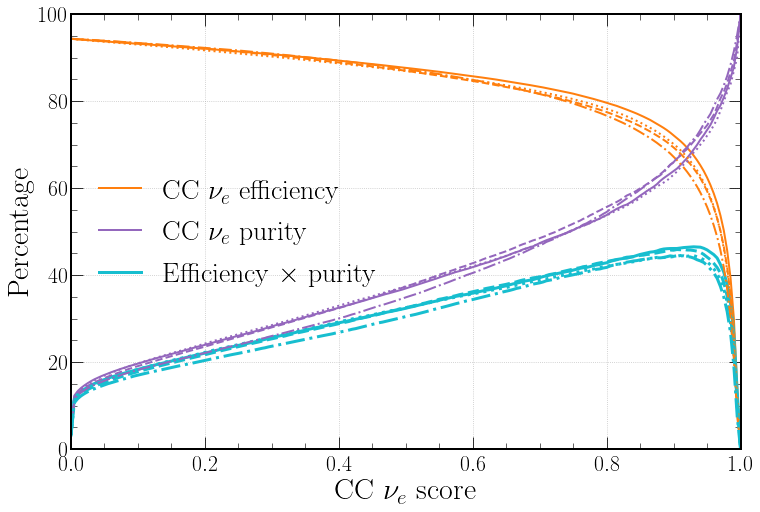

In [11]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 0, save_path+"arch_nuel_eff_curves")

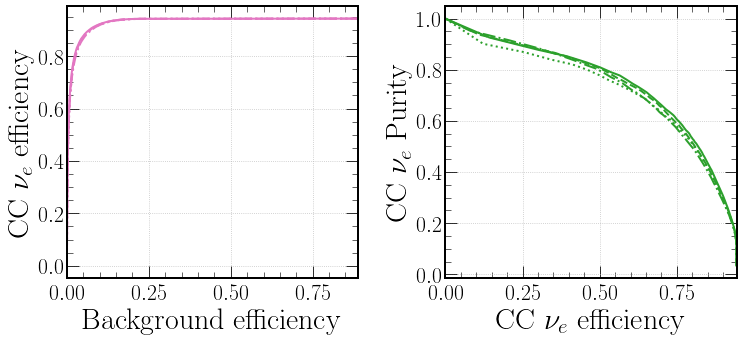

In [12]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 0, save_path+"arch_nuel_comp_curves")

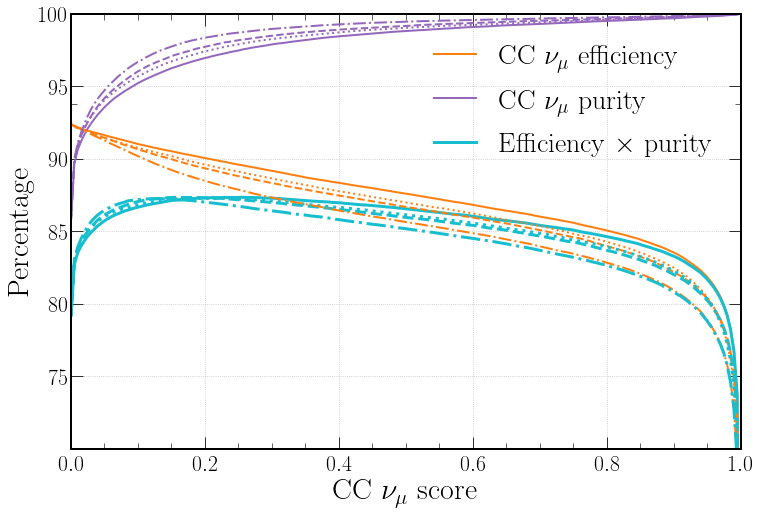

In [13]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 1, save_path+"arch_numu_eff_curves")

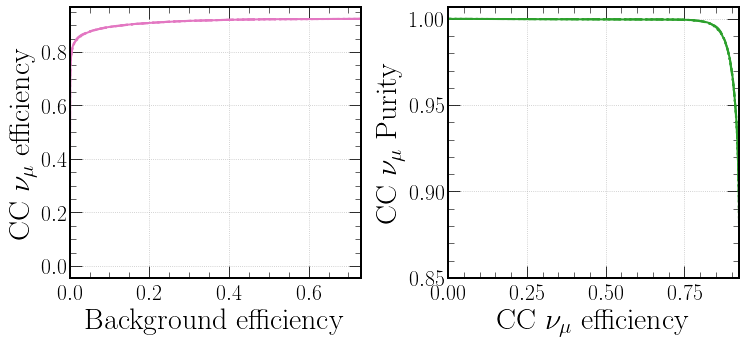

In [14]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 1, save_path+"arch_numu_comp_curves")

In [15]:
# Tidy up
del outputs

<a id='channel'></a>

## Which channel configuration is best? (channel)

In [16]:
c_out = chipsnet.utils.evaluate(config, "v_c_flux", ["repr_v_c"], ["t_all_cat"], just_out=True)  # Just charge channel
ct_out = chipsnet.utils.evaluate(config, "v_ct_flux", ["repr_v_ct"], ["t_all_cat"], just_out=True)  # Charge+time channels
cth_out = chipsnet.utils.evaluate(config,"v_cth_flux", ["repr_v_cth"], ["t_all_cat"], just_out=True)  # Charge+time+hough channels
cth_stacked_out = chipsnet.utils.evaluate(config, "v_cth_flux_stacked", ["repr_v_cth_stacked"], ["t_all_cat"], just_out=True)  # Charge+time+hough channels stacked


************************ Evaluating v_c_flux ************************
Loading best checkpoint (7)
Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ repr_v_c report ------------------------
- Comb-> Prec: (0.94304,0.71334), Rec: (0.90703,0.85439), F1: (0.91928,0.73422)
- Cat->  Prec: (0.57348,0.35221), Rec: (0.54850,0.31747), F1: (0.52990,0.27058)

- Nuel-> ROC-AUC: 0.82377, PRC-AUC: 0.68936, S-Eff: 0.86860, S-Pur: 0.35675
- FOM1-> 0.43608, 0.91000, 53.71033, 12.22704, 17.59424, 0.67821, 0.64299
- FOM2-> 12.70511, 0.99000, 20.74129, 0.76294, 1.90217, 0.26190, 0.88614

- Numu-> ROC-AUC: 0.66320, PRC-AUC: 0.92108, S-Eff: 0.86814, S-Pur: 0.98982
- FOM1-> 0.86820, 0.20500, 3.47053, 1825.09956, 45.22359, 0.89137, 0.97401
- FOM2-> 1781.73137, 0.99500, 0.05013, 1510.25853, 0.66836, 0.73760, 0.99952

took 467.76 seconds

************************ Evalua

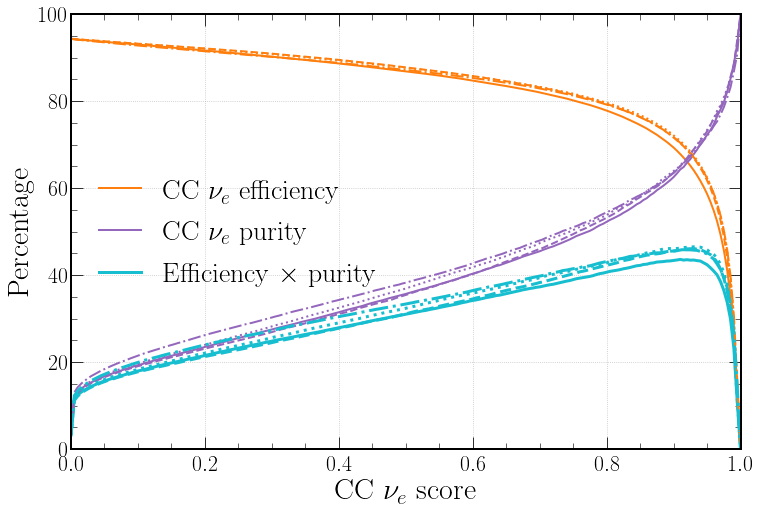

In [17]:
chipsnet.plotting.plot_eff_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 0, save_path+"channel_nuel_eff_curves")

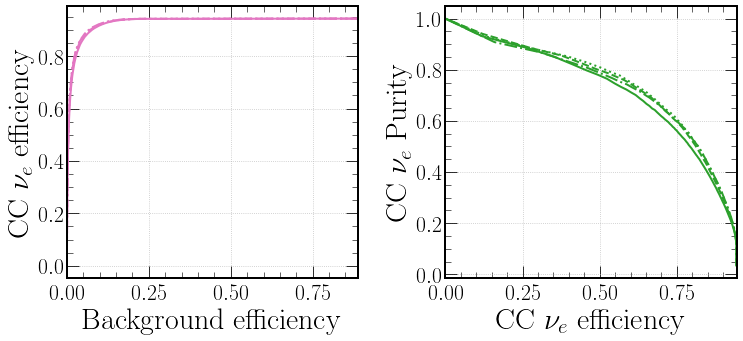

In [18]:
chipsnet.plotting.plot_comp_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 0, save_path+"channel_nuel_comp_curves")

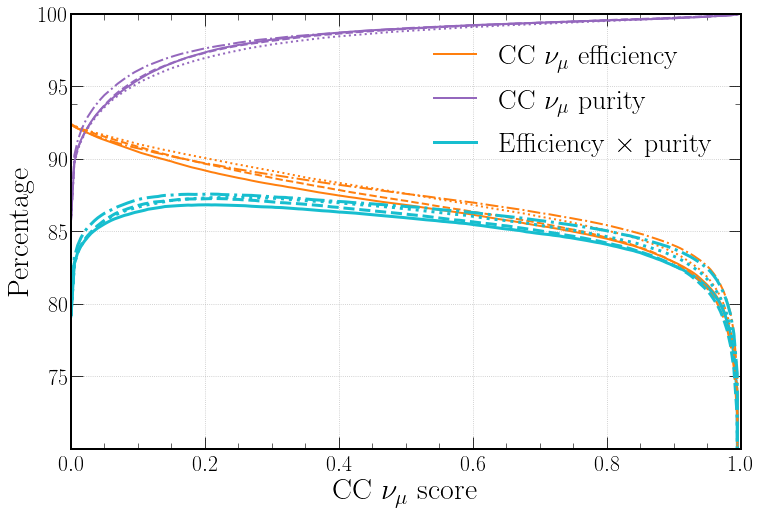

In [19]:
chipsnet.plotting.plot_eff_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 1, save_path+"channel_numu_eff_curves")

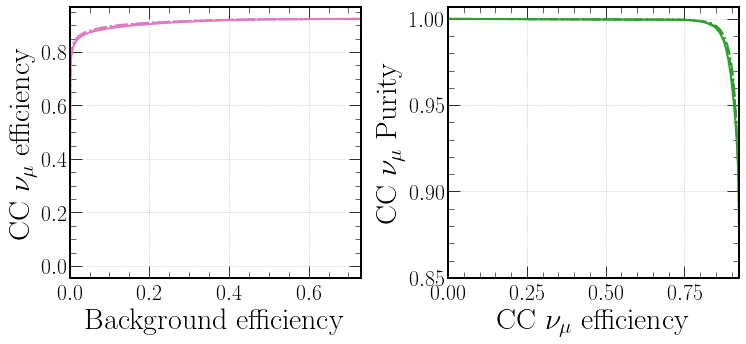

In [20]:
chipsnet.plotting.plot_comp_curves([c_out[0], ct_out[0], cth_out[0], cth_stacked_out[0]], 1, save_path+"channel_numu_comp_curves")

In [21]:
# Tidy up
del c_out
del ct_out
del cth_out
del cth_stacked_out

<a id='cat'></a>

## Which categorisation is best? (cat)

In [22]:
outputs = chipsnet.utils.evaluate(
    config, 
    "flux", 
    ["cat_t_all_cat", "cat_t_nc_comb_cat", "cat_t_comb_cat", "cat_split", "cat_split_learn"], 
    ["t_all_cat", "t_nc_comb_cat", "t_comb_cat", "t_comb_cat", "t_comb_cat"],
    just_out=True
)


************************ Evaluating flux ************************
Loading best checkpoint (6)
Loading best checkpoint (7)
Loading best checkpoint (5)
Loading best checkpoint (6)
Loading best checkpoint (6)
Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ cat_t_all_cat report ------------------------
- Comb-> Prec: (0.94475,0.72482), Rec: (0.91101,0.85060), F1: (0.92157,0.73694)
- Cat->  Prec: (0.58298,0.37149), Rec: (0.56389,0.32640), F1: (0.54442,0.27884)

- Nuel-> ROC-AUC: 0.82559, PRC-AUC: 0.71155, S-Eff: 0.87661, S-Pur: 0.36926
- FOM1-> 0.46502, 0.93000, 53.44466, 8.36064, 15.75486, 0.67485, 0.68907
- FOM2-> 13.44660, 0.98500, 31.21698, 1.57028, 3.81933, 0.39418, 0.85277

- Numu-> ROC-AUC: 0.66483, PRC-AUC: 0.92144, S-Eff: 0.87597, S-Pur: 0.98808
- FOM1-> 0.87339, 0.25500, 3.22958, 1833.71393, 43.34867, 0.89558, 0.97523
- FOM2-> 1850.9112

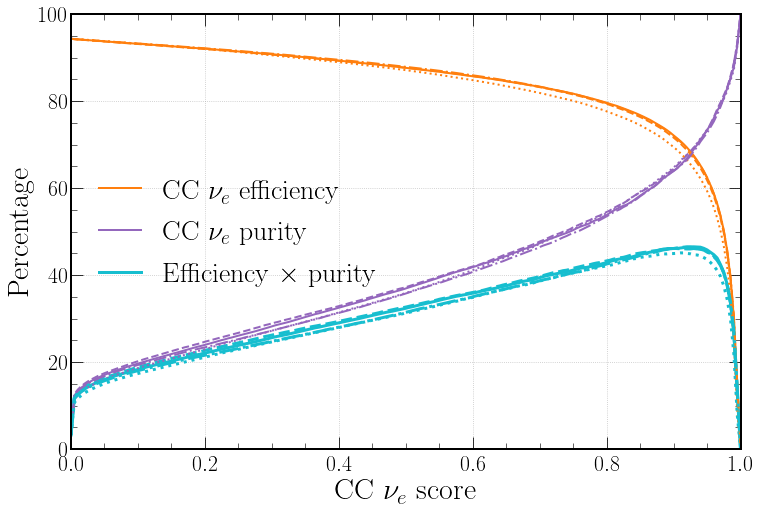

In [23]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 0, save_path+"cat_nuel_eff_curves")

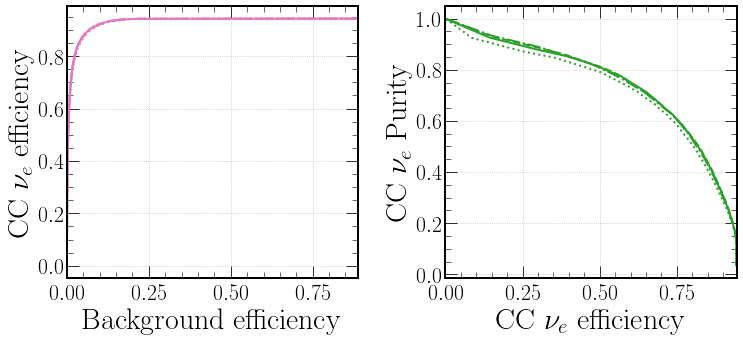

In [24]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 0, save_path+"cat_nuel_comp_curves")

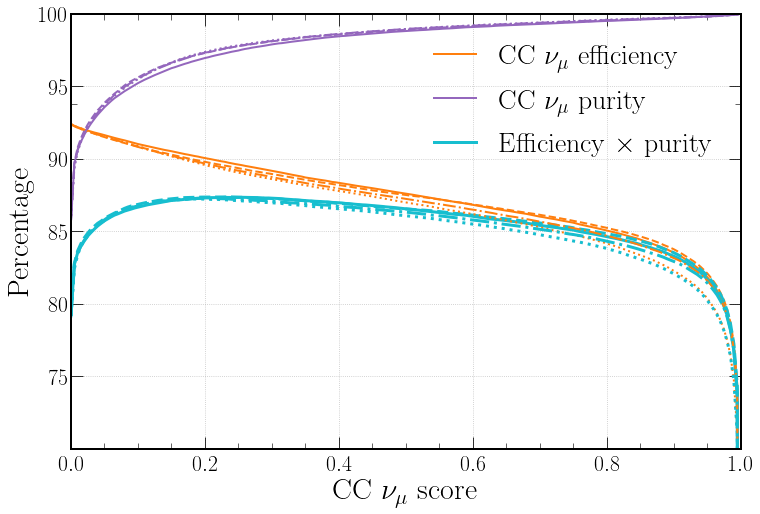

In [25]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 1, save_path+"cat_numu_eff_curves")

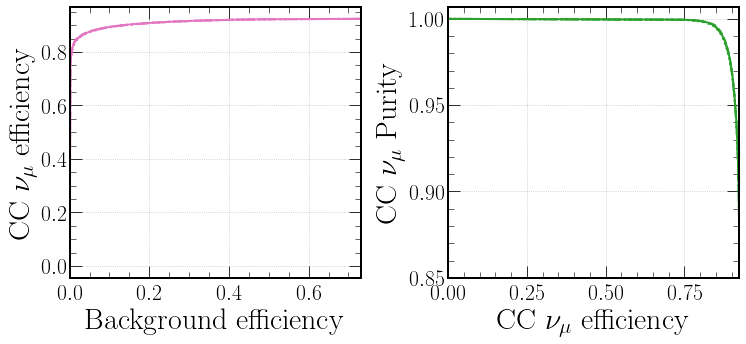

In [26]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2], outputs[3]], 1, save_path+"cat_numu_comp_curves")

In [27]:
# Tidy up
del outputs

<a id='cosmic'></a>

## Does escapes help cosmic classifier? (cosmic)

In [28]:
ev, out = chipsnet.utils.evaluate(config, "cosmic", ["repr_v_cth", "cosmic"], ["t_all_cat", "t_cosmic_cat"], just_cosmic=True)
ev_e, out_e = chipsnet.utils.evaluate(config, "cosmic", ["repr_v_cth", "cosmic_escapes"], ["t_all_cat", "t_cosmic_cat"], just_cosmic=True)
ev_el, out_el = chipsnet.utils.evaluate(config, "cosmic", ["repr_v_cth", "cosmic_escapes_learn"], ["t_all_cat", "t_cosmic_cat"], just_cosmic=True)


************************ Evaluating cosmic ************************
Loading best checkpoint (6)
Loading best checkpoint (6)
Weights: (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000), (352768,5.96343)
count    3.527680e+05
mean     9.992678e-01
std      1.917461e-02
min      2.661729e-10
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: cosmic_pred_t_cosmic_cat, dtype: float64
Cuts:    (0,0.00000), (0,0.00000), (0,0.00000), (5,0.00001)
took 303.91 seconds

************************ Evaluating cosmic ************************
Loading best checkpoint (6)
Loading best checkpoint (3)
Weights: (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000), (352768,5.96343)
count    352768.000000
mean          0.998948
std           0.020130
min           0.000795
25%           0.999990
50%           0.999999
75%           1.000000
max           1.000000
Name: cosmic_escapes_pred_t_cosmic_cat, dtype: float64
count    263384.000000
mean          0.914934
std   

In [29]:
print(ev[ev["cut"] == 0]["repr_v_cth_pred_t_comb_cat_0"].to_numpy())
print(ev[ev["cut"] == 0]["repr_v_cth_pred_t_comb_cat_1"].to_numpy())
print(ev[ev["cut"] == 0]["repr_v_cth_pred_t_comb_cat_2"].to_numpy())
print(ev[ev["cut"] == 0]["repr_v_cth_comb_cat_class"].to_numpy())

[1.60869889e-06 4.81993832e-02 7.36997829e-04 3.43009281e-03
 1.62602141e-06]
[0.99998447 0.69527436 0.82574341 0.96367255 0.99997244]
[1.39880872e-05 2.56526230e-01 1.73519592e-01 3.28972821e-02
 2.60521894e-05]
[1 1 1 1 1]


In [30]:
print(ev_e[ev_e["cut"] == 0]["repr_v_cth_pred_t_comb_cat_0"].to_numpy())
print(ev_e[ev_e["cut"] == 0]["repr_v_cth_pred_t_comb_cat_1"].to_numpy())
print(ev_e[ev_e["cut"] == 0]["repr_v_cth_pred_t_comb_cat_2"].to_numpy())
print(ev_e[ev_e["cut"] == 0]["repr_v_cth_comb_cat_class"].to_numpy())

[]
[]
[]
[]


In [31]:
print(ev_el[ev_el["cut"] == 0]["repr_v_cth_pred_t_comb_cat_0"].to_numpy())
print(ev_el[ev_el["cut"] == 0]["repr_v_cth_pred_t_comb_cat_1"].to_numpy())
print(ev_el[ev_el["cut"] == 0]["repr_v_cth_pred_t_comb_cat_2"].to_numpy())
print(ev_el[ev_el["cut"] == 0]["repr_v_cth_comb_cat_class"].to_numpy())

[1.60869889e-06 5.87051191e-04]
[0.99998447 0.99703023]
[1.39880872e-05 2.38266941e-03]
[1 1]


In [32]:
# Tidy up
del ev, out
del ev_e, out_e
del ev_el, out_el

<a id='beam'></a>

## Does primary count help beam classifier? (beam)

In [33]:
outputs = chipsnet.utils.evaluate(
    config, 
    "flux", 
    ["beam", "beam_primaries", "beam_primaries_learn"],
    ["t_comb_cat", "t_comb_cat", "t_comb_cat"],
    just_out=True
)


************************ Evaluating flux ************************
Loading best checkpoint (6)
Loading best checkpoint (6)
Loading best checkpoint (4)
Weights: (193411,0.00020), (224164,0.00001), (192790,0.01739), (218139,0.00034), (0,0.00000)
Cuts:    (501534,0.96036), (329828,0.93127), (102668,0.69562), (0,0.00000)

------------------------ beam report ------------------------
- Comb-> Prec: (0.94460,0.73396), Rec: (0.91712,0.85570), F1: (0.92554,0.75109)
- Cat->  Prec: (0.94460,0.73396), Rec: (0.91712,0.85570), F1: (0.92554,0.75109)

- Nuel-> ROC-AUC: 0.82578, PRC-AUC: 0.71645, S-Eff: 0.87189, S-Pur: 0.39328
- FOM1-> 0.47189, 0.92500, 54.78723, 9.24023, 16.29230, 0.69180, 0.68211
- FOM2-> 13.51902, 0.99000, 25.60008, 1.11573, 2.47012, 0.32325, 0.87714

- Numu-> ROC-AUC: 0.66495, PRC-AUC: 0.92146, S-Eff: 0.88083, S-Pur: 0.98647
- FOM1-> 0.87415, 0.21500, 3.82082, 1843.34386, 51.28133, 0.90028, 0.97098
- FOM2-> 1677.56232, 0.99500, 0.05181, 1534.44135, 0.78484, 0.74941, 0.99946


----

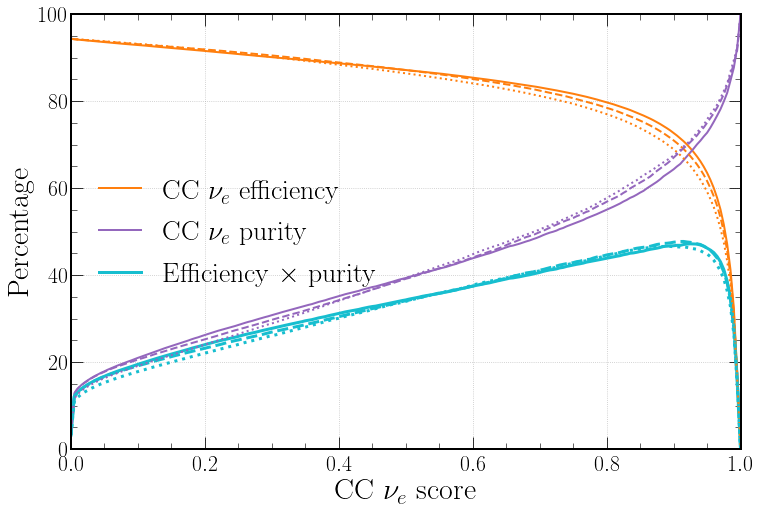

In [34]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2]], 0, save_path+"beam_nuel_eff_curves")

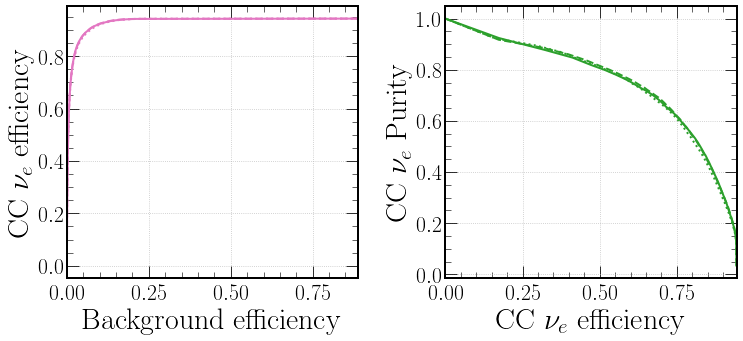

In [35]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2]], 0, save_path+"beam_nuel_comp_curves")

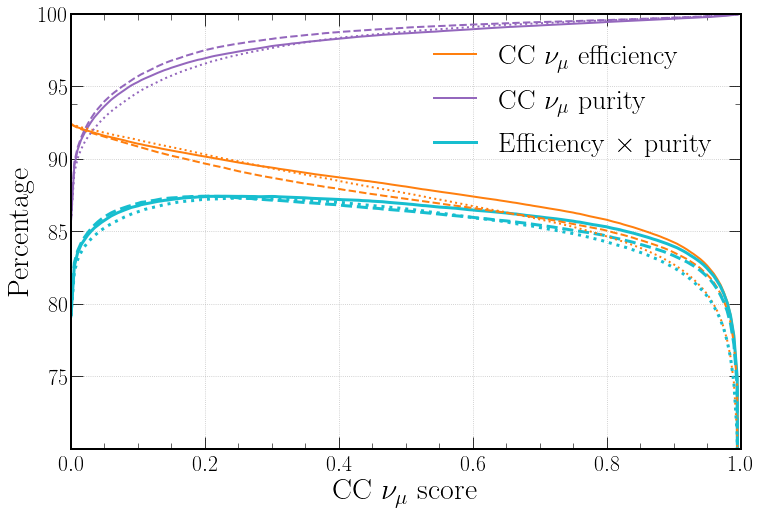

In [36]:
chipsnet.plotting.plot_eff_curves([outputs[0], outputs[1], outputs[2]], 1, save_path+"beam_numu_eff_curves")

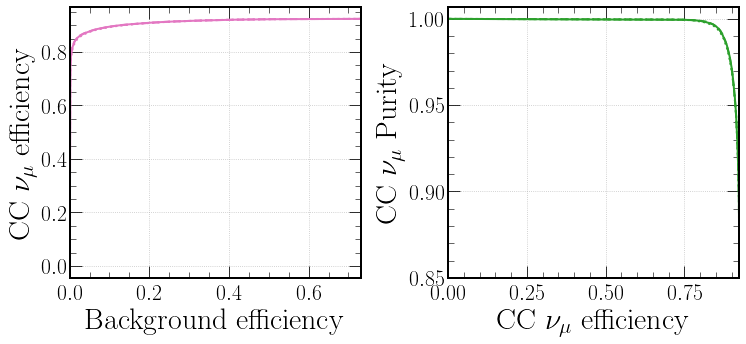

In [37]:
chipsnet.plotting.plot_comp_curves([outputs[0], outputs[1], outputs[2]], 1, save_path+"beam_numu_comp_curves")

In [38]:
# Tidy up
del outputs

<a id='energy_multi'></a>

## Does lepton energy and vertex position help neutrino energy estimation? (energy_multi)

In [39]:
events, outputs = chipsnet.utils.evaluate(
    config,
    "nuel_ccqel",
    ["energy_nu", "energy_lep", "energy_nu_lep", "energy_nu_lep_learn", "energy_nu_lep_vtx", "energy_nu_lep_vtx_learn"],
    ["energy", "energy", "energy", "energy"]
)


************************ Evaluating nuel_ccqel ************************
Loading best checkpoint (11)
Loading best checkpoint (18)
Loading best checkpoint (11)
Loading best checkpoint (17)
Loading best checkpoint (7)
Loading best checkpoint (19)
Weights: (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000), (0,0.00000)
Cuts:    (77357,0.97476), (0,0.00000), (0,0.00000), (0,0.00000)
took 161.96 seconds


In [40]:
ev = events[(events["cut"] == 0) & (events["t_comb_cat"] == 0) & (events["t_lep_energy"] != -1)]

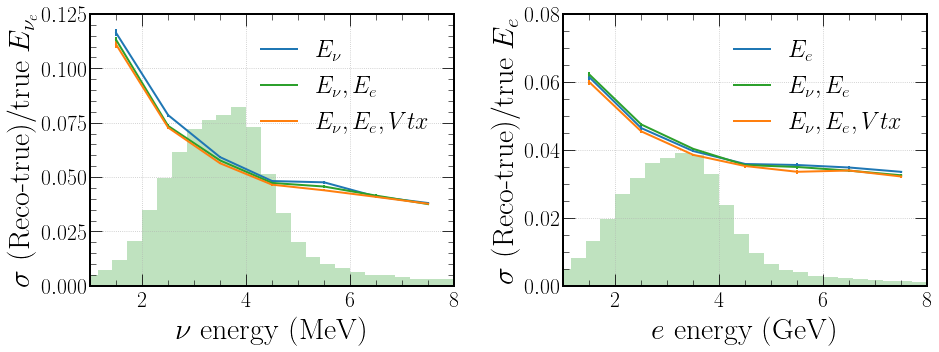

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.3})
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:blue", linewidth=2)
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_learn_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:green", linewidth=2)
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_vtx_learn_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:orange", linewidth=2)
axs[0].set_xlabel(r"$\nu$ energy (MeV)", fontsize=30)
axs[0].set_ylabel(r"$\sigma$ (Reco-true)/true $E_{\nu_{e}}$", fontsize=30)
axs[0].set_ylim(0.0, 0.125)
axs[0].set_xlim(1, 8)
axs[0].grid()
axs[0].hist(
    ev["t_nu_energy"]/1000,
    range=(0, 8),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=ev["w"] * 0.00001,
)

e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_lep_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:blue", linewidth=2)
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_learn_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:green", linewidth=2)
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(ev, fit_name="energy_nu_lep_vtx_learn_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:orange", linewidth=2)
axs[1].set_xlabel(r"$e$ energy (GeV)", fontsize=30)
axs[1].set_ylabel(r"$\sigma$ (Reco-true)/true $E_{e}$", fontsize=30)
axs[1].set_ylim(0.0, 0.08)
axs[1].set_xlim(1, 8)
axs[1].grid()
axs[1].hist(
    ev["t_lep_energy"]/1000,
    range=(0, 8),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=ev["w"] * 0.000005,
)

nu = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"$E_{\nu}$")
lep = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"$E_{e}$")
nu_lep_learn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$E_{\nu},E_{e}$")
nu_lep_vtx_learn = Line2D([0], [0], color="tab:orange", linewidth=2, linestyle="solid", label=r"$E_{\nu},E_{e},Vtx$")
axs[0].legend(handles=[nu, nu_lep_learn, nu_lep_vtx_learn], loc="upper right", fontsize=24)
axs[1].legend(handles=[lep, nu_lep_learn, nu_lep_vtx_learn], loc="upper right", fontsize=24)

chipsnet.plotting.save(save_path + "energy_multi_frac_vs_e")

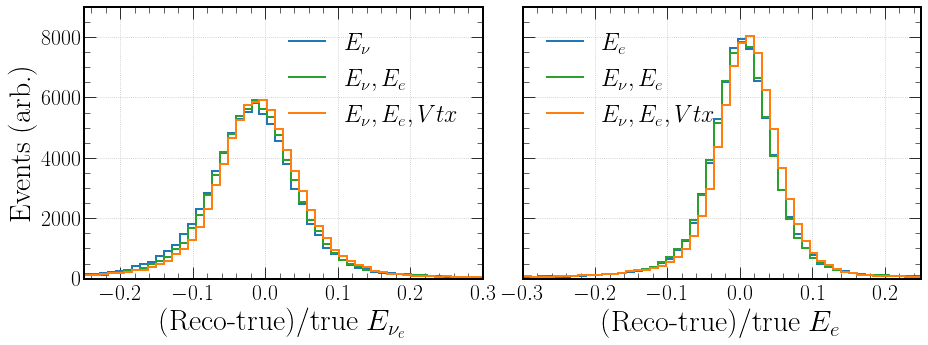

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
axs[0].hist(
    ev['energy_nu_frac_nu_energy'], 
    weights=ev["w"], 
    range=(-0.25, 0.30), bins=50, histtype='step', color="tab:blue", linewidth=2
)
axs[0].hist(
    ev['energy_nu_lep_learn_frac_nu_energy'], 
    weights=ev["w"],
    range=(-0.25, 0.30), bins=50, histtype='step', color="tab:green", linewidth=2
)
axs[0].hist(
    ev['energy_nu_lep_vtx_learn_frac_nu_energy'], 
    weights=ev["w"],
    range=(-0.25, 0.30), bins=50, histtype='step', color="tab:orange", linewidth=2
)
axs[0].set_xlabel(r"(Reco-true)/true $E_{\nu_{e}}$", fontsize=30) 
axs[0].set_ylabel(r"Events (arb.)", fontsize=30)
axs[0].grid()
axs[0].label_outer()
axs[0].set_ylim(0, 9000)
axs[1].hist(
    ev['energy_lep_frac_lep_energy'], 
    weights=ev["w"],
    range=(-0.30, 0.25), bins=50, histtype='step', color="tab:blue", linewidth=2
)
axs[1].hist(
    ev['energy_nu_lep_learn_frac_lep_energy'], 
    weights=ev["w"],
    range=(-0.30, 0.25), bins=50, histtype='step', color="tab:green", linewidth=2
)
axs[1].hist(
    ev['energy_nu_lep_vtx_learn_frac_lep_energy'], 
    weights=ev["w"],
    range=(-0.30, 0.25), bins=50, histtype='step', color="tab:orange", linewidth=2
)
axs[1].set_xlabel(r"(Reco-true)/true $E_{e}$", fontsize=30)
axs[1].grid()
axs[1].label_outer()
axs[1].set_ylim(0, 9000)

nu = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"$E_{\nu}$")
lep = Line2D([0], [0], color="tab:blue", linewidth=2, linestyle="solid", label=r"$E_{e}$")
nu_lep_learn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"$E_{\nu},E_{e}$")
nu_lep_vtx_learn = Line2D([0], [0], color="tab:orange", linewidth=2, linestyle="solid", label=r"$E_{\nu},E_{e},Vtx$")
axs[0].legend(handles=[nu, nu_lep_learn, nu_lep_vtx_learn], loc="upper right", fontsize=24)
axs[1].legend(handles=[lep, nu_lep_learn, nu_lep_vtx_learn], loc="upper left", fontsize=24)

chipsnet.plotting.save(save_path + "energy_multi_frac_dist")

In [43]:
print(ev['energy_nu_frac_nu_energy'].describe())
print(ev['energy_nu_lep_frac_nu_energy'].describe())
print(ev['energy_nu_lep_learn_frac_nu_energy'].describe())
print(ev['energy_nu_lep_vtx_frac_nu_energy'].describe())
print(ev['energy_nu_lep_vtx_learn_frac_nu_energy'].describe())

count    77079.000000
mean        -0.018715
std          0.089749
min         -0.718726
25%         -0.060457
50%         -0.018250
75%          0.021707
max          2.810825
Name: energy_nu_frac_nu_energy, dtype: float64
count    77079.000000
mean        -0.017337
std          0.089353
min         -0.717637
25%         -0.059267
50%         -0.019633
75%          0.020652
max          2.906162
Name: energy_nu_lep_frac_nu_energy, dtype: float64
count    77079.000000
mean        -0.013996
std          0.087888
min         -0.704580
25%         -0.055065
50%         -0.014855
75%          0.024688
max          3.202766
Name: energy_nu_lep_learn_frac_nu_energy, dtype: float64
count    77079.000000
mean        -0.013349
std          0.091702
min         -0.726886
25%         -0.056430
50%         -0.016286
75%          0.025570
max          3.009444
Name: energy_nu_lep_vtx_frac_nu_energy, dtype: float64
count    77079.000000
mean        -0.009926
std          0.085390
min         -0.72647

In [44]:
print(ev['energy_lep_frac_lep_energy'].describe())
print(ev['energy_nu_lep_frac_lep_energy'].describe())
print(ev['energy_nu_lep_learn_frac_lep_energy'].describe())
print(ev['energy_nu_lep_vtx_frac_lep_energy'].describe())
print(ev['energy_nu_lep_vtx_learn_frac_lep_energy'].describe())

count    77079.000000
mean         0.005390
std          0.093544
min         -0.734775
25%         -0.026202
50%          0.003314
75%          0.033071
max          4.534911
Name: energy_lep_frac_lep_energy, dtype: float64
count    77079.000000
mean         0.002840
std          0.094898
min         -0.728223
25%         -0.030094
50%          0.000331
75%          0.030820
max          4.760154
Name: energy_nu_lep_frac_lep_energy, dtype: float64
count    77079.000000
mean         0.004220
std          0.091710
min         -0.727647
25%         -0.027032
50%          0.002922
75%          0.032541
max          4.889477
Name: energy_nu_lep_learn_frac_lep_energy, dtype: float64
count    77079.000000
mean        -0.003757
std          0.099922
min         -0.744467
25%         -0.038108
50%         -0.006438
75%          0.025165
max          4.545616
Name: energy_nu_lep_vtx_frac_lep_energy, dtype: float64
count    77079.000000
mean         0.009253
std          0.089103
min         -0.

In [45]:
# Tidy up
del events, outputs, ev

<a id='final'></a>

## Final performance and comparison with old reco/pid (final)

In [45]:
# Run analysis through all the final models
events, outputs = chipsnet.utils.evaluate(
    config, "flux_cosmic", 
    ["final_cosmic", "final_beam", "final_nuel_cc_e", "final_numu_cc_e",
     "final_nuel_ccdis_e", "final_nuel_ccqel_e", "final_nuel_ccres_e",
     "final_numu_ccdis_e", "final_numu_ccqel_e", "final_numu_ccres_e"],
    ["t_cosmic_cat", "t_comb_cat", "energy", "energy",
     "energy", "energy", "energy",
     "energy", "energy", "energy"]
)


************************ Evaluating flux_cosmic ************************
Loading best checkpoint (6)
Loading best checkpoint (7)
Loading best checkpoint (19)
Loading best checkpoint (10)
Loading best checkpoint (19)
Loading best checkpoint (16)
Loading best checkpoint (16)
Loading best checkpoint (11)
Loading best checkpoint (14)
Loading best checkpoint (10)
Weights: (178619,0.00022), (170335,0.00001), (148811,0.02253), (135788,0.00054), (254434,8.26819)
count    254434.000000
mean          0.998980
std           0.020888
min           0.000776
25%           0.999993
50%           1.000000
75%           1.000000
max           1.000000
Name: final_cosmic_pred_t_cosmic_cat, dtype: float64
count    340526.000000
mean          0.938776
std           0.141344
min           0.000004
25%           0.951863
50%           0.991969
75%           0.999019
max           1.000000
Name: final_cosmic_pred_t_escapes, dtype: float64
Cuts:    (391202,0.94774), (87572,0.35724), (75473,0.67592), (0,0.000

In [46]:
# Get events run through old reco/pid for comparisons
old_events = pd.concat([
    chipsnet.utils.get_old_df(old_nuel_file, 11),
    chipsnet.utils.get_old_df(old_numu_file, 13)
])
old_events = chipsnet.utils.apply_weights(old_events, verbose=True)

Weights: (0,0.00000), (0,0.00000), (23263,0.14414), (0,0.00000), (0,0.00000)


In [47]:
# Apply some standard operations we need throughout this section
def nuel_selected(event):
    if event["cut"] == 0 and event["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]:
        return True
    else:
        return False
    
def numu_selected(event):
    if event["cut"] == 0 and event["final_beam_pred_t_comb_cat_1"] >= outputs[0]["max_fom_cuts_0"][1]:
        return True
    else:
        return False
    
def nc_selected(event):
    if event["cosmic_cut"] == 0 and event["escapes_cut"] == 0 and not event["nuel_selected"] and not event["numu_selected"]:
        return True
    else:
        return False

events["nuel_selected"] = events.apply(nuel_selected, axis=1)
events["numu_selected"] = events.apply(numu_selected, axis=1)
events["nc_selected"] = events.apply(nc_selected, axis=1)
events["final_beam_cc_cat_class"] = events.apply(chipsnet.utils.classify, axis=1, args=(6, "final_beam_pred_t_cc_cat_"))
events["final_beam_nc_cat_class"] = events.apply(chipsnet.utils.classify, axis=1, args=(4, "final_beam_pred_t_nc_cat_"))

In [48]:
# Predict the energies using all the energy network results
def pred_nuel_energy(event):
    if event["final_beam_cc_cat_class"] == 0:
        return event["final_nuel_ccqel_e_pred_t_nu_energy"]
    if event["final_beam_cc_cat_class"] == 1:
        return event["final_nuel_ccres_e_pred_t_nu_energy"]
    if event["final_beam_cc_cat_class"] == 2:
        return event["final_nuel_ccdis_e_pred_t_nu_energy"]
    if event["final_beam_cc_cat_class"] == 3:
        return event["final_nuel_ccres_e_pred_t_nu_energy"]
    
def pred_numu_energy(event):
    if event["final_beam_cc_cat_class"] == 0:
        return event["final_numu_ccqel_e_pred_t_nu_energy"]
    if event["final_beam_cc_cat_class"] == 1:
        return event["final_numu_ccres_e_pred_t_nu_energy"]
    if event["final_beam_cc_cat_class"] == 2:
        return event["final_numu_ccdis_e_pred_t_nu_energy"]
    if event["final_beam_cc_cat_class"] == 3:
        return event["final_numu_ccres_e_pred_t_nu_energy"]
    
def frac_nuel_energy(event):
    return (event["pred_nuel_energy"]-event["t_nu_energy"])/event["t_nu_energy"]

def frac_numu_energy(event):
    return (event["pred_numu_energy"]-event["t_nu_energy"])/event["t_nu_energy"]

def pred_el_energy(event):
    if event["final_beam_cc_cat_class"] == 0:
        return event["final_nuel_ccqel_e_pred_t_lep_energy"]
    if event["final_beam_cc_cat_class"] == 1:
        return event["final_nuel_ccres_e_pred_t_lep_energy"]
    if event["final_beam_cc_cat_class"] == 2:
        return event["final_nuel_ccdis_e_pred_t_lep_energy"]
    if event["final_beam_cc_cat_class"] == 3:
        return event["final_nuel_ccres_e_pred_t_lep_energy"]
    
def pred_mu_energy(event):
    if event["final_beam_cc_cat_class"] == 0:
        return event["final_numu_ccqel_e_pred_t_lep_energy"]
    if event["final_beam_cc_cat_class"] == 1:
        return event["final_numu_ccres_e_pred_t_lep_energy"]
    if event["final_beam_cc_cat_class"] == 2:
        return event["final_numu_ccdis_e_pred_t_lep_energy"]
    if event["final_beam_cc_cat_class"] == 3:
        return event["final_numu_ccres_e_pred_t_lep_energy"]
    
def frac_el_energy(event):
    return (event["pred_el_energy"]-event["t_lep_energy"])/event["t_lep_energy"]

def frac_mu_energy(event):
    return (event["pred_mu_energy"]-event["t_lep_energy"])/event["t_lep_energy"]


events["pred_nuel_energy"] = events.apply(pred_nuel_energy, axis=1)
events["pred_numu_energy"] = events.apply(pred_numu_energy, axis=1)
events["frac_nuel_energy"] = events.apply(frac_nuel_energy, axis=1)
events["frac_numu_energy"] = events.apply(frac_numu_energy, axis=1)
events["pred_el_energy"] = events.apply(pred_el_energy, axis=1)
events["pred_mu_energy"] = events.apply(pred_mu_energy, axis=1)
events["frac_el_energy"] = events.apply(frac_el_energy, axis=1)
events["frac_mu_energy"] = events.apply(frac_mu_energy, axis=1)

In [49]:
# Predict the vertex parameters using the energy networks
def pred_vtx_x(event):
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 0:
        return event["final_nuel_ccqel_e_pred_t_vtx_x"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 1:
        return event["final_nuel_ccres_e_pred_t_vtx_x"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 2:
        return event["final_nuel_ccdis_e_pred_t_vtx_x"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 3:
        return event["final_nuel_ccres_e_pred_t_vtx_x"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 0:
        return event["final_numu_ccqel_e_pred_t_vtx_x"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 1:
        return event["final_numu_ccres_e_pred_t_vtx_x"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 2:
        return event["final_numu_ccdis_e_pred_t_vtx_x"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 3:
        return event["final_numu_ccres_e_pred_t_vtx_x"]
    
def pred_vtx_y(event):
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 0:
        return event["final_nuel_ccqel_e_pred_t_vtx_y"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 1:
        return event["final_nuel_ccres_e_pred_t_vtx_y"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 2:
        return event["final_nuel_ccdis_e_pred_t_vtx_y"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 3:
        return event["final_nuel_ccres_e_pred_t_vtx_y"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 0:
        return event["final_numu_ccqel_e_pred_t_vtx_y"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 1:
        return event["final_numu_ccres_e_pred_t_vtx_y"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 2:
        return event["final_numu_ccdis_e_pred_t_vtx_y"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 3:
        return event["final_numu_ccres_e_pred_t_vtx_y"]
    
def pred_vtx_z(event):
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 0:
        return event["final_nuel_ccqel_e_pred_t_vtx_z"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 1:
        return event["final_nuel_ccres_e_pred_t_vtx_z"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 2:
        return event["final_nuel_ccdis_e_pred_t_vtx_z"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 3:
        return event["final_nuel_ccres_e_pred_t_vtx_z"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 0:
        return event["final_numu_ccqel_e_pred_t_vtx_z"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 1:
        return event["final_numu_ccres_e_pred_t_vtx_z"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 2:
        return event["final_numu_ccdis_e_pred_t_vtx_z"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 3:
        return event["final_numu_ccres_e_pred_t_vtx_z"]
    
def pred_vtx_t(event):
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 0:
        return event["final_nuel_ccqel_e_pred_t_vtx_t"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 1:
        return event["final_nuel_ccres_e_pred_t_vtx_t"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 2:
        return event["final_nuel_ccdis_e_pred_t_vtx_t"]
    if event["nuel_selected"] and event["final_beam_cc_cat_class"] == 3:
        return event["final_nuel_ccres_e_pred_t_vtx_t"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 0:
        return event["final_numu_ccqel_e_pred_t_vtx_t"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 1:
        return event["final_numu_ccres_e_pred_t_vtx_t"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 2:
        return event["final_numu_ccdis_e_pred_t_vtx_t"]
    if event["numu_selected"] and event["final_beam_cc_cat_class"] == 3:
        return event["final_numu_ccres_e_pred_t_vtx_t"]
    
events["pred_vtx_x"] = events.apply(pred_vtx_x, axis=1)
events["pred_vtx_y"] = events.apply(pred_vtx_y, axis=1)
events["pred_vtx_z"] = events.apply(pred_vtx_z, axis=1)
events["pred_vtx_t"] = events.apply(pred_vtx_t, axis=1)

In [50]:
print("- TOTAL ---------")
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 0)]["w"].sum()) # Beam nuel
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1)]["w"].sum()) # Osc nuel
print(events[(events["t_comb_cat"] == 1) & (events["t_sample_type"] == 0)]["w"].sum()) # Beam numu
print(events[(events["t_comb_cat"] == 2) & (events["t_sample_type"] == 0)]["w"].sum()) # Beam NC
print(events[events["t_comb_cat"] == 3]["w"].sum()) # Cosmic
print("- SIMPLE CUT ----")
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 0) & (events["simple_cut"] == 0)]["w"].sum()) # Beam nuel
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1) & (events["simple_cut"] == 0)]["w"].sum()) # Osc nuel
print(events[(events["t_comb_cat"] == 1) & (events["t_sample_type"] == 0) & (events["simple_cut"] == 0)]["w"].sum()) # Beam numu
print(events[(events["t_comb_cat"] == 2) & (events["t_sample_type"] == 0) & (events["simple_cut"] == 0)]["w"].sum()) # Beam NC
print(events[(events["t_comb_cat"] == 3) & (events["simple_cut"] == 0)]["w"].sum()) # Cosmic
print("- COSMIC CUT ----")
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 0) & (events["simple_cut"] == 0) & (events["cosmic_cut"] == 0)]["w"].sum()) # Beam nuel
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1) & (events["simple_cut"] == 0) & (events["cosmic_cut"] == 0)]["w"].sum()) # Osc nuel
print(events[(events["t_comb_cat"] == 1) & (events["t_sample_type"] == 0) & (events["simple_cut"] == 0) & (events["cosmic_cut"] == 0)]["w"].sum()) # Beam numu
print(events[(events["t_comb_cat"] == 2) & (events["t_sample_type"] == 0) & (events["simple_cut"] == 0) & (events["cosmic_cut"] == 0)]["w"].sum()) # Beam NC
print(events[(events["t_comb_cat"] == 3) & (events["simple_cut"] == 0) & (events["cosmic_cut"] == 0)]["w"].sum()) # Cosmic
print("- ESCAPES CUT ---")
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 0) & (events["simple_cut"] == 0) & (events["cosmic_cut"] == 0) & (events["escapes_cut"] == 0)]["w"].sum()) # Beam nuel
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1) & (events["simple_cut"] == 0) & (events["cosmic_cut"] == 0) & (events["escapes_cut"] == 0)]["w"].sum()) # Osc nuel
print(events[(events["t_comb_cat"] == 1) & (events["t_sample_type"] == 0) & (events["simple_cut"] == 0) & (events["cosmic_cut"] == 0) & (events["escapes_cut"] == 0)]["w"].sum()) # Beam numu
print(events[(events["t_comb_cat"] == 2) & (events["t_sample_type"] == 0) & (events["simple_cut"] == 0) & (events["cosmic_cut"] == 0) & (events["escapes_cut"] == 0)]["w"].sum()) # Beam NC
print(events[(events["t_comb_cat"] == 3) & (events["simple_cut"] == 0) & (events["cosmic_cut"] == 0) & (events["escapes_cut"] == 0)]["w"].sum()) # Cosmic
print("- NUEL FOM1 -----")
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 0) & (events["nuel_selected"] == 1)]["w"].sum()) # Beam nuel
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1) & (events["nuel_selected"] == 1)]["w"].sum()) # Osc nuel
print(events[(events["t_comb_cat"] == 1) & (events["t_sample_type"] == 0) & (events["nuel_selected"] == 1)]["w"].sum()) # Beam numu
print(events[(events["t_comb_cat"] == 2) & (events["t_sample_type"] == 0) & (events["nuel_selected"] == 1)]["w"].sum()) # Beam NC
print(events[(events["t_comb_cat"] == 3) & (events["nuel_selected"] == 1)]["w"].sum()) # Cosmic
print("- NUMU FOM1 -----")
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 0) & (events["numu_selected"] == 1)]["w"].sum()) # Beam nuel
print(events[(events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1) & (events["numu_selected"] == 1)]["w"].sum()) # Osc nuel
print(events[(events["t_comb_cat"] == 1) & (events["t_sample_type"] == 0) & (events["numu_selected"] == 1)]["w"].sum()) # Beam numu
print(events[(events["t_comb_cat"] == 2) & (events["t_sample_type"] == 0) & (events["numu_selected"] == 1)]["w"].sum()) # Beam NC
print(events[(events["t_comb_cat"] == 3) & (events["numu_selected"] == 1)]["w"].sum()) # Cosmic

- TOTAL ---------
35.05669565314141
44.16860174986009
2045.9155517345562
348.7321788509395
2103707.38900001
- SIMPLE CUT ----
33.5240998134922
41.20455289895039
1889.519038713979
239.5711485690568
433112.33623646054
- COSMIC CUT ----
33.350366611686916
41.10415171803092
1874.3724066972009
237.99957334018472
0.0
- ESCAPES CUT ---
33.01466893784857
40.79873403816076
818.0237140471378
231.04257851065594
0.0
- NUEL FOM1 -----
26.741716494279377
31.30752891083361
6.082712633459527
17.62957535849276
0.0
- NUMU FOM1 -----
1.3708984126898072
1.3266488777633647
777.9134596918458
29.262637804725284
0.0


In [51]:
cosmic_events = events[(events["t_cosmic_cat"] == 1) & (events["simple_cut"] == 1) & (events["final_cosmic_pred_t_cosmic_cat"] <= 0.90)]
print(cosmic_events["w"].count())
print(cosmic_events["w"].sum())
print(cosmic_events[cosmic_events["final_beam_pred_t_comb_cat_0"] >= outputs[0]["max_fom_cuts_0"][0]]["w"].sum())
print(cosmic_events[cosmic_events["final_beam_pred_t_comb_cat_1"] >= outputs[0]["max_fom_cuts_0"][1]]["w"].sum())

248
2050.509886540332
41.34092513186153
1405.5914544832922


In [52]:
numu_contained = events[(events["t_comb_cat"] == 1) & (events["t_escapes"] == 0)]["w"].sum()
numu_sel = events[(events["t_comb_cat"] == 1) & (events["t_sample_type"] == 0) & (events["numu_selected"] == 1)]["w"].sum()
print(numu_sel/numu_contained)

0.8673234933809274


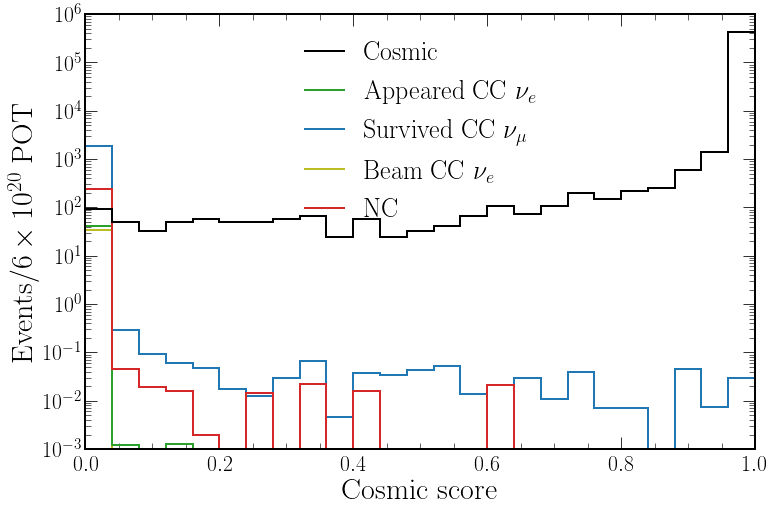

In [53]:
chipsnet.plotting.plot_cosmic_values(events, "final_cosmic", save_path+"final_cosmic_outputs")

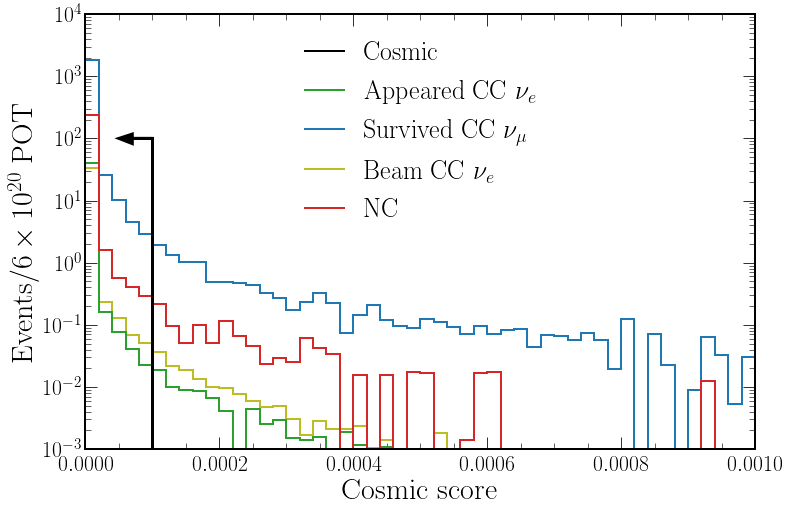

In [54]:
chipsnet.plotting.plot_cosmic_values(events, "final_cosmic", save_path+"final_cosmic_zoomed_outputs", zoom=True)

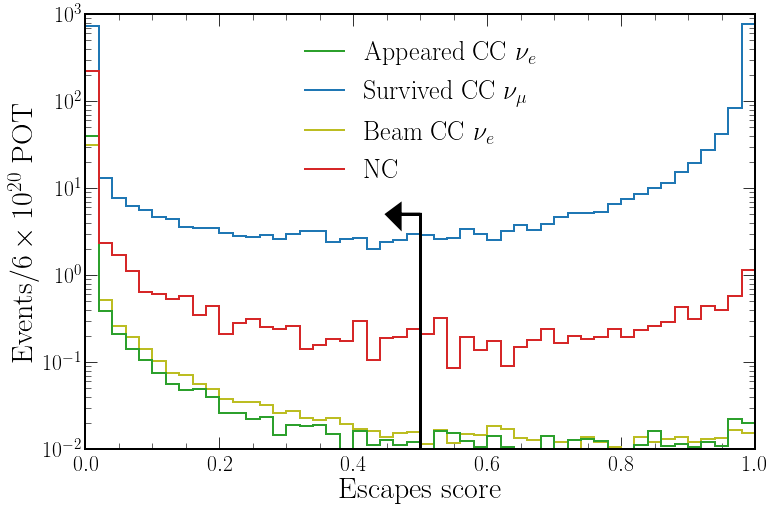

In [55]:
chipsnet.plotting.plot_escapes_values(events, "final_cosmic", save_path+"final_escapes_outputs")

In [56]:
esc_labels = ["Contained", "Escaped"]
nuel_esc_report = classification_report(
    events[events["t_comb_cat"] == 0]["t_escapes"],
    events[events["t_comb_cat"] == 0]["escapes_cut"],
    labels=[x for x in range(2)],
    target_names=esc_labels,
    sample_weight=events[events["t_comb_cat"] == 0]["w"],
    zero_division=0
)
numu_esc_report = classification_report(
    events[events["t_comb_cat"] == 1]["t_escapes"],
    events[events["t_comb_cat"] == 1]["escapes_cut"],
    labels=[x for x in range(2)],
    target_names=esc_labels,
    sample_weight=events[events["t_comb_cat"] == 1]["w"],
    zero_division=0
)
print(nuel_esc_report)
print(numu_esc_report)

              precision    recall  f1-score   support

   Contained       0.99      0.99      0.99 78.60574470348195
     Escaped       0.02      0.08      0.03 0.17935234458087257

   micro avg       0.98      0.99      0.99 78.78509704806282
   macro avg       0.51      0.53      0.51 78.78509704806282
weighted avg       0.99      0.99      0.99 78.78509704806282

              precision    recall  f1-score   support

   Contained       0.95      0.97      0.96 896.912704000871
     Escaped       0.98      0.96      0.97 1145.7450205417922

   micro avg       0.96      0.97      0.97 2042.6577245426633
   macro avg       0.96      0.97      0.96 2042.6577245426633
weighted avg       0.96      0.97      0.97 2042.6577245426633



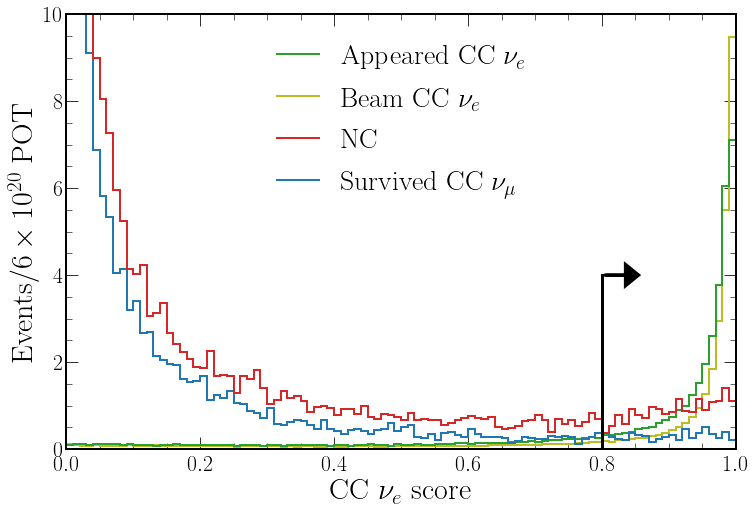

In [57]:
chipsnet.plotting.plot_combined_values(events, 0, "final_beam_", save_path+"final_beam_nuel_outputs", cut=0.80)

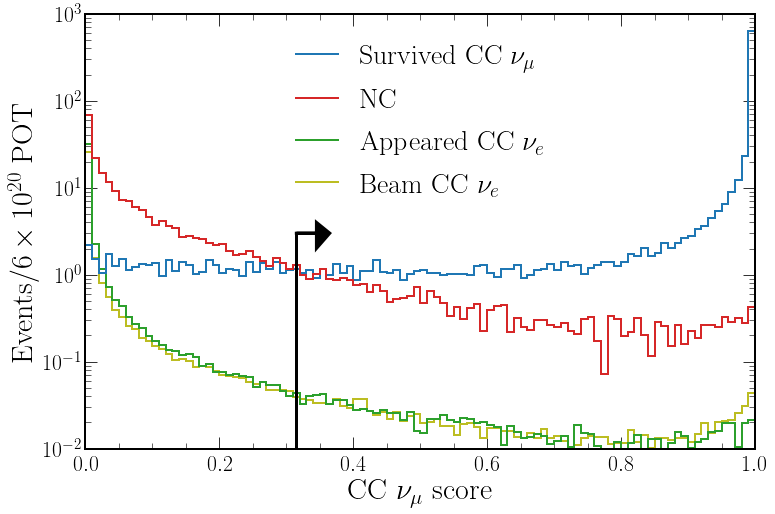

In [58]:
chipsnet.plotting.plot_combined_values(events, 1, "final_beam_", save_path+"final_beam_numu_outputs", cut=0.315)

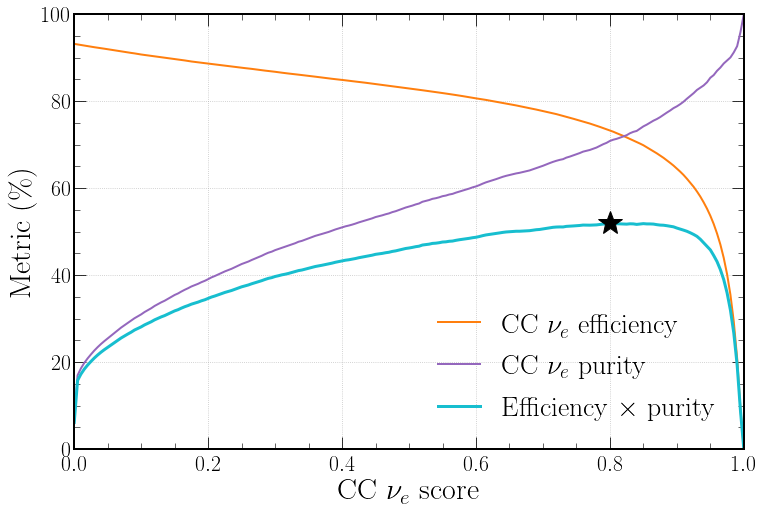

In [59]:
chipsnet.plotting.plot_eff_curves([outputs[0]], 0, save_path+"final_nuel_eff_curves", leg_pos="lower right", marker=(0.8, 51.9))

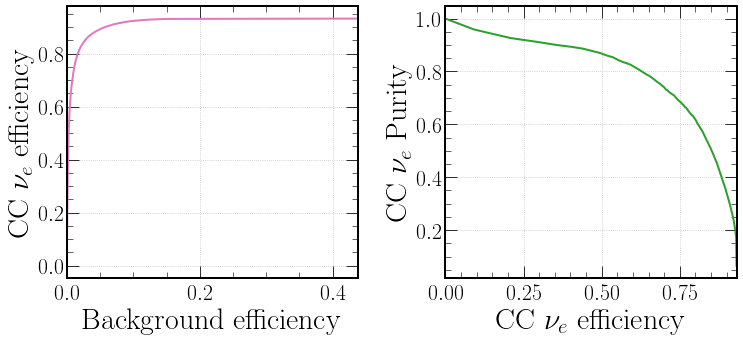

In [60]:
chipsnet.plotting.plot_comp_curves([outputs[0]], 0, save_path+"final_nuel_comp_curves")

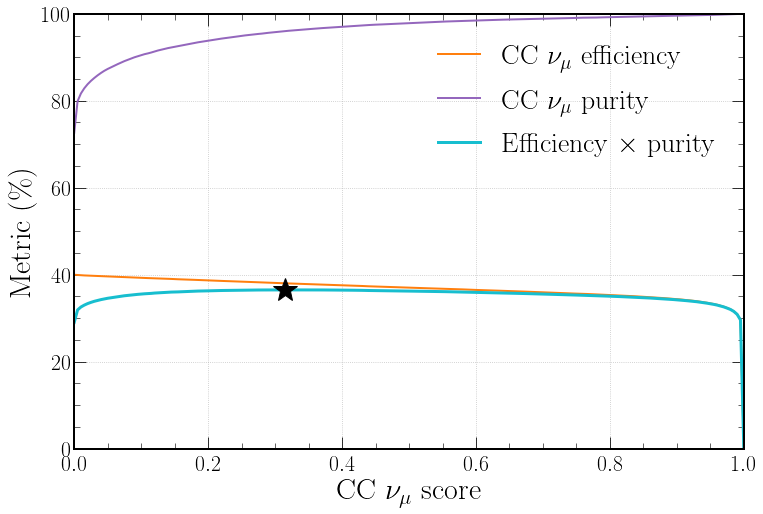

In [61]:
chipsnet.plotting.plot_eff_curves([outputs[0]], 1, save_path+"final_numu_eff_curves", full=True, marker=(0.315, 36.5))

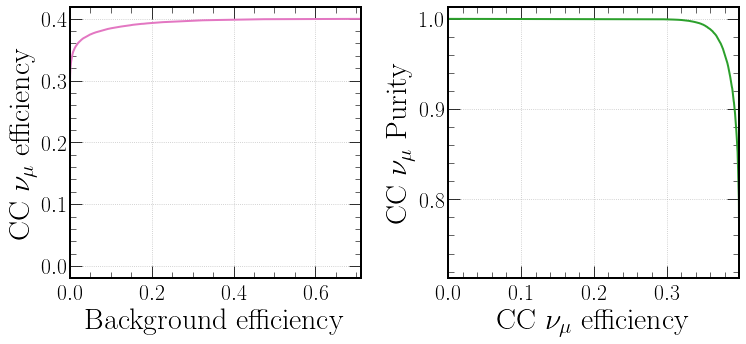

In [62]:
chipsnet.plotting.plot_comp_curves([outputs[0]], 1, save_path+"final_numu_comp_curves")

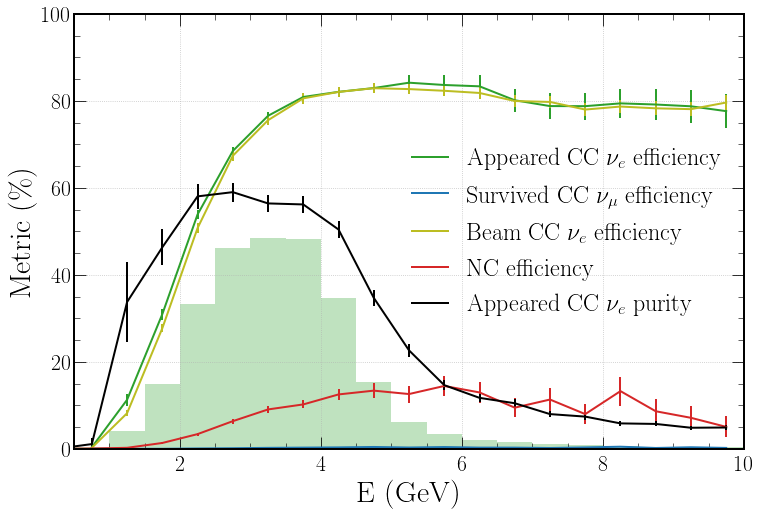

In [68]:
chipsnet.plotting.plot_nuel_hists([outputs[0]], events, save_path+"final_nuel_hists")

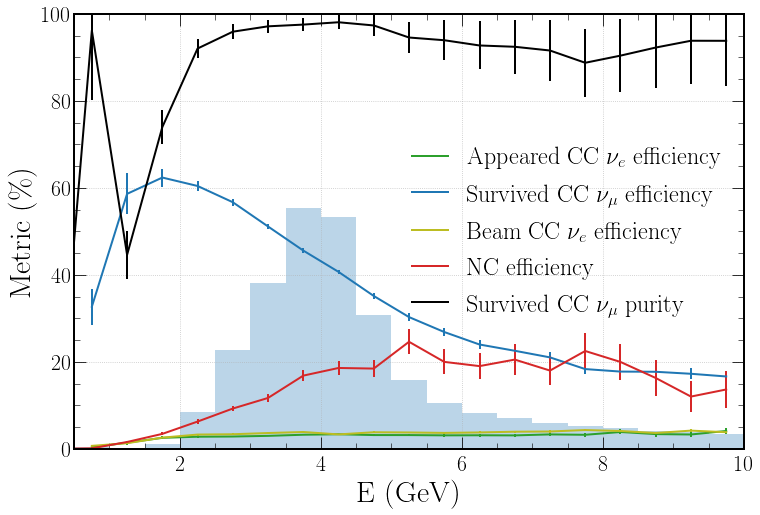

In [69]:
chipsnet.plotting.plot_numu_hists([outputs[0]], events, save_path+"final_numu_hists")

In [70]:
# Get the errors on the efficiencies and purities
chipsnet.utils.calculate_eff_pur(events, outputs[0]["max_fom_cuts_0"], e_bins=1, e_range=(0, 30000), prefix="final_beam_", energy="t_nu_energy")

{'fom_effs': [[(array([0.70881866]), array([0.00361082])),
   (array([0.76281338]), array([0.00280178])),
   (array([0.0029731]), array([0.00015855])),
   (array([0.05055334]), array([0.00163779]))],
  [(array([0.70881866]), array([0.00361082])),
   (array([0.76281338]), array([0.00280178])),
   (array([0.0029731]), array([0.00015855])),
   (array([0.05055334]), array([0.00163779]))],
  [(array([0.03003602]), array([0.00058119])),
   (array([0.03910518]), array([0.00049464])),
   (array([0.38022755]), array([0.00200331])),
   (array([0.08391149]), array([0.00213725]))],
  [(array([0.11805713]), array([0.00140219])),
   (array([0.08849502]), array([0.00075766])),
   (array([0.0238338]), array([0.00043525])),
   (array([0.54722829]), array([0.0063628]))]],
 'fom_purs': [(array([0.38291269]), array([0.00524345])),
  (array([0.32706965]), array([0.00439542])),
  (array([0.96053683]), array([0.00658238])),
  (array([0.76976486]), array([0.01118066]))]}

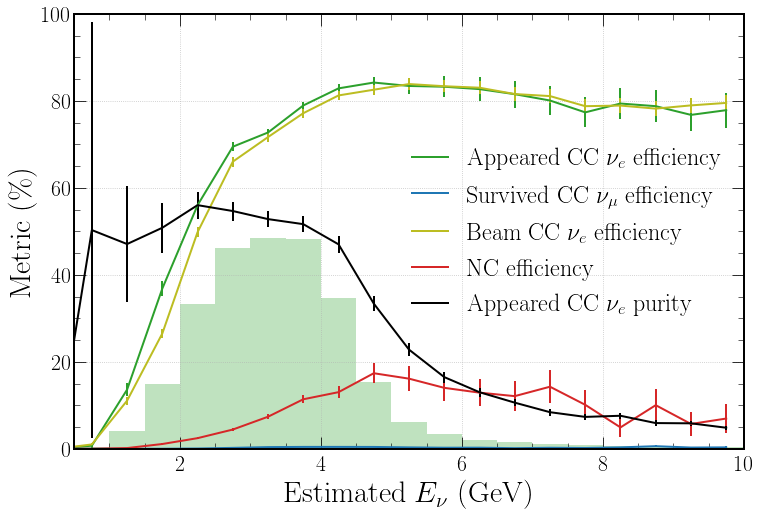

In [71]:
nuel_out = chipsnet.utils.calculate_eff_pur(events, outputs[0]["max_fom_cuts_0"], prefix="final_beam_", energy="pred_nuel_energy")
chipsnet.plotting.plot_nuel_hists([nuel_out], events, save_path+"final_nuel_hists_reco", energy=r"Estimated $E_{\nu}$ (GeV)")

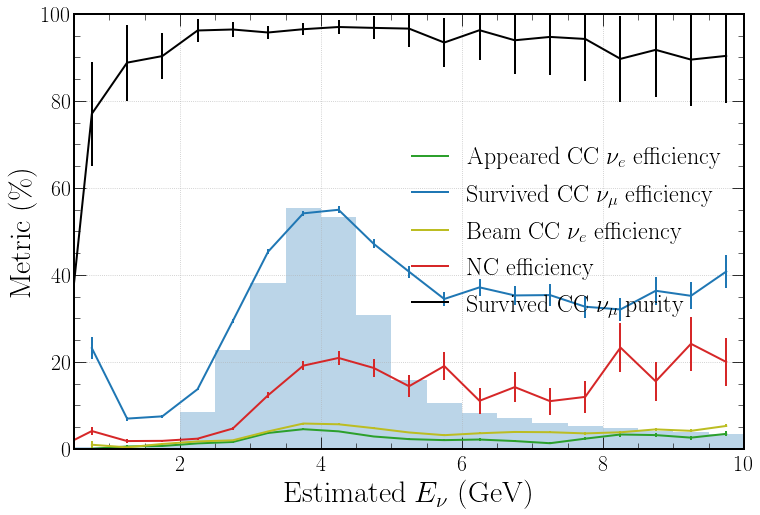

In [72]:
numu_out = chipsnet.utils.calculate_eff_pur(events, outputs[0]["max_fom_cuts_0"], prefix="final_beam_", energy="pred_numu_energy")
chipsnet.plotting.plot_numu_hists([numu_out], events, save_path+"final_numu_hists_reco", energy=r"Estimated $E_{\nu}$ (GeV)")

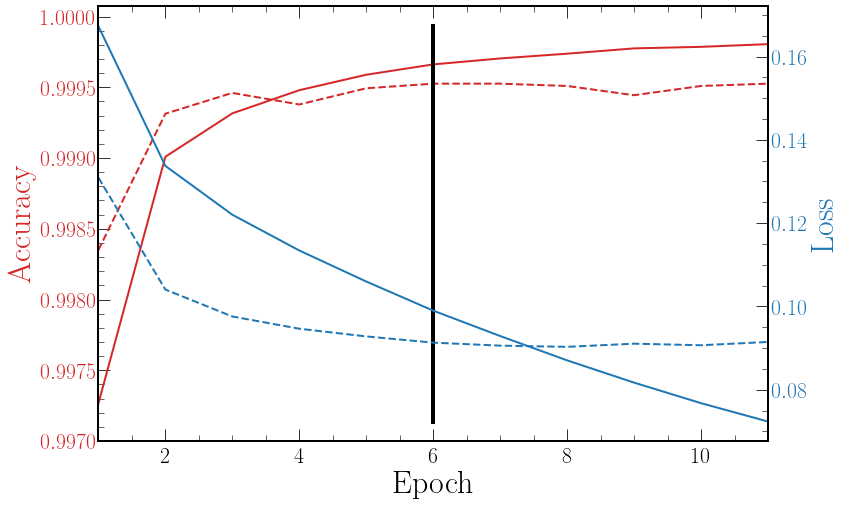

In [73]:
chipsnet.plotting.plot_history(config, "final_cosmic", save_path+"final_cosmic_history", key="t_cosmic_cat_accuracy", label="Accuracy")

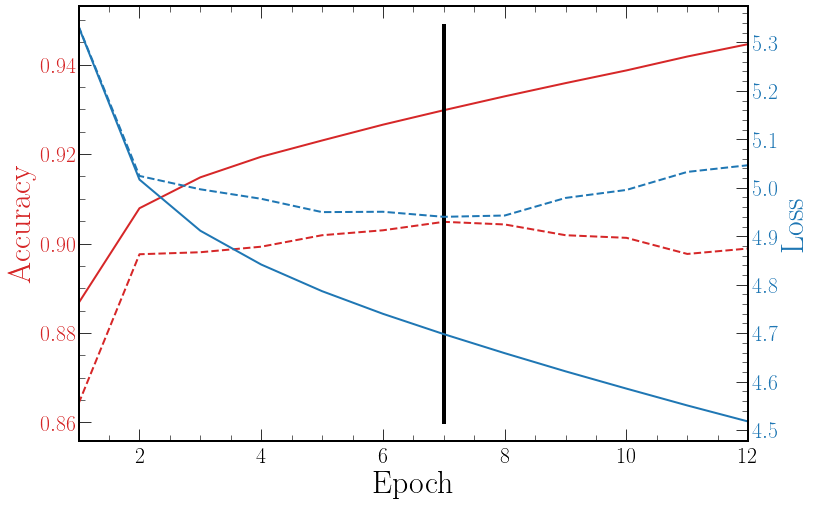

In [74]:
chipsnet.plotting.plot_history(config, "final_beam", save_path+"final_beam_history", key="t_comb_cat_accuracy", label="Accuracy")

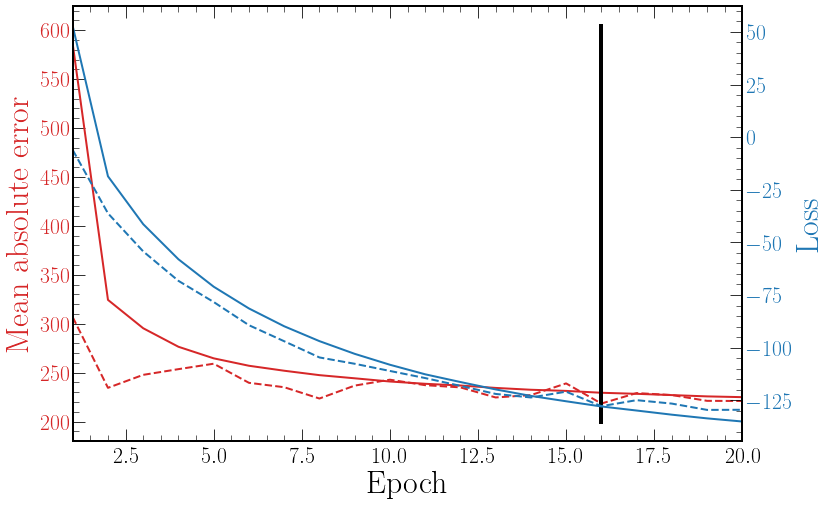

In [75]:
chipsnet.plotting.plot_history(config, "final_nuel_ccqel_e", save_path+"final_energy_history", key="t_nu_energy_mae", type="min", label="Mean absolute error")

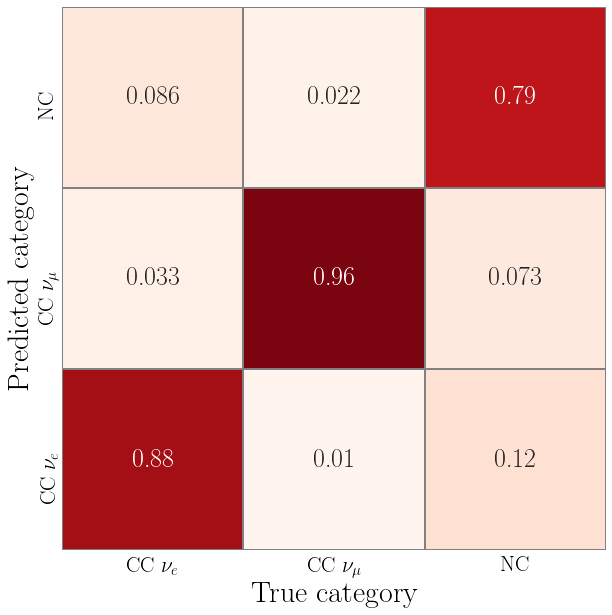

In [76]:
plt.figure(figsize=(10, 10))
labels = [r"CC $\nu_{e}$", r"CC $\nu_{\mu}$", r"NC"]
sns.heatmap(
    outputs[0]["comb_matrix"].drop(0, axis=0).drop(3, axis=1),
    annot=True, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=labels,
    yticklabels=labels[::-1],
    cbar=False,
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
plt.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
plt.xlabel('True category', fontsize = 30)
plt.ylabel('Predicted category', fontsize = 30)
chipsnet.plotting.save(save_path + "final_comb_cat_confusion")

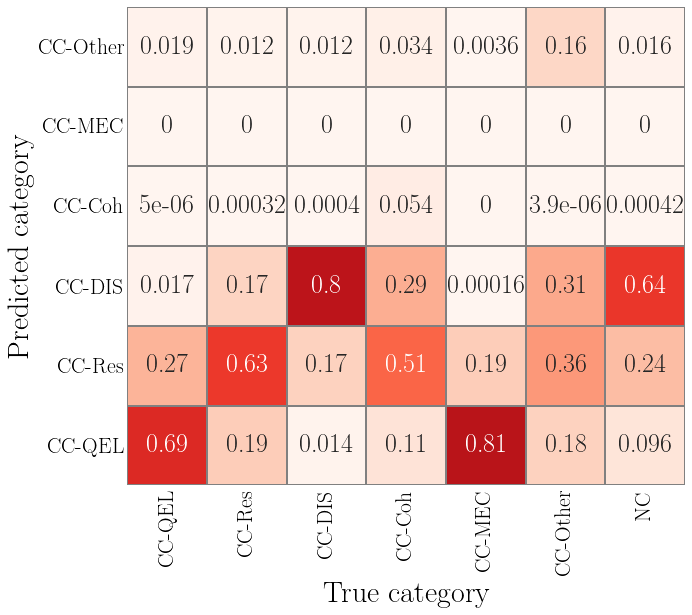

In [77]:
events["final_beam_t_cc_cat_class"] = events.apply(
    chipsnet.utils.classify,
    axis=1,
    args=(chipsnet.data.get_map("t_cc_cat")["categories"], "final_beam_pred_t_cc_cat_"),
)
cc_matrix = confusion_matrix(
    events[events["nuel_selected"] | events["numu_selected"]]["t_cc_cat"],
    events[events["nuel_selected"] | events["numu_selected"]]["final_beam_t_cc_cat_class"],
    labels=[x for x in range(7)],
    sample_weight=events[events["nuel_selected"] | events["numu_selected"]]["w"],
    normalize="true",
)
labels = ["CC-QEL", "CC-Res", "CC-DIS", "CC-Coh", "CC-MEC", "CC-Other", "NC"]
cc_matrix = np.rot90(cc_matrix, 1)
cc_matrix = pd.DataFrame(cc_matrix)
cc_matrix = cc_matrix.drop([0])
plt.figure(figsize=(10, 10))
sns.heatmap(
    cc_matrix,
    annot=True, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=labels,
    yticklabels=labels[:6][::-1],
    cbar=False,
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
plt.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
plt.xlabel('True category', fontsize = 30)
plt.ylabel('Predicted category', fontsize = 30)
chipsnet.plotting.save(save_path + "final_cc_cat_confusion")

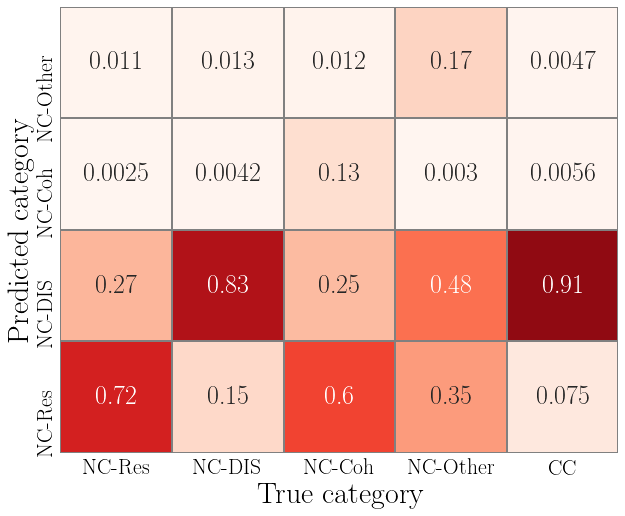

In [78]:
events["final_beam_t_nc_cat_class"] = events.apply(
    chipsnet.utils.classify,
    axis=1,
    args=(chipsnet.data.get_map("t_nc_cat")["categories"], "final_beam_pred_t_nc_cat_"),
)
nc_matrix = confusion_matrix(
    events[events["nc_selected"]]["t_nc_cat"],
    events[events["nc_selected"]]["final_beam_t_nc_cat_class"],
    labels=[x for x in range(5)],
    sample_weight=events[events["nc_selected"]]["w"],
    normalize="true",
)
labels = ["NC-Res", "NC-DIS", "NC-Coh", "NC-Other", "CC"]
nc_matrix = np.rot90(nc_matrix, 1)
nc_matrix = pd.DataFrame(nc_matrix)
nc_matrix = nc_matrix.drop([0])
plt.figure(figsize=(10, 10))
sns.heatmap(
    nc_matrix,
    annot=True, 
    vmin=0.0, 
    vmax=1.0,
    xticklabels=labels,
    yticklabels=labels[:4][::-1],
    cbar=False,
    square=True,
    linewidth=1,
    linecolor="grey",
    cmap="Reds")
plt.tick_params(axis='both', which='both',
                bottom=False, top=False, left=False, right=False)
plt.xlabel('True category', fontsize = 30)
plt.ylabel('Predicted category', fontsize = 30)
chipsnet.plotting.save(save_path + "final_nc_cat_confusion")

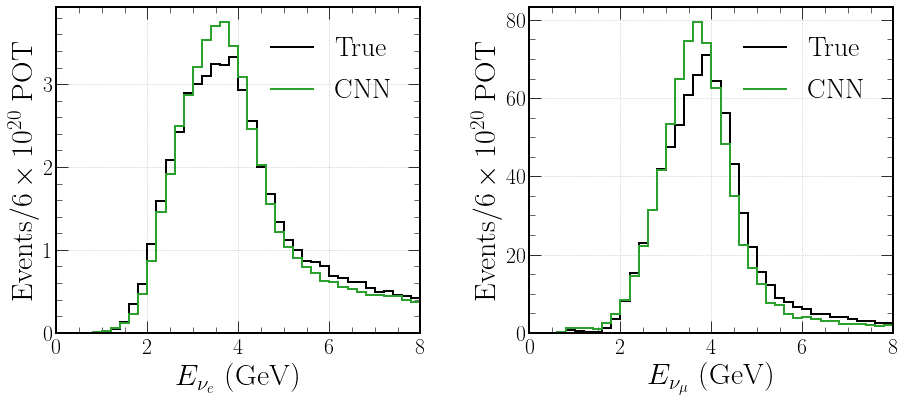

In [79]:
e_range = (0,8)
e_bins = 40

fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})
axs[0].hist(
    events[(events["t_comb_cat"] == 0) & (events["nuel_selected"] == 1)]["t_nu_energy"]/1000,
    range=e_range,
    bins=e_bins,
    color="black",
    linewidth=2,
    weights=events[(events["t_comb_cat"] == 0) & (events["nuel_selected"] == 1)]["w"],
    histtype="step"
)
axs[0].hist(
    events[(events["t_comb_cat"] == 0) & (events["nuel_selected"] == 1)]["pred_nuel_energy"]/1000,
    range=e_range,
    bins=e_bins,
    color="tab:green",
    linewidth=2,
    weights=events[(events["t_comb_cat"] == 0) & (events["nuel_selected"] == 1)]["w"],
    histtype="step"
)

axs[1].hist(
    events[(events["t_comb_cat"] == 1) & (events["numu_selected"] == 1)]["t_nu_energy"]/1000,
    range=e_range,
    bins=e_bins,
    color="black",
    linewidth=2,
    weights=events[(events["t_comb_cat"] == 1) & (events["numu_selected"] == 1)]["w"],
    histtype="step"
)
axs[1].hist(
    events[(events["t_comb_cat"] == 1) & (events["numu_selected"] == 1)]["pred_numu_energy"]/1000,
    range=e_range,
    bins=e_bins,
    color="tab:green",
    linewidth=2,
    weights=events[(events["t_comb_cat"] == 1) & (events["numu_selected"] == 1)]["w"],
    histtype="step"
)

axs[0].grid()
axs[1].grid()
axs[0].set_xlabel(r"$E_{\nu_{e}}$ (GeV)", fontsize=30)
axs[0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
axs[1].set_xlabel(r"$E_{\nu_{\mu}}$ (GeV)", fontsize=30)
axs[1].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
true = Line2D([0], [0], color="black", linewidth=2, label=r"True")
reco = Line2D([0], [0], color="tab:green", linewidth=2, label=r"CNN")
axs[0].legend(handles=[true, reco], loc="upper right", fontsize=28)
axs[1].legend(handles=[true, reco], loc="upper right", fontsize=28)

chipsnet.plotting.save(save_path + "final_energy_dists")

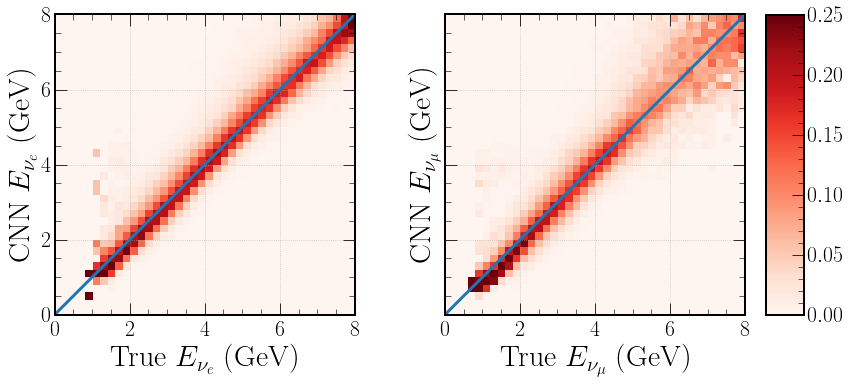

In [80]:
e_range = [[0, 8], [0, 8]]
extent = (0, 8, 0, 8)
e_bins = [40, 40]
fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})
plt.setp(axs, xticks=[0, 2, 4, 6, 8], yticks=[0, 2, 4, 6, 8])

nuel_cc_h = np.histogram2d(events[(events["nuel_selected"] == 1) & (events["t_comb_cat"] == 0)]["t_nu_energy"]/1000,
                              events[(events["nuel_selected"] == 1) & (events["t_comb_cat"] == 0)]["final_nuel_cc_e_pred_t_nu_energy"]/1000,
                              range=e_range, bins=e_bins)[0]
nuel_cc_h = np.nan_to_num(nuel_cc_h/nuel_cc_h.sum(axis=0,keepdims=1))
chipsnet.utils.print_globes_smearing(nuel_cc_h, "nuel_cc")

numu_cc_h = np.histogram2d(events[(events["numu_selected"] == 1) & (events["t_comb_cat"] == 1)]["t_nu_energy"]/1000,
                              events[(events["numu_selected"] == 1) & (events["t_comb_cat"] == 1)]["final_numu_cc_e_pred_t_nu_energy"]/1000,
                              range=e_range, bins=e_bins)[0]
numu_cc_h = np.nan_to_num(numu_cc_h/numu_cc_h.sum(axis=0,keepdims=1))
chipsnet.utils.print_globes_smearing(numu_cc_h, "numu_cc")

axs[0].imshow(nuel_cc_h, cmap="Reds", origin="lower", extent=extent, vmin=0, vmax=0.25)
axs[0].grid()
axs[0].label_outer()
axs[0].plot([0, 8], [0, 8], "k-", lw=3, color="tab:blue")
axs[0].set_xlabel(r"True $E_{\nu_{e}}$ (GeV)", fontsize=30)
axs[0].set_ylabel(r"CNN $E_{\nu_{e}}$ (GeV)", fontsize=30)

neg = axs[1].imshow(numu_cc_h, cmap="Reds", origin="lower", extent=extent, vmin=0, vmax=0.25)
axs[1].grid()
axs[1].label_outer()
axs[1].plot([0, 8], [0, 8], "k-", lw=3, color="tab:blue")
axs[1].set_xlabel(r"True $E_{\nu_{\mu}}$ (GeV)", fontsize=30)
axs[1].set_ylabel(r"CNN $E_{\nu_{\mu}}$ (GeV)", fontsize=30)

fig.colorbar(neg, ax=axs, shrink=0.92, aspect=8, pad=0.025)

chipsnet.plotting.save(save_path + "final_energy_2d")

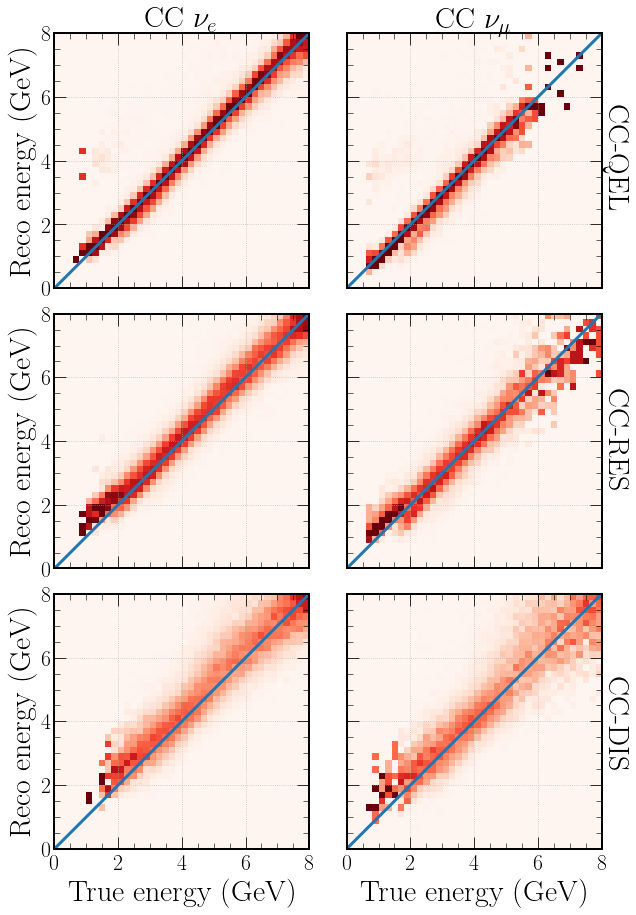

In [81]:
e_range = [[0, 8], [0, 8]]
extent = (0, 8, 0, 8)
e_bins = [40, 40]
fig, axs = plt.subplots(3, 2, figsize=(10, 15), gridspec_kw={"hspace": 0.1, "wspace": 0.1})
plt.setp(axs, xticks=[0, 2, 4, 6, 8], yticks=[0, 2, 4, 6, 8])

nuel_ccqel_h = np.histogram2d(events[(events["nuel_selected"] == 1) & ((events["t_all_cat"] == 0) | (events["t_all_cat"] == 4))]["t_nu_energy"]/1000,
                              events[(events["nuel_selected"] == 1) & ((events["t_all_cat"] == 0) | (events["t_all_cat"] == 4))]["pred_nuel_energy"]/1000,
                              range=e_range, bins=e_bins)[0]
nuel_ccqel_h = np.nan_to_num(nuel_ccqel_h/nuel_ccqel_h.sum(axis=0,keepdims=1))
chipsnet.utils.print_globes_smearing(nuel_ccqel_h, "nuel_ccqel")
axs[0, 0].imshow(nuel_ccqel_h, cmap="Reds", origin="lower", extent=extent, vmin=0, vmax=0.25)
axs[0, 0].grid()
axs[0, 0].label_outer()
axs[0, 0].set_ylabel(r"Reco energy (GeV)", fontsize=30)
axs[0, 0].set_title(r"CC $\nu_{e}$", fontsize=30)
axs[0, 0].plot([0, 8], [0, 8], "k-", lw=3, color="tab:blue")
nuel_ccres_h = np.histogram2d(events[(events["nuel_selected"] == 1) & (events["t_all_cat"] == 1)]["t_nu_energy"]/1000,
                              events[(events["nuel_selected"] == 1) & (events["t_all_cat"] == 1)]["pred_nuel_energy"]/1000,
                              range=e_range, bins=e_bins)[0]
nuel_ccres_h = np.nan_to_num(nuel_ccres_h/nuel_ccres_h.sum(axis=0,keepdims=1))
chipsnet.utils.print_globes_smearing(nuel_ccres_h, "nuel_ccres")
axs[1, 0].imshow(nuel_ccres_h, cmap="Reds", origin="lower", extent=extent, vmin=0, vmax=0.25)
axs[1, 0].grid()
axs[1, 0].label_outer()
axs[1, 0].set_ylabel(r"Reco energy (GeV)", fontsize=30)
axs[1, 0].plot([0, 8], [0, 8], "k-", lw=3, color="tab:blue")
nuel_ccdis_h = np.histogram2d(events[(events["nuel_selected"] == 1) & (events["t_all_cat"] == 2)]["t_nu_energy"]/1000,
                              events[(events["nuel_selected"] == 1) & (events["t_all_cat"] == 2)]["pred_nuel_energy"]/1000,
                              range=e_range, bins=e_bins)[0]
nuel_ccdis_h = np.nan_to_num(nuel_ccdis_h/nuel_ccdis_h.sum(axis=0,keepdims=1))
chipsnet.utils.print_globes_smearing(nuel_ccdis_h, "nuel_ccdis")
axs[2, 0].imshow(nuel_ccdis_h, cmap="Reds", origin="lower", extent=extent, vmin=0, vmax=0.25)
axs[2, 0].grid()
axs[2, 0].label_outer()
axs[2, 0].set_ylabel(r"Reco energy (GeV)", fontsize=30)
axs[2, 0].set_xlabel(r"True energy (GeV)", fontsize=30)
axs[2, 0].plot([0, 8], [0, 8], "k-", lw=3, color="tab:blue")
numu_ccqel_h = np.histogram2d(events[(events["numu_selected"] == 1) & ((events["t_all_cat"] == 6) | (events["t_all_cat"] == 10))]["t_nu_energy"]/1000,
                              events[(events["numu_selected"] == 1) & ((events["t_all_cat"] == 6) | (events["t_all_cat"] == 10))]["pred_numu_energy"]/1000,
                              range=e_range, bins=e_bins)[0]
numu_ccqel_h = np.nan_to_num(numu_ccqel_h/numu_ccqel_h.sum(axis=0,keepdims=1))
chipsnet.utils.print_globes_smearing(numu_ccqel_h, "numu_ccqel")
axs[0, 1].imshow(numu_ccqel_h, cmap="Reds", origin="lower", extent=extent, vmin=0, vmax=0.25)
axs[0, 1].grid()
axs[0, 1].label_outer()
axs[0, 1].set_title(r"CC $\nu_{\mu}$", fontsize=30)
axs[0, 1].text(8.050, 2.600, "CC-QEL", rotation=-90, fontsize=30)
axs[0, 1].plot([0, 8], [0, 8], "k-", lw=3, color="tab:blue")
numu_ccres_h = np.histogram2d(events[(events["numu_selected"] == 1) & (events["t_all_cat"] == 7)]["t_nu_energy"]/1000,
                              events[(events["numu_selected"] == 1) & (events["t_all_cat"] == 7)]["pred_numu_energy"]/1000,
                              range=e_range, bins=e_bins)[0]
numu_ccres_h = np.nan_to_num(numu_ccres_h/numu_ccres_h.sum(axis=0,keepdims=1))
chipsnet.utils.print_globes_smearing(numu_ccres_h, "numu_ccres")
axs[1, 1].imshow(numu_ccres_h, cmap="Reds", origin="lower", extent=extent, vmin=0, vmax=0.25)
axs[1, 1].grid()
axs[1, 1].label_outer()
axs[1, 1].text(8.050, 2.600, "CC-RES", rotation=-90, fontsize=30)
axs[1, 1].plot([0, 8], [0, 8], "k-", lw=3, color="tab:blue")
numu_ccdis_h = np.histogram2d(events[(events["numu_selected"] == 1) & (events["t_all_cat"] == 8)]["t_nu_energy"]/1000,
                              events[(events["numu_selected"] == 1) & (events["t_all_cat"] == 8)]["pred_numu_energy"]/1000,
                              range=e_range, bins=e_bins)[0]
numu_ccdis_h = np.nan_to_num(numu_ccdis_h/numu_ccdis_h.sum(axis=0,keepdims=1))
chipsnet.utils.print_globes_smearing(numu_ccdis_h, "numu_ccdis")
axs[2, 1].imshow(numu_ccdis_h, cmap="Reds", origin="lower", extent=extent, vmin=0, vmax=0.25)
axs[2, 1].grid()
axs[2, 1].label_outer()
axs[2, 1].text(8.050, 2.600, "CC-DIS", rotation=-90, fontsize=30)
axs[2, 1].plot([0, 8], [0, 8], "k-", lw=3, color="tab:blue")
axs[2, 1].set_xlabel(r"True energy (GeV)", fontsize=30)
chipsnet.plotting.save(save_path + "final_energy_2d_cats")

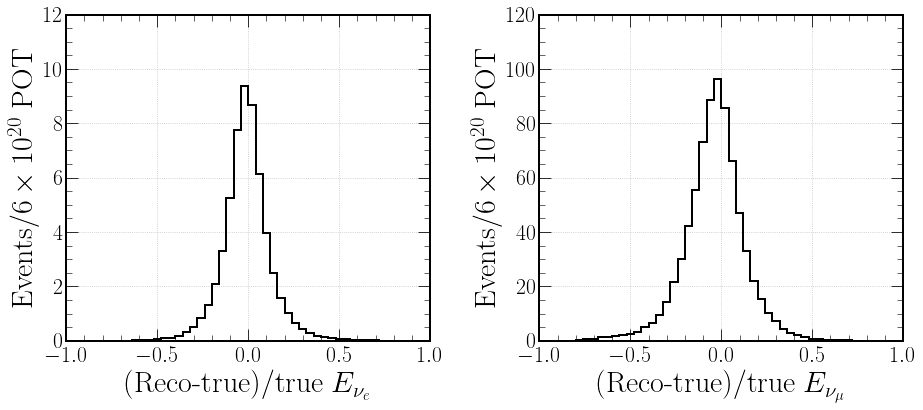

In [83]:
e_range = (-1,1)
e_bins = 50

fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})
#axs[0].hist(
#    events[(events["nuel_selected"] == 1)]["frac_nuel_energy"],
#    range=e_range,
#    bins=e_bins,
#    color="black",
#    linewidth=2,
#    weights=events[(events["nuel_selected"] == 1)]["w"],
#    histtype="step"
#)
axs[0].hist(
    events[(events["t_comb_cat"] == 0) & (events["nuel_selected"] == 1)]["frac_nuel_energy"],
    range=e_range,
    bins=e_bins,
    color="black",
    linewidth=2,
    weights=events[(events["t_comb_cat"] == 0) & (events["nuel_selected"] == 1)]["w"],
    histtype="step"
)

#axs[1].hist(
#    events[(events["numu_selected"] == 1)]["frac_numu_energy"],
#    range=e_range,
#    bins=e_bins,
#    color="black",
#    linewidth=2,
#    weights=events[(events["numu_selected"] == 1)]["w"],
#    histtype="step"
#)
axs[1].hist(
    events[(events["t_comb_cat"] == 1) & (events["numu_selected"] == 1)]["frac_numu_energy"],
    range=e_range,
    bins=e_bins,
    color="black",
    linewidth=2,
    weights=events[(events["t_comb_cat"] == 1) & (events["numu_selected"] == 1)]["w"],
    histtype="step"
)

axs[0].set_ylim(0, 12)
axs[1].set_ylim(0, 120)
axs[0].grid()
axs[1].grid()
axs[0].set_xlabel(r"(Reco-true)/true $E_{\nu_{e}}$", fontsize=30)
axs[0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
axs[1].set_xlabel(r"(Reco-true)/true $E_{\nu_{\mu}}$", fontsize=30)
axs[1].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
#sel = Line2D([0], [0], color="black", linewidth=2, label=r"All")
#cat = Line2D([0], [0], color="tab:green", linewidth=2, label=r"Signal")
#axs[0].legend(handles=[sel, cat], loc="upper right", fontsize=24)
#axs[1].legend(handles=[sel, cat], loc="upper right", fontsize=24)

chipsnet.plotting.save(save_path + "final_energy_frac")

In [110]:
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["nuel_selected"] == 1)], fit_name="frac_nuel_energy", bin_size=8000
)
print("Nuel all: {}, {}".format(stds[0][0], 2.335*stds[0][0]))
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["nuel_selected"] == 1) & (events["t_comb_cat"] == 0)], fit_name="frac_nuel_energy", bin_size=8000
)
print("Nuel signal: {}, {}".format(stds[0][0], 2.335*stds[0][0]))
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["numu_selected"] == 1)], fit_name="frac_numu_energy", bin_size=8000
)
print("Numu all: {}, {}".format(stds[0][0], 2.335*stds[0][0]))
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["numu_selected"] == 1) & (events["t_comb_cat"] == 1)], fit_name="frac_numu_energy", bin_size=8000
)
print("Numu signal: {}, {}".format(stds[0][0], 2.335*stds[0][0]))

Nuel all: 0.1291728141357642, 0.3016185210070094
Nuel signal: 0.10258491523164984, 0.23953577706590237
Numu all: 0.12874117009295574, 0.30061063216705164
Numu signal: 0.1263154743104756, 0.2949466325149605


In [111]:
from scipy.signal import chirp, find_peaks, peak_widths
n, bins = np.histogram(
    events[(events["nuel_selected"] == 1) & (events["t_comb_cat"] == 0)]["frac_nuel_energy"], 
    bins=50, 
    range=(-1, 1), 
    weights=events[(events["nuel_selected"] == 1) & (events["t_comb_cat"] == 0)]["w"]
)
peaks, _ = find_peaks(n)
results_half = peak_widths(n, peaks, rel_height=0.5)
print(peaks)
print(results_half[0]/25)

[24 42 45]
[0.19844728 0.0341182  0.02215965]


In [112]:
n, bins = np.histogram(
    events[(events["numu_selected"] == 1) & (events["t_comb_cat"] == 1)]["frac_nuel_energy"], 
    bins=50, 
    range=(-1, 1), 
    weights=events[(events["numu_selected"] == 1) & (events["t_comb_cat"] == 1)]["w"]
)
peaks, _ = find_peaks(n)
results_half = peak_widths(n, peaks, rel_height=0.5)
print(peaks)
print(results_half[0]/25)

[23 25 44 46]
[0.02293831 0.43530408 0.03942729 0.02709591]


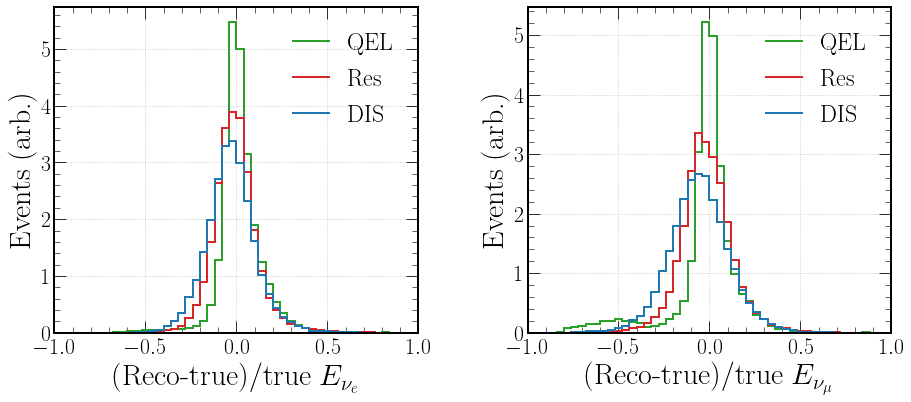

In [83]:
e_range = (-1,1)
e_bins = 50

fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})
axs[0].hist(
    events[((events["t_all_cat"] == 0) | (events["t_all_cat"] == 4)) & (events["nuel_selected"] == 1)]["frac_nuel_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:green",
    linewidth=2,
    weights=events[((events["t_all_cat"] == 0) | (events["t_all_cat"] == 4)) & (events["nuel_selected"] == 1)]["w"],
    histtype="step",
    density=True
)
axs[0].hist(
    events[(events["t_all_cat"] == 1) & (events["nuel_selected"] == 1)]["frac_nuel_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:red",
    linewidth=2,
    weights=events[(events["t_all_cat"] == 1) & (events["nuel_selected"] == 1)]["w"],
    histtype="step",
    density=True
)
axs[0].hist(
    events[(events["t_all_cat"] == 2) & (events["nuel_selected"] == 1)]["frac_nuel_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:blue",
    linewidth=2,
    weights=events[(events["t_all_cat"] == 2) & (events["nuel_selected"] == 1)]["w"],
    histtype="step",
    density=True
)
axs[1].hist(
    events[((events["t_all_cat"] == 6) | (events["t_all_cat"] == 10)) & (events["numu_selected"] == 1)]["frac_numu_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:green",
    linewidth=2,
    weights=events[((events["t_all_cat"] == 6) | (events["t_all_cat"] == 10)) & (events["numu_selected"] == 1)]["w"],
    histtype="step",
    density=True
)
axs[1].hist(
    events[(events["t_all_cat"] == 7) & (events["numu_selected"] == 1)]["frac_numu_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:red",
    linewidth=2,
    weights=events[(events["t_all_cat"] == 7) & (events["numu_selected"] == 1)]["w"],
    histtype="step",
    density=True
)
axs[1].hist(
    events[(events["t_all_cat"] == 8) & (events["numu_selected"] == 1)]["frac_numu_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:blue",
    linewidth=2,
    weights=events[(events["t_all_cat"] == 8) & (events["numu_selected"] == 1)]["w"],
    histtype="step",
    density=True
)

axs[0].grid()
axs[1].grid()
axs[0].set_xlabel(r"(Reco-true)/true $E_{\nu_{e}}$", fontsize=30)
axs[0].set_ylabel(r"Events (arb.)", fontsize=30)
axs[1].set_xlabel(r"(Reco-true)/true $E_{\nu_{\mu}}$", fontsize=30)
axs[1].set_ylabel(r"Events (arb.)", fontsize=30)
qel = Line2D([0], [0], color="tab:green", linewidth=2, label=r"QEL")
res = Line2D([0], [0], color="tab:red", linewidth=2, label=r"Res")
dis = Line2D([0], [0], color="tab:blue", linewidth=2, label=r"DIS")
axs[0].legend(handles=[qel, res, dis], loc="upper right", fontsize=24)
axs[1].legend(handles=[qel, res, dis], loc="upper right", fontsize=24)

chipsnet.plotting.save(save_path + "final_energy_frac_split")

In [113]:
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[((events["t_all_cat"] == 0) | (events["t_all_cat"] == 4)) & (events["nuel_selected"] == 1)], fit_name="frac_nuel_energy", bin_size=8000
)
print("Nuel qel: {}, {}".format(stds[0][0], 2.335*stds[0][0]))
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["t_all_cat"] == 1) & (events["nuel_selected"] == 1)], fit_name="frac_nuel_energy", bin_size=8000
)
print("Nuel res: {}, {}".format(stds[0][0], 2.335*stds[0][0]))
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["t_all_cat"] == 2) & (events["nuel_selected"] == 1)], fit_name="frac_nuel_energy", bin_size=8000
)
print("Nuel dis: {}, {}".format(stds[0][0], 2.335*stds[0][0]))
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[((events["t_all_cat"] == 6) | (events["t_all_cat"] == 10)) & (events["numu_selected"] == 1)], fit_name="frac_numu_energy", bin_size=8000
)
print("Numu qel: {}, {}".format(stds[0][0], 2.335*stds[0][0]))
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["t_all_cat"] == 7) & (events["numu_selected"] == 1)], fit_name="frac_numu_energy", bin_size=8000
)
print("Numu res: {}, {}".format(stds[0][0], 2.335*stds[0][0]))
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["t_all_cat"] == 8) & (events["numu_selected"] == 1)], fit_name="frac_numu_energy", bin_size=8000
)
print("Numu dis: {}, {}".format(stds[0][0], 2.335*stds[0][0]))

Nuel qel: 0.07107179184941763, 0.16595263396839016
Nuel res: 0.10348754729965867, 0.241643422944703
Nuel dis: 0.13623531456982452, 0.31810945952054026
Numu qel: 0.06169057531463265, 0.14404749335966724
Numu res: 0.11674861121712062, 0.27260800719197664
Numu dis: 0.1492617196729497, 0.34852611543633755


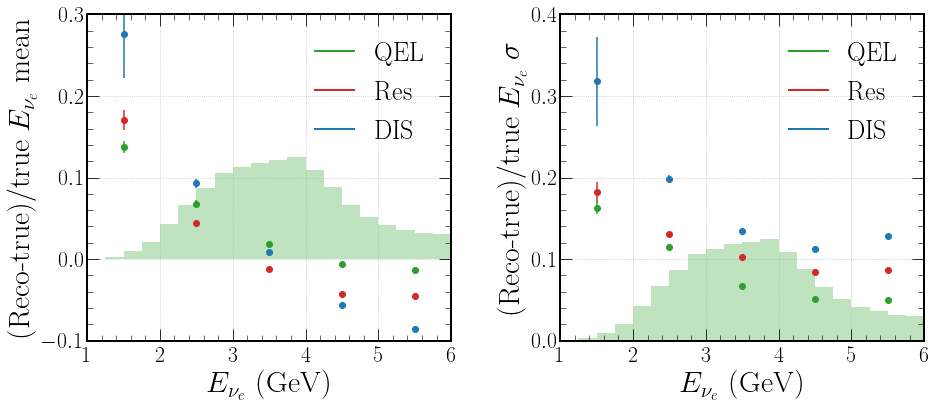

In [85]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["nuel_selected"] == 1) & (events["t_all_cat"] == 0)], fit_name="frac_nuel_energy"
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:green", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:green", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["nuel_selected"] == 1) & (events["t_all_cat"] == 1)], fit_name="frac_nuel_energy"
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:red", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:red", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["nuel_selected"] == 1) & (events["t_all_cat"] == 2)], fit_name="frac_nuel_energy"
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:blue", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:blue", linestyle="", marker="o")

axs[0].hist(
    events[(events["nuel_selected"] == 1) & (events["t_comb_cat"] == 0)]["t_nu_energy"]/1000,
    range=(1, 8),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=events[(events["nuel_selected"] == 1) & (events["t_comb_cat"] == 0)]["w"] * 0.03,
)
axs[1].hist(
    events[(events["nuel_selected"] == 1) & (events["t_comb_cat"] == 0)]["t_nu_energy"]/1000,
    range=(1, 8),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=events[(events["nuel_selected"] == 1) & (events["t_comb_cat"] == 0)]["w"] * 0.03,
)

axs[0].set_ylim(-0.1, 0.3)
axs[0].set_xlim(1, 6)
axs[1].set_ylim(0.0, 0.4)
axs[1].set_xlim(1, 6)
axs[0].grid()
axs[1].grid()
axs[0].set_xlabel(r"$E_{\nu_{e}}$ (GeV)", fontsize=30)
axs[0].set_ylabel(r"(Reco-true)/true $E_{\nu_{e}}$ mean", fontsize=30)
axs[1].set_xlabel(r"$E_{\nu_{e}}$ (GeV)", fontsize=30)
axs[1].set_ylabel(r"(Reco-true)/true $E_{\nu_{e}}$ $\sigma$", fontsize=30)
qel = Line2D([0], [0], color="tab:green", linewidth=2, label=r"QEL")
res = Line2D([0], [0], color="tab:red", linewidth=2, label=r"Res")
dis = Line2D([0], [0], color="tab:blue", linewidth=2, label=r"DIS")
axs[0].legend(handles=[qel, res, dis], loc="upper right", fontsize=26)
axs[1].legend(handles=[qel, res, dis], loc="upper right", fontsize=26)

chipsnet.plotting.save(save_path + "final_energy_nuel")

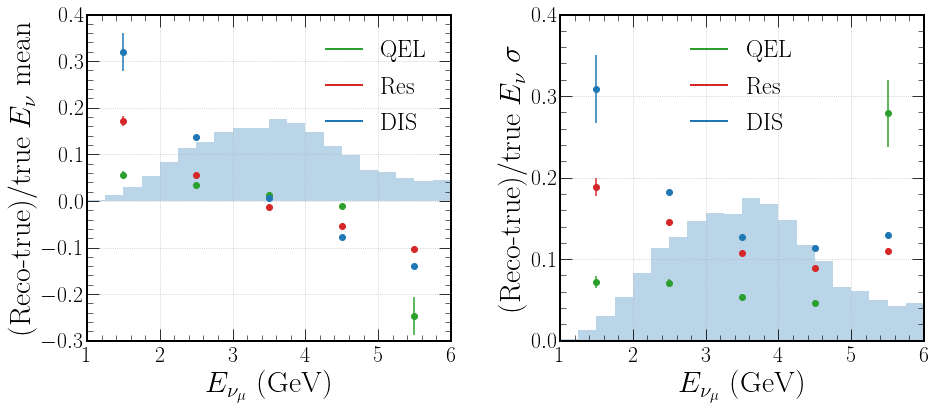

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["numu_selected"] == 1) & (events["t_all_cat"] == 6)], fit_name="frac_numu_energy"
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:green", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:green", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["numu_selected"] == 1) & (events["t_all_cat"] == 7)], fit_name="frac_numu_energy"
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:red", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:red", linestyle="", marker="o")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    events[(events["numu_selected"] == 1) & (events["t_all_cat"] == 8)], fit_name="frac_numu_energy"
)
axs[0].errorbar(e_list/1000, means[0], yerr=means[1], color="tab:blue", linestyle="", marker="o")
axs[1].errorbar(e_list/1000, stds[0], yerr=stds[1], color="tab:blue", linestyle="", marker="o")

axs[0].hist(
    events[(events["numu_selected"] == 1) & (events["t_comb_cat"] == 0)]["t_nu_energy"]/1000,
    range=(1, 8),
    bins=28,
    color="tab:blue",
    density=False,
    alpha=0.3,
    weights=events[(events["numu_selected"] == 1) & (events["t_comb_cat"] == 0)]["w"] * 1.0,
)
axs[1].hist(
    events[(events["numu_selected"] == 1) & (events["t_comb_cat"] == 0)]["t_nu_energy"]/1000,
    range=(1, 8),
    bins=28,
    color="tab:blue",
    density=False,
    alpha=0.3,
    weights=events[(events["numu_selected"] == 1) & (events["t_comb_cat"] == 0)]["w"] * 1.0,
)

axs[0].set_ylim(-0.3, 0.4)
axs[0].set_xlim(1, 6)
axs[1].set_ylim(0.0, 0.4)
axs[1].set_xlim(1, 6)
axs[0].grid()
axs[1].grid()
axs[0].set_xlabel(r"$E_{\nu_{\mu}}$ (GeV)", fontsize=30)
axs[0].set_ylabel(r"(Reco-true)/true $E_{\nu}$ mean", fontsize=30)
axs[1].set_xlabel(r"$E_{\nu_{\mu}}$ (GeV)", fontsize=30)
axs[1].set_ylabel(r"(Reco-true)/true $E_{\nu}$ $\sigma$", fontsize=30)
qel = Line2D([0], [0], color="tab:green", linewidth=2, label=r"QEL")
res = Line2D([0], [0], color="tab:red", linewidth=2, label=r"Res")
dis = Line2D([0], [0], color="tab:blue", linewidth=2, label=r"DIS")
axs[0].legend(handles=[qel, res, dis], loc="upper right", fontsize=24)
axs[1].legend(handles=[qel, res, dis], loc="upper center", fontsize=24)

chipsnet.plotting.save(save_path + "final_energy_numu")

In [ ]:
e_range=(0, 10)
e_bins=25
bin_range=(e_range[1]-e_range[0])/e_bins

# Zero cp
numu_ev = events[(events["t_comb_cat"]==1) & (events["t_sample_type"]==0) & (events["nuel_selected"])].reset_index(drop=True)
nuel_o_ev = events[(events["t_comb_cat"]==0) & (events["t_sample_type"]==1) & (events["nuel_selected"])].reset_index(drop=True)
nuel_b_ev = events[(events["t_comb_cat"]==0) & (events["t_sample_type"]==0) & (events["nuel_selected"])].reset_index(drop=True)
nc_ev = events[(events["t_comb_cat"]==2) & (events["t_sample_type"]==0) & (events["nuel_selected"])].reset_index(drop=True)

numu_h, numu_err, c, e = chipsnet.utils.extended_hist(numu_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=numu_ev["w"])
nuel_o_h, nuel_o_err, c, e = chipsnet.utils.extended_hist(nuel_o_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nuel_o_ev["w"])
nuel_b_h, nuel_b_err, c, e = chipsnet.utils.extended_hist(nuel_b_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nuel_b_ev["w"])
nc_h, nc_err, c, e = chipsnet.utils.extended_hist(nc_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nc_ev["w"])
err = numu_err+nuel_o_err+nuel_b_err+nc_err

fig, axs = plt.subplots(1, 1, figsize=(12, 8))
bins = np.arange(0+(bin_range/2), 10+(bin_range/2), bin_range)
axs.bar(bins, numu_h, bin_range, color="tab:blue")
axs.bar(bins, nc_h, bin_range, bottom=numu_h, color="tab:red")
axs.bar(bins, nuel_b_h, bin_range, bottom=nc_h+numu_h, color="tab:olive")
axs.bar(bins, nuel_o_h, bin_range, yerr=err, bottom=nuel_b_h+nc_h+numu_h, color="tab:green", alpha=0)

left,right = e[:-1],e[1:]
x = np.array([left,right]).T.flatten()
y = np.array([(numu_h+nuel_o_h+nuel_b_h+nc_h),(numu_h+nuel_o_h+nuel_b_h+nc_h)]).T.flatten()
y_minus = np.array([(numu_h+nuel_o_h+nuel_b_h+nc_h)*1.2,(numu_h+nuel_o_h+nuel_b_h+nc_h)*1.2]).T.flatten()
plt.plot(x,y, color="black", linewidth=2, linestyle="solid")

# Plus cp
plus_events = chipsnet.utils.apply_weights(events, osc_file_name=matter_osc_file_plus_f)
numu_ev = plus_events[(plus_events["t_comb_cat"]==1) & (plus_events["t_sample_type"]==0) & (plus_events["nuel_selected"])].reset_index(drop=True)
nuel_o_ev = plus_events[(plus_events["t_comb_cat"]==0) & (plus_events["t_sample_type"]==1) & (plus_events["nuel_selected"])].reset_index(drop=True)
nuel_b_ev = plus_events[(plus_events["t_comb_cat"]==0) & (plus_events["t_sample_type"]==0) & (plus_events["nuel_selected"])].reset_index(drop=True)
nc_ev = plus_events[(plus_events["t_comb_cat"]==2) & (plus_events["t_sample_type"]==0) & (plus_events["nuel_selected"])].reset_index(drop=True)

numu_h, numu_err, c, e = chipsnet.utils.extended_hist(numu_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=numu_ev["w"])
nuel_o_h, nuel_o_err, c, e = chipsnet.utils.extended_hist(nuel_o_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nuel_o_ev["w"])
nuel_b_h, nuel_b_err, c, e = chipsnet.utils.extended_hist(nuel_b_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nuel_b_ev["w"])
nc_h, nc_err, c, e = chipsnet.utils.extended_hist(nc_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nc_ev["w"])
y_plus = np.array([(numu_h+nuel_o_h+nuel_b_h+nc_h),(numu_h+nuel_o_h+nuel_b_h+nc_h)]).T.flatten()
plt.plot(x,y_plus, color="black", linewidth=2, linestyle="dashed")

# Minus cp
minus_events = chipsnet.utils.apply_weights(events, osc_file_name=matter_osc_file_minus_f)
numu_ev = minus_events[(minus_events["t_comb_cat"]==1) & (minus_events["t_sample_type"]==0) & (minus_events["nuel_selected"])].reset_index(drop=True)
nuel_o_ev = minus_events[(minus_events["t_comb_cat"]==0) & (minus_events["t_sample_type"]==1) & (minus_events["nuel_selected"])].reset_index(drop=True)
nuel_b_ev = minus_events[(minus_events["t_comb_cat"]==0) & (minus_events["t_sample_type"]==0) & (minus_events["nuel_selected"])].reset_index(drop=True)
nc_ev = minus_events[(minus_events["t_comb_cat"]==2) & (minus_events["t_sample_type"]==0) & (minus_events["nuel_selected"])].reset_index(drop=True)

numu_h, numu_err, c, e = chipsnet.utils.extended_hist(numu_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=numu_ev["w"])
nuel_o_h, nuel_o_err, c, e = chipsnet.utils.extended_hist(nuel_o_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nuel_o_ev["w"])
nuel_b_h, nuel_b_err, c, e = chipsnet.utils.extended_hist(nuel_b_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nuel_b_ev["w"])
nc_h, nc_err, c, e = chipsnet.utils.extended_hist(nc_ev["pred_nuel_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nc_ev["w"])
y_minus = np.array([(numu_h+nuel_o_h+nuel_b_h+nc_h),(numu_h+nuel_o_h+nuel_b_h+nc_h)]).T.flatten()
plt.plot(x,y_minus, color="black", linewidth=2, linestyle="dotted")

nuel = Patch(facecolor="tab:olive", label=r"Beam CC $\nu_{e}$")
osc_nuel = Line2D([0], [0], color="black", linewidth=2, linestyle="solid", label=r"Signal CC $\nu_{e}$ ($\delta_{CP}=0$)")
numu = Patch(facecolor="tab:blue", label=r"Survived CC $\nu_{\mu}$")
nc = Patch(facecolor="tab:red", label=r"NC")
minus = Line2D([0], [0], color="black", linewidth=2, linestyle="dotted", label=r"Signal CC $\nu_{e}$ ($\delta_{CP}=-\pi/2$)")
plus = Line2D([0], [0], color="black", linewidth=2, linestyle="dashed", label=r"Signal CC $\nu_{e}$ ($\delta_{CP}=+\pi/2$)")
axs.legend(handles=[osc_nuel, minus, plus, nuel, nc, numu], loc="upper right", fontsize=24)
axs.set_xlabel(r"CNN reconstructed $E_{\nu_{e}}$ (GeV)", fontsize=30)
axs.set_ylabel(r"Events/$6\times10^{20}$ POT/400 MeV", fontsize=30)
chipsnet.plotting.save(save_path + "final_nuel_passed_energy_dist")

In [ ]:
e_range=(0, 10)
e_bins=25
bin_range=(e_range[1]-e_range[0])/e_bins
escapes_cut=0.5

numu_ev = events[(events["t_comb_cat"]==1) & (events["t_sample_type"]==0) & (events["numu_selected"])].reset_index(drop=True)
nuel_o_ev = events[(events["t_comb_cat"]==0) & (events["t_sample_type"]==1) & (events["numu_selected"])].reset_index(drop=True)
nuel_b_ev = events[(events["t_comb_cat"]==0) & (events["t_sample_type"]==0) & (events["numu_selected"])].reset_index(drop=True)
nc_ev = events[(events["t_comb_cat"]==2) & (events["t_sample_type"]==0) & (events["numu_selected"])].reset_index(drop=True)

numu_h, numu_err, c, e = chipsnet.utils.extended_hist(numu_ev["pred_numu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=numu_ev["w"])
nuel_o_h, nuel_o_err, c, e = chipsnet.utils.extended_hist(nuel_o_ev["pred_numu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nuel_o_ev["w"])
nuel_b_h, nuel_b_err, c, e = chipsnet.utils.extended_hist(nuel_b_ev["pred_numu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nuel_b_ev["w"])
nc_h, nc_err, c, e = chipsnet.utils.extended_hist(nc_ev["pred_numu_energy"]/1000, e_range[0], e_range[1], e_bins, weights=nc_ev["w"])
err = numu_err+nuel_o_err+nuel_b_err+nc_err

fig, axs = plt.subplots(1, 1, figsize=(12, 8))
bins = np.arange(0+(bin_range/2), 10+(bin_range/2), bin_range)
axs.bar(bins, nuel_b_h, bin_range, color="tab:olive")
axs.bar(bins, nuel_o_h, bin_range, bottom=nuel_b_h, color="tab:green")
axs.bar(bins, nc_h, bin_range, bottom=nuel_o_h+nuel_b_h, color="tab:red")
axs.bar(bins, numu_h, bin_range, yerr=err, bottom=nc_h+nuel_o_h+nuel_b_h, color="tab:blue")
axs.set_yscale("log")
axs.set_ylim(10e-3, 10e2)

nuel = Patch(facecolor="tab:olive", label=r"Beam CC $\nu_{e}$")
osc_nuel = Patch(facecolor="tab:green", label=r"Appeared CC $\nu_{e}$")
numu = Patch(facecolor="tab:blue", label=r"Signal CC $\nu_{\mu}$")
nc = Patch(facecolor="tab:red", label=r"NC")
axs.legend(handles=[numu, nc, osc_nuel, nuel], loc="upper right", fontsize=26)
axs.set_xlabel(r"CNN reconstructed $E_{\nu_{\mu}}$ (GeV)", fontsize=30)
axs.set_ylabel(r"Events/$6\times10^{20}$ POT/400 MeV", fontsize=30)
chipsnet.plotting.save(save_path + "final_numu_passed_energy_dist")

In [ ]:
out_80 = chipsnet.utils.calculate_eff_pur(events[(events["frac_energy"] >= 0.8) & (events["frac_energy"] < 1.0)], outputs[0]["max_fom_cuts_0"], prefix="final_beam_")
out_60 = chipsnet.utils.calculate_eff_pur(events[(events["frac_energy"] >= 0.6) & (events["frac_energy"] < 0.8)], outputs[0]["max_fom_cuts_0"], prefix="final_beam_")
out_40 = chipsnet.utils.calculate_eff_pur(events[(events["frac_energy"] >= 0.4) & (events["frac_energy"] < 0.6)], outputs[0]["max_fom_cuts_0"], prefix="final_beam_")
out_20 = chipsnet.utils.calculate_eff_pur(events[(events["frac_energy"] >= 0.2) & (events["frac_energy"] < 0.4)], outputs[0]["max_fom_cuts_0"], prefix="final_beam_")

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
bins = np.arange(0.25, 10.25, 0.5)
axs.errorbar(
    bins,
    out_80["fom_effs"][0][0][0],
    yerr=out_80["fom_effs"][0][0][1],
    color="tab:green"
)
axs.errorbar(
    bins,
    out_60["fom_effs"][0][0][0],
    yerr=out_60["fom_effs"][0][0][1],
    color="tab:blue"
)
axs.errorbar(
    bins,
    out_40["fom_effs"][0][0][0],
    yerr=out_40["fom_effs"][0][0][1],
    color="tab:red"
)
axs.errorbar(
    bins,
    out_20["fom_effs"][0][0][0],
    yerr=out_20["fom_effs"][0][0][1],
    color="tab:pink"
)
axs.set_xlabel(r"$E_{\nu_{e}}$ (GeV)", fontsize=30)
axs.set_ylabel(r"$\nu_{e}$ efficiency", fontsize=30)
axs.set_ylim([0, 1])
leg_80 = Line2D([0], [0], color="tab:green", linewidth=2, label=r"80\% - 100\%")
leg_60 = Line2D([0], [0], color="tab:blue", linewidth=2, label=r"60\% - 80\%")
leg_40 = Line2D([0], [0], color="tab:red", linewidth=2, label=r"40\% - 60\%")
leg_20 = Line2D([0], [0], color="tab:pink", linewidth=2, label=r"20\% - 40\%")
axs.legend(handles=[leg_80, leg_60, leg_40, leg_20], loc="lower right", fontsize=28)
axs.set_xlim(0, 10)
axs.grid()
chipsnet.plotting.save(save_path + "final_frac_energy_eff")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.3})
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 0)], fit_name="final_nuel_ccqel_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:green")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 0)], fit_name="final_nuel_cc_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:green", linestyle="dotted")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 1)], fit_name="final_nuel_ccres_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:red")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 1)], fit_name="final_nuel_cc_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:red", linestyle="dotted")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 2)], fit_name="final_nuel_ccdis_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:blue")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 2)], fit_name="final_nuel_cc_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:blue", linestyle="dotted")
axs[0].set_ylabel(r"(True-reco)/true $E_{\nu_{e}}$", fontsize=30)
axs[0].set_xlabel(r"$E_{\nu_{e}}$ (GeV)", fontsize=30)
axs[0].set_ylim(0.0, 0.3)
axs[0].grid()
axs[0].hist(
    events[(events["cut"] == 0) & (events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1)]["t_nu_energy"]/1000,
    range=(1, 8),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=events[(events["cut"] == 0) & (events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1)]["w"] * 0.05,
)

e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 0)], fit_name="final_nuel_ccqel_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:green")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 0)], fit_name="final_nuel_cc_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:green", linestyle="dotted")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 1)], fit_name="final_nuel_ccres_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:red")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 1)], fit_name="final_nuel_cc_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:red", linestyle="dotted")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 2)], fit_name="final_nuel_ccdis_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:blue")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 2)], fit_name="final_nuel_cc_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:blue", linestyle="dotted")
axs[1].set_ylabel(r"(True-reco)/true $E_{e}$", fontsize=30)
axs[1].set_xlabel(r"$E_{e}$ (GeV)", fontsize=30)
axs[1].set_ylim(0.0, 0.3)
axs[1].grid()
axs[1].hist(
    events[(events["cut"] == 0) & (events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1)]["t_lep_energy"]/1000,
    range=(1, 8),
    bins=28,
    color="tab:green",
    density=False,
    alpha=0.3,
    weights=events[(events["cut"] == 0) & (events["t_comb_cat"] == 0) & (events["t_sample_type"] == 1)]["w"] * 0.05,
)

seperate = Line2D([0], [0], color="black", linewidth=2, linestyle="solid", label=r"Seperate")
combined = Line2D([0], [0], color="black", linewidth=2, linestyle="dotted", label="Combined")
axs[1].legend(handles=[seperate, combined], loc="upper right", fontsize=28)

chipsnet.plotting.save(save_path + "final_energy_split_nuel_frac_vs_e")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={"hspace": 0.1, "wspace": 0.3})
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 6)], fit_name="final_numu_ccqel_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:green")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 6)], fit_name="final_numu_cc_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:green", linestyle="dotted")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 7)], fit_name="final_numu_ccres_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:red")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 7)], fit_name="final_numu_cc_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:red", linestyle="dotted")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 8)], fit_name="final_numu_ccdis_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:blue")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 8)], fit_name="final_numu_cc_e_frac_nu_energy")
axs[0].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:blue", linestyle="dotted")
axs[0].set_ylabel(r"(True-reco)/true $E_{\nu_{\mu}}$", fontsize=30)
axs[0].set_xlabel(r"$E_{\nu_{\mu}}$ energy (GeV)", fontsize=30)
axs[0].set_ylim(0.0, 0.4)
axs[0].grid()
axs[0].hist(
    events[(events["cut"] == 0) & (events["t_comb_cat"] == 1)]["t_nu_energy"]/1000,
    range=(1, 8),
    bins=28,
    color="tab:blue",
    density=False,
    alpha=0.3,
    weights=events[(events["cut"] == 0) & (events["t_comb_cat"] == 1)]["w"] * 0.003,
)

e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 6)], fit_name="final_numu_ccqel_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:green")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 6)], fit_name="final_numu_cc_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:green", linestyle="dotted")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 7)], fit_name="final_numu_ccres_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:red")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 7)], fit_name="final_numu_cc_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:red", linestyle="dotted")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 8)], fit_name="final_numu_ccdis_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:blue")
e_list, mean_list, std_list = chipsnet.utils.frac_e_vs_par(events[(events["cut"] == 0) & (events["t_all_cat"] == 8)], fit_name="final_numu_cc_e_frac_lep_energy",
                                                          par="t_lep_energy")
axs[1].errorbar(e_list/1000, std_list[0], yerr=std_list[1], color="tab:blue", linestyle="dotted")
axs[1].set_ylabel(r"(True-reco)/true $E_{\mu}$", fontsize=30)
axs[1].set_xlabel(r"$E_{\mu}$ energy (GeV)", fontsize=30)
axs[1].set_ylim(0.0, 0.4)
axs[1].grid()
axs[1].hist(
    events[(events["cut"] == 0) & (events["t_comb_cat"] == 1)]["t_lep_energy"]/1000,
    range=(1, 8),
    bins=28,
    color="tab:blue",
    density=False,
    alpha=0.3,
    weights=events[(events["cut"] == 0) & (events["t_comb_cat"] == 1)]["w"] * 0.004,
)

seperate = Line2D([0], [0], color="black", linewidth=2, linestyle="solid", label=r"Seperate")
combined = Line2D([0], [0], color="black", linewidth=2, linestyle="dotted", label="Combined")
axs[1].legend(handles=[seperate, combined], loc="upper left", fontsize=24)

chipsnet.plotting.save(save_path + "final_energy_split_numu_frac_vs_e")

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), gridspec_kw={'hspace': 0.3})

scale = old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["w"].sum()/events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["w"].sum()
hist = axs[0, 0].hist(
    (old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["r_vtx_x"]-old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["t_vtx_x"]), 
    weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["w"]/scale, 
    range=(-3, 3), bins=40, color='tab:red', histtype='step', linewidth=2
)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
old_reco = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"Old Reco ({0:.3f})".format(abs(pars[2])))
hist = axs[0, 0].hist(
    events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["final_nuel_ccqel_e_pred_t_vtx_x"]/100-events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["t_vtx_x"]/100,
    weights=events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["w"],
    range=(-3, 3), bins=40, color='tab:green', histtype='step', linewidth=2
)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
cvn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"CNN ({0:.3f})".format(abs(pars[2])))
axs[0, 0].set_xlabel('Reco-true x-position (m)', fontsize=30)
axs[0, 0].set_ylabel(r"$\nu_{e}$ events/$6\times10^{20}$ POT", fontsize=30)
axs[0, 0].grid()
axs[0, 0].legend(handles=[cvn, old_reco], loc="upper center", fontsize=24)
axs[0, 0].set_ylim(0, 3)

hist = axs[0, 1].hist(
    (old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["r_vtx_y"]-old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["t_vtx_y"]), 
    weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["w"]/scale, 
    range=(-2, 2), bins=40, color='tab:red', histtype='step', linewidth=2
)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
old_reco = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"Old Reco ({0:.3f})".format(abs(pars[2])))
hist = axs[0, 1].hist(
    events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["final_nuel_ccqel_e_pred_t_vtx_y"]/100-events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["t_vtx_y"]/100,
    weights=events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["w"],
    range=(-2, 2), bins=40, color='tab:green', histtype='step', linewidth=2
)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
cvn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"CNN ({0:.3f})".format(abs(pars[2])))
axs[0, 1].set_xlabel('Reco-true y-position (m)', fontsize=30)
axs[0, 1].grid()
axs[0, 1].legend(handles=[cvn, old_reco], loc="upper center", fontsize=24)
axs[0, 1].set_ylim(0, 3)

hist = axs[1, 0].hist(
    (old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["r_vtx_z"]-old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["t_vtx_z"]), 
    weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["w"]/scale, 
    range=(-2, 2), bins=40, color='tab:red', histtype='step', linewidth=2
)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
old_reco = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"Old Reco ({0:.3f})".format(abs(pars[2])))
hist = axs[1, 0].hist(
    events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["final_nuel_ccqel_e_pred_t_vtx_z"]/100-events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["t_vtx_z"]/100,
    weights=events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["w"],
    range=(-2, 2), bins=40, color='tab:green', histtype='step', linewidth=2
)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
cvn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"CNN ({0:.3f})".format(abs(pars[2])))
axs[1, 0].set_xlabel('Reco-true z-position (m)', fontsize=30)
axs[1, 0].set_ylabel(r"$\nu_{e}$ events/$6\times10^{20}$ POT", fontsize=30)
axs[1, 0].grid()
axs[1, 0].legend(handles=[cvn, old_reco], loc="upper center", fontsize=24)
axs[1, 0].set_ylim(0, 3.5)

hist = axs[1, 1].hist(
    (old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["r_vtx_t"]-old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["t_vtx_t"]), 
    weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11)]["w"]/scale, 
    range=(-10, 10), bins=40, color='tab:red', histtype='step', linewidth=2
)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
old_reco = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"Old Reco ({0:.3f})".format(abs(pars[2])))
hist = axs[1, 1].hist(
    events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["final_nuel_ccqel_e_pred_t_vtx_t"]-events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["t_vtx_t"],
    weights=events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["w"],
    range=(-10, 10), bins=40, color='tab:green', histtype='step', linewidth=2
)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
cvn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"CNN ({0:.3f})".format(abs(pars[2])))
axs[1, 1].set_xlabel('Reco-true time (ns)', fontsize=30)
axs[1, 1].grid()
axs[1, 1].legend(handles=[cvn, old_reco], loc="upper center", fontsize=24)
axs[1, 1].set_ylim(0, 3.5)

chipsnet.plotting.save(save_path + "final_vertex_nuel_res_comparison")

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15), gridspec_kw={'hspace': 0.3})

scale = old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13)]["w"].sum()/events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["w"].sum()
hist = axs[0, 0].hist(
    (old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13)]["r_vtx_x"]-old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13)]["t_vtx_x"]), 
    weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13)]["w"]/scale, 
    range=(-3, 3), bins=40, color='tab:red', histtype='step', linewidth=2
)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
old_reco = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"Old Reco ({0:.3f})".format(abs(pars[2])))
hist = axs[0, 0].hist(
    events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["final_numu_ccqel_e_pred_t_vtx_x"]/100-events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["t_vtx_x"]/100,
    weights=events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["w"],
    range=(-3, 3), bins=40, color='tab:green', histtype='step', linewidth=2
)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
cvn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"CNN ({0:.3f})".format(abs(pars[2])))
axs[0, 0].set_xlabel('Reco-true x-position (m)', fontsize=30)
axs[0, 0].set_ylabel(r"$\nu_{\mu}$ events/$6\times10^{20}$ POT", fontsize=30)
axs[0, 0].grid()
axs[0, 0].legend(handles=[cvn, old_reco], loc="upper center", fontsize=24)
axs[0, 0].set_ylim(0, 15)

hist = axs[0, 1].hist(
    (old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13)]["r_vtx_y"]-old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13)]["t_vtx_y"]), 
    weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13)]["w"]/scale, 
    range=(-2, 2), bins=40, color='tab:red', histtype='step', linewidth=2
)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
old_reco = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"Old Reco ({0:.3f})".format(abs(pars[2])))
hist = axs[0, 1].hist(
    events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["final_numu_ccqel_e_pred_t_vtx_y"]/100-events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["t_vtx_y"]/100,
    weights=events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["w"],
    range=(-2, 2), bins=40, color='tab:green', histtype='step', linewidth=2
)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
cvn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"CNN ({0:.3f})".format(abs(pars[2])))
axs[0, 1].set_xlabel('Reco-true y-position (m)', fontsize=30)
axs[0, 1].grid()
axs[0, 1].legend(handles=[cvn, old_reco], loc="upper center", fontsize=24)
axs[0, 1].set_ylim(0, 15)

hist = axs[1, 0].hist(
    (old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13)]["r_vtx_z"]-old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13)]["t_vtx_z"]), 
    weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13)]["w"]/scale, 
    range=(-2, 2), bins=40, color='tab:red', histtype='step', linewidth=2
)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
old_reco = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"Old Reco ({0:.3f})".format(abs(pars[2])))
hist = axs[1, 0].hist(
    events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["final_numu_ccqel_e_pred_t_vtx_z"]/100-events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["t_vtx_z"]/100,
    weights=events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["w"],
    range=(-2, 2), bins=40, color='tab:green', histtype='step', linewidth=2
)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
cvn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"CNN ({0:.3f})".format(abs(pars[2])))
axs[1, 0].set_xlabel('Reco-true z-position (m)', fontsize=30)
axs[1, 0].set_ylabel(r"$\nu_{\mu}$ events/$6\times10^{20}$ POT", fontsize=30)
axs[1, 0].grid()
axs[1, 0].legend(handles=[cvn, old_reco], loc="upper center", fontsize=24)
axs[1, 0].set_ylim(0, 22)

hist = axs[1, 1].hist(
    (old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13)]["r_vtx_t"]-old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13)]["t_vtx_t"]), 
    weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13)]["w"]/scale, 
    range=(-10, 10), bins=40, color='tab:red', histtype='step', linewidth=2
)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
old_reco = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"Old Reco ({0:.3f})".format(abs(pars[2])))
hist = axs[1, 1].hist(
    events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["final_numu_ccqel_e_pred_t_vtx_t"]-events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["t_vtx_t"],
    weights=events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["w"],
    range=(-10, 10), bins=40, color='tab:green', histtype='step', linewidth=2
)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
cvn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"CNN ({0:.3f})".format(abs(pars[2])))
axs[1, 1].set_xlabel('Reco-true time (ns)', fontsize=30)
axs[1, 1].grid()
axs[1, 1].legend(handles=[cvn, old_reco], loc="upper center", fontsize=24)
axs[1, 1].set_ylim(0, 22)

chipsnet.plotting.save(save_path + "final_vertex_numu_res_comparison")

In [ ]:
scale = old_events[(old_events["is_cc"]) & 
                   (old_events["is_qe"]) & 
                   (old_events["l_type"] == 11) & 
                   (old_events["t_lep_energy"] != 0.0) & 
                   (old_events["escapes_el"] == 0) & 
                   (old_events["preselected"] == 1)]["w"].sum()/events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["w"].sum()

fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})

hist = axs[0].hist(old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11) & (old_events["t_lep_energy"] != 0.0) & (old_events["escapes_el"] == 0) & (old_events["preselected"] == 1)]["r_lep_energy"]/1000-
            old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11) & (old_events["t_lep_energy"] != 0.0) & (old_events["escapes_el"] == 0) & (old_events["preselected"] == 1)]["t_lep_energy"]/1000,
            weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11) & (old_events["t_lep_energy"] != 0.0) & (old_events["escapes_el"] == 0) & (old_events["preselected"] == 1)]["w"]/scale,
            range=(-1.2, 1.2), bins=40, color='tab:red', histtype='step', linewidth=2)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
old_reco = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"Old Reco ({0:.3f})".format(abs(pars[2])))
hist = axs[0].hist(events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["final_nuel_ccqel_e_pred_t_lep_energy"]/1000-events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["t_lep_energy"]/1000, 
            weights=events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["w"],
            range=(-1.2, 1.2), bins=40, color='tab:green', histtype='step', linewidth=2)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
cvn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"CNN ({0:.3f})".format(abs(pars[2])))
axs[0].set_xlabel('Reco-true $e$ energy (GeV)', fontsize=30)
axs[0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
axs[0].grid()
axs[0].set_ylim(0, 3.5)
axs[0].legend(handles=[cvn, old_reco], loc="upper center", fontsize=24)

scale = old_events[(old_events["is_cc"]) & 
                   (old_events["is_qe"]) & 
                   (old_events["l_type"] == 13) & 
                   (old_events["t_lep_energy"] != 0.0) & 
                   (old_events["escapes_mu"] == 0) & 
                   (old_events["preselected"] == 1)]["w"].sum()/events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["w"].sum()

hist = axs[1].hist(old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13) & (old_events["t_lep_energy"] != 0.0) & (old_events["escapes_mu"] == 0) & (old_events["preselected"] == 1)]["r_lep_energy"]/1000-
            old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13) & (old_events["t_lep_energy"] != 0.0) & (old_events["escapes_mu"] == 0) & (old_events["preselected"] == 1)]["t_lep_energy"]/1000,
            weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13) & (old_events["t_lep_energy"] != 0.0) & (old_events["escapes_mu"] == 0) & (old_events["preselected"] == 1)]["w"]/scale,
            range=(-1.2, 1.2), bins=40, color='tab:red', histtype='step', linewidth=2)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
old_reco = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"Old Reco ({0:.3f})".format(abs(pars[2])))
hist = axs[1].hist(events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["final_numu_ccqel_e_pred_t_lep_energy"]/1000-events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["t_lep_energy"]/1000, 
            weights=events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["w"],
            range=(-1.2, 1.1), bins=40, color='tab:green', histtype='step', linewidth=2)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
cvn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"CNN ({0:.3f})".format(abs(pars[2])))
axs[1].set_xlabel('Reco-true $\mu$ energy (GeV)', fontsize=30)
axs[1].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
axs[1].grid()
axs[1].set_ylim(0, 30)
axs[1].legend(handles=[cvn, old_reco], loc="upper center", fontsize=24)
chipsnet.plotting.save(save_path + "final_abs_e_comparison")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})

scale = old_events[(old_events["is_cc"]) & 
                   (old_events["is_qe"]) & 
                   (old_events["l_type"] == 11) & 
                   (old_events["t_lep_energy"] != 0.0) & 
                   (old_events["escapes_el"] == 0) & 
                   (old_events["preselected"] == 1)]["w"].sum()/events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["w"].sum()

hist = axs[0].hist(old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11) & (old_events["t_lep_energy"] != 0.0) & (old_events["escapes_el"] == 0) & (old_events["preselected"] == 1)]["frac_lep_e"],
            weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 11) & (old_events["t_lep_energy"] != 0.0) & (old_events["escapes_el"] == 0) & (old_events["preselected"] == 1)]["w"]/scale,
            range=(-0.6, 0.6), bins=30, color='tab:red', histtype='step', linewidth=2)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
old_reco = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"Old Reco ({0:.3f})".format(abs(pars[2])))
hist = axs[0].hist(events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["frac_el_energy"], 
            weights=events[(events["t_all_cat"] == 0) & (events["cut"] == 0)]["w"],
            range=(-0.6, 0.6), bins=30, color='tab:green', histtype='step', linewidth=2)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
cvn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"CNN ({0:.3f})".format(abs(pars[2])))
axs[0].set_xlabel('(Reco-true)/true $e$ energy', fontsize=30)
axs[0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
axs[0].grid()
axs[0].set_ylim(0, 6)
axs[0].legend(handles=[cvn, old_reco], loc="upper center", fontsize=24)

scale = old_events[(old_events["is_cc"]) & 
                   (old_events["is_qe"]) & 
                   (old_events["l_type"] == 13) & 
                   (old_events["t_lep_energy"] != 0.0) & 
                   (old_events["escapes_mu"] == 0) & 
                   (old_events["preselected"] == 1)]["w"].sum()/events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["w"].sum()

hist = axs[1].hist(old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13) & (old_events["t_lep_energy"] != 0.0) & (old_events["escapes_mu"] == 0) & (old_events["preselected"] == 1)]["frac_lep_e"],
            weights=old_events[(old_events["is_cc"]) & (old_events["is_qe"]) & (old_events["l_type"] == 13) & (old_events["t_lep_energy"] != 0.0) & (old_events["escapes_mu"] == 0) & (old_events["preselected"] == 1)]["w"]/scale,
            range=(-0.6, 0.6), bins=30, color='tab:red', histtype='step', density=True, linewidth=2)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
old_reco = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"Old Reco ({0:.3f})".format(abs(pars[2])))
hist = axs[1].hist(events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["frac_mu_energy"], 
            weights=events[(events["t_all_cat"] == 6) & (events["cut"] == 0)]["w"],
            range=(-0.6, 0.6), bins=30, color='tab:green', histtype='step', density=True, linewidth=2)
pars, cov = curve_fit(chipsnet.utils.gaussian, 0.5 * (hist[1][1:] + hist[1][:-1]), hist[0], p0=[1, 0, 1])
cvn = Line2D([0], [0], color="tab:green", linewidth=2, linestyle="solid", label=r"CNN ({0:.3f})".format(abs(pars[2])))
axs[1].set_xlabel('(Reco-true)/true $\mu$ energy', fontsize=30)
axs[1].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
axs[1].legend(handles=[cvn, old_reco], loc="upper center", fontsize=24)
axs[1].grid()
axs[1].set_ylim(0, 13)
chipsnet.plotting.save(save_path + "final_frac_e_comparison")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})

nuel_scale = events[(events["t_comb_cat"] == 0)]["w"].sum()/old_events[(old_events["is_cc"] == True) & (old_events["l_type"]==11)]["w"].sum()
numu_scale = events[(events["t_comb_cat"] == 1)]["w"].sum()/old_events[(old_events["is_cc"] == True) & (old_events["l_type"]==13)]["w"].sum()
nc_scale = events[(events["t_comb_cat"] == 2)]["w"].sum()/old_events[(old_events["is_cc"] == False)]["w"].sum()

axs[0].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["preselected"] == 1) &  (old_events["ann_vs_nc"] > 0.78)]["ann_vs_numu"], 
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["preselected"] == 1) & (old_events["ann_vs_nc"] > 0.78)]["w"]*numu_scale,
            range=(-0.2, 1.2), bins=20, color='tab:blue', histtype='step', linewidth=2)
axs[0].hist(old_events[(old_events["is_cc"] == False) & (old_events["preselected"] == 1) & (old_events["ann_vs_nc"] > 0.78)]["ann_vs_numu"], 
            weights=old_events[(old_events["is_cc"] == False) & (old_events["preselected"] == 1) & (old_events["ann_vs_nc"] > 0.78)]["w"]*nc_scale,
            range=(-0.2, 1.2), bins=20, color='tab:red', histtype='step', linewidth=2)
axs[0].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["preselected"] == 1) & (old_events["ann_vs_nc"] > 0.78)]["ann_vs_numu"],
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["preselected"] == 1) & (old_events["ann_vs_nc"] > 0.78)]["w"]*nuel_scale,
            range=(-0.2, 1.2), bins=20, color='tab:green', histtype='step', linewidth=2)
axs[0].set_xlabel(r'CC $\nu_{e}$ vs CC $\nu_{\mu}$ score', fontsize=30)
axs[0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
axs[0].set_ylim(0, 20)
axs[0].plot([0.91, 0.91], [0, 17], "k-", lw=3, color="black")
axs[0].arrow(
    0.91,
    17,
    0.1,
    0,
    color="black",
    lw=3,
    length_includes_head=True,
    head_width=1,
    head_length=0.05,
)

axs[1].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["preselected"] == 1) & (old_events["ann_vs_numu"] > 0.91)]["ann_vs_nc"], 
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 13) & (old_events["preselected"] == 1) & (old_events["ann_vs_numu"] > 0.91)]["w"]*numu_scale,
            range=(-0.2, 1.2), bins=20, color='tab:blue', histtype='step', linewidth=2)
axs[1].hist(old_events[(old_events["is_cc"] == False) & (old_events["preselected"] == 1) & (old_events["ann_vs_numu"] > 0.91)]["ann_vs_nc"], 
            weights=old_events[(old_events["is_cc"] == False) & (old_events["preselected"] == 1) & (old_events["ann_vs_numu"] > 0.91)]["w"]*nc_scale,
            range=(-0.2, 1.2), bins=20, color='tab:red', histtype='step', linewidth=2)
axs[1].hist(old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["preselected"] == 1) & (old_events["ann_vs_numu"] > 0.91)]["ann_vs_nc"],
            weights=old_events[(old_events["is_cc"]) & (old_events["l_type"] == 11) & (old_events["preselected"] == 1) & (old_events["ann_vs_numu"] > 0.91)]["w"]*nuel_scale,
            range=(-0.2, 1.2), bins=20, color='tab:green', histtype='step', linewidth=2)
axs[1].set_xlabel(r'CC $\nu_{e}$ vs NC score', fontsize=30)
axs[1].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
axs[1].set_ylim(0, 20)
axs[1].plot([0.78, 0.78], [0, 13], "k-", lw=3, color="black")
axs[1].arrow(
    0.78,
    13,
    0.1,
    0,
    color="black",
    lw=3,
    length_includes_head=True,
    head_width=1,
    head_length=0.05,
)

nuel = Line2D(
    [0],
    [0],
    color="tab:green",
    linewidth=2,
    linestyle="solid",
    label=r"CC $\nu_{e}$ (beam+appeared)",
)
numu = Line2D(
    [0],
    [0],
    color="tab:blue",
    linewidth=2,
    linestyle="solid",
    label=r"CC $\nu_{\mu}$",
)
nc = Line2D([0], [0], color="tab:red", linewidth=2, linestyle="solid", label=r"NC")
axs[1].legend(handles=[nuel, numu, nc], loc="upper left", fontsize=26)

chipsnet.plotting.save(save_path + "final_old_pid_outputs")

In [ ]:
total_nuel = old_events[(old_events["is_cc"]) & (old_events["l_type"]==11)]["w"].sum()*nuel_scale
pass_nuel = old_events[(old_events["ann_vs_numu"] > 0.91) & (old_events["ann_vs_nc"] > 0.78) & (old_events["preselected"] == 1) & (old_events["is_cc"]) & (old_events["l_type"]==11)]["w"].sum()*nuel_scale
pass_numu = old_events[(old_events["ann_vs_numu"] > 0.91) & (old_events["ann_vs_nc"] > 0.78) & (old_events["preselected"] == 1) & (old_events["is_cc"]) & (old_events["l_type"]==13)]["w"].sum()*numu_scale
pass_nc = old_events[(old_events["is_cc"] == False) & (old_events["ann_vs_nc"] > 0.78) & (old_events["preselected"] == 1) & (old_events["ann_vs_numu"] > 0.91)]["w"].sum()*nc_scale
print("Passed events-> Nuel: {:.5f}, Numu: {:.5f}, NC: {:.5f}".format(pass_nuel, pass_numu, pass_nc))
print("Nuel-> Eff: {:.5f}, Pur: {:.5f}".format(pass_nuel/total_nuel, pass_nuel/(pass_nuel+pass_numu+pass_nc)))
print("FOM-> {:.5f}".format((pass_nuel/total_nuel)*(pass_nuel/(pass_nuel+pass_numu+pass_nc))))

In [ ]:
# Tidy up
del events, outputs

# Explainability and resilience

<a id='calib_time'></a>

## Model calibration sensitivity: time (calib_time)

In [4]:
ev_0, out_0 = chipsnet.utils.evaluate(config, "flux_cosmic", ["final_beam"], ["t_comb_cat"])
ev_1, out_1 = chipsnet.utils.evaluate(config, "calib_time_1", ["final_beam"], ["t_comb_cat"])
ev_2, out_2 = chipsnet.utils.evaluate(config, "calib_time_2", ["final_beam"], ["t_comb_cat"])


************************ Evaluating flux_cosmic ************************
Loading best checkpoint (7)
Weights: (178619,0.00022), (170335,0.00001), (148811,0.02253), (135788,0.00054), (254434,8.26819)
Cuts:    (396410,0.96036), (227860,0.92954), (78203,0.70037), (52383,0.20588)

------------------------ final_beam report ------------------------
- Comb-> Prec: (0.00000,0.00073), Rec: (0.00111,0.66198), F1: (0.00000,0.00145)
- Cat->  Prec: (0.00000,0.00073), Rec: (0.00111,0.66198), F1: (0.00000,0.00145)

- Nuel-> ROC-AUC: 0.82815, PRC-AUC: 0.75623, S-Eff: 0.83457, S-Pur: 0.55404
- FOM1-> 0.52081, 0.80000, 58.31637, 6.27574, 17.82907, 0.73608, 0.70754
- FOM2-> 16.49479, 0.97000, 34.90599, 0.87207, 3.60616, 0.44059, 0.88629

- Numu-> ROC-AUC: 0.66998, PRC-AUC: 0.92201, S-Eff: 0.89135, S-Pur: 0.98882
- FOM1-> 0.88491, 0.31500, 3.08958, 1847.24793, 34.44892, 0.90290, 0.98008
- FOM2-> 2022.70760, 0.99500, 0.05104, 1547.41989, 0.53422, 0.75635, 0.99962

took 432.58 seconds

*******************

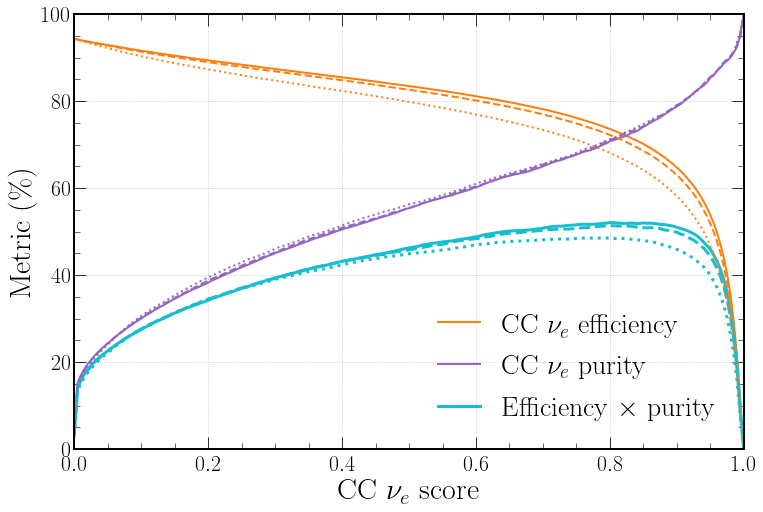

In [5]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_1[0], out_2[0]], 0, save_path+"calib_time_nuel_eff_curves", leg_pos="lower right")

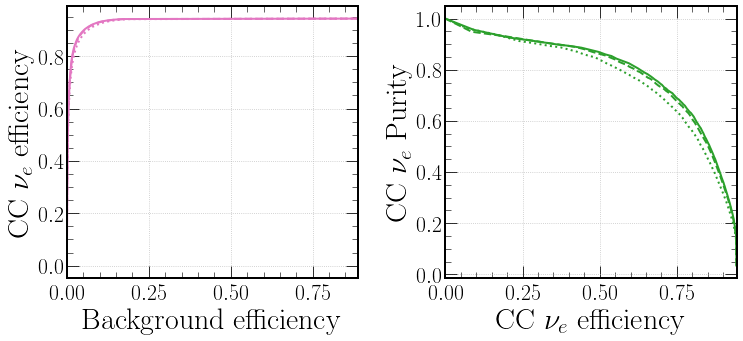

In [6]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_1[0], out_2[0]], 0, save_path+"calib_time_nuel_comp_curves")

In [7]:
# Tidy up
del ev_0, out_0
del ev_1, out_1
del ev_2, out_2

<a id='calib_charge'></a>

## Model calibration sensitivity: charge (calib_charge)

In [20]:
ev_0, out_0 = chipsnet.utils.evaluate(config, "flux_cosmic", ["final_beam", "final_nuel_ccqel_e"], ["t_comb_cat", "energy"])
ev_1, out_1 = chipsnet.utils.evaluate(config, "calib_charge_1", ["final_beam", "final_nuel_ccqel_e"], ["t_comb_cat", "energy"])
ev_2, out_2 = chipsnet.utils.evaluate(config, "calib_charge_2", ["final_beam", "final_nuel_ccqel_e"], ["t_comb_cat", "energy"])
ev_3, out_3 = chipsnet.utils.evaluate(config, "calib_charge_3", ["final_beam", "final_nuel_ccqel_e"], ["t_comb_cat", "energy"])
ev_4, out_4 = chipsnet.utils.evaluate(config, "calib_charge_4", ["final_beam", "final_nuel_ccqel_e"], ["t_comb_cat", "energy"])


************************ Evaluating flux_cosmic ************************
Loading best checkpoint (7)
Loading best checkpoint (16)
Weights: (178619,0.00022), (170335,0.00001), (148811,0.02253), (135788,0.00054), (254434,8.26819)
Cuts:    (396410,0.96036), (227860,0.92954), (78203,0.70037), (52383,0.20588)

------------------------ final_beam report ------------------------
- Comb-> Prec: (0.00000,0.00073), Rec: (0.00111,0.66198), F1: (0.00000,0.00145)
- Cat->  Prec: (0.00000,0.00073), Rec: (0.00111,0.66198), F1: (0.00000,0.00145)

- Nuel-> ROC-AUC: 0.82815, PRC-AUC: 0.75623, S-Eff: 0.83457, S-Pur: 0.55404
- FOM1-> 0.52081, 0.80000, 58.31637, 6.27574, 17.82907, 0.73608, 0.70754
- FOM2-> 16.49479, 0.97000, 34.90599, 0.87207, 3.60616, 0.44059, 0.88629

- Numu-> ROC-AUC: 0.66998, PRC-AUC: 0.92201, S-Eff: 0.89135, S-Pur: 0.98882
- FOM1-> 0.88491, 0.31500, 3.08958, 1847.24793, 34.44892, 0.90290, 0.98008
- FOM2-> 2022.70760, 0.99500, 0.05104, 1547.41989, 0.53422, 0.75635, 0.99962

took 604.29

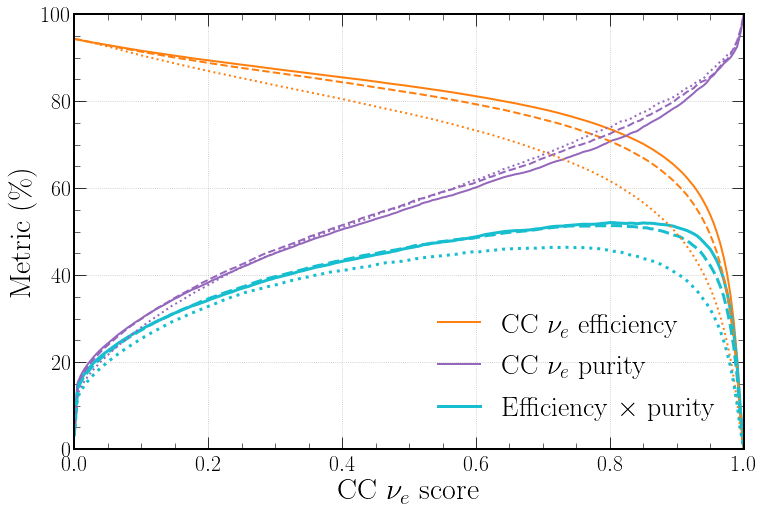

In [21]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_1[0], out_2[0]], 0, save_path+"calib_charge_rand_nuel_eff_curves", leg_pos="lower right")

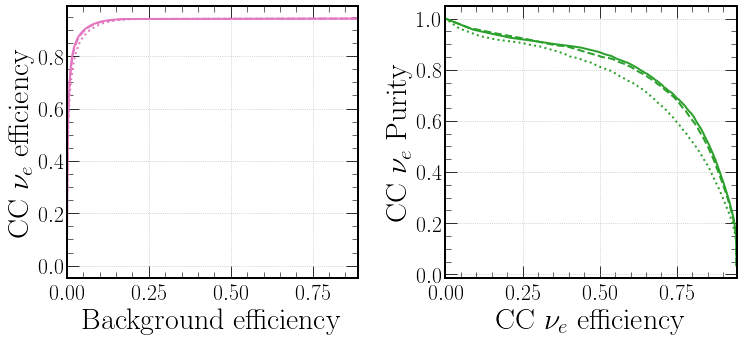

In [22]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_1[0], out_2[0]], 0, save_path+"calib_charge_rand_nuel_comp_curves")

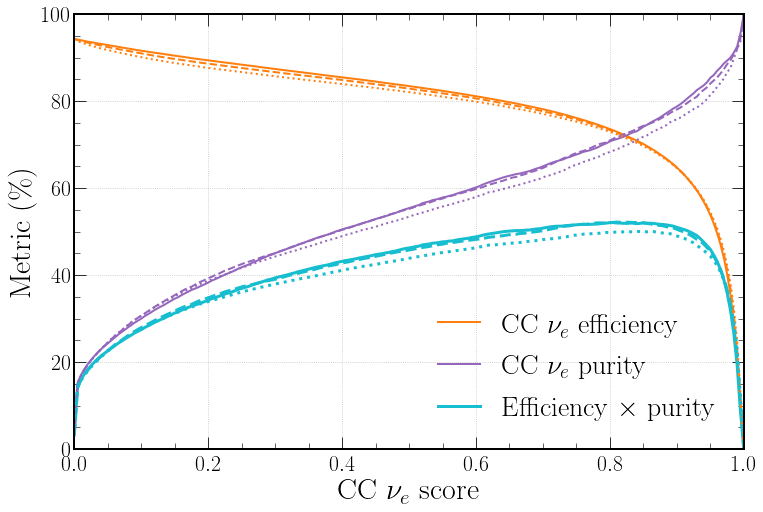

In [23]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_3[0], out_4[0]], 0, save_path+"calib_charge_shift_nuel_eff_curves", leg_pos="lower right")

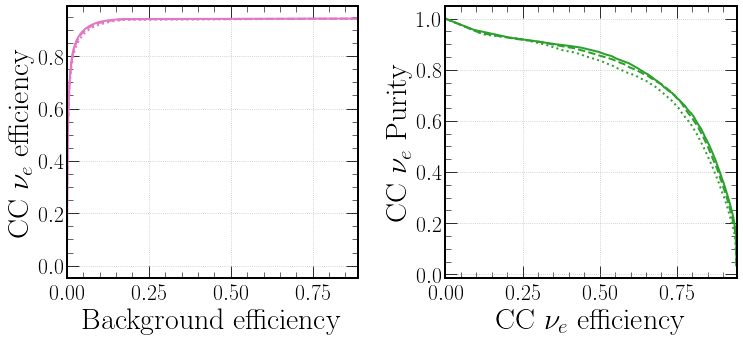

In [24]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_3[0], out_4[0]], 0, save_path+"calib_charge_shift_nuel_comp_curves")

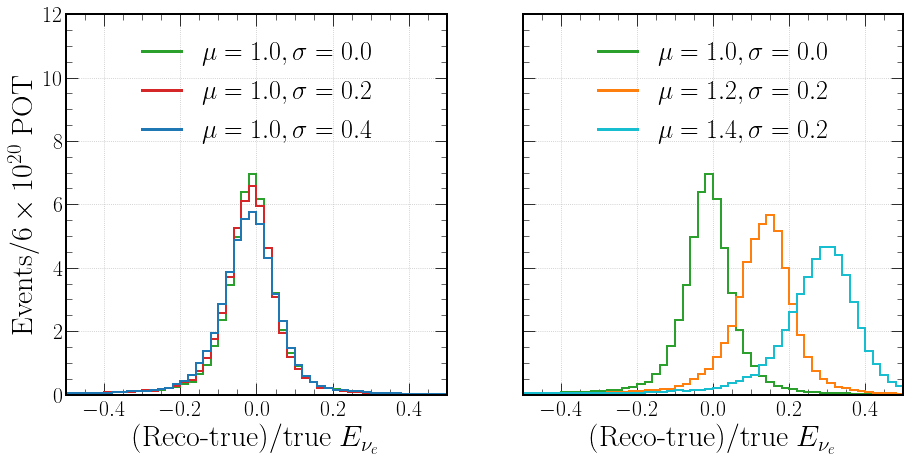

In [25]:
e_range = (-0.5,0.5)
e_bins = 50

fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].hist(
    ev_0[((ev_0["t_all_cat"] == 0) | (ev_0["t_all_cat"] == 4)) & (ev_0["cut"] == 0)]["final_nuel_ccqel_e_frac_nu_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:green",
    linewidth=2,
    weights=ev_0[((ev_0["t_all_cat"] == 0) | (ev_0["t_all_cat"] == 4)) & (ev_0["cut"] == 0)]["w"],
    histtype="step",
    density=True
)
axs[0].hist(
    ev_1[((ev_1["t_all_cat"] == 0) | (ev_1["t_all_cat"] == 4)) & (ev_1["cut"] == 0)]["final_nuel_ccqel_e_frac_nu_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:red",
    linewidth=2,
    weights=ev_1[((ev_1["t_all_cat"] == 0) | (ev_1["t_all_cat"] == 4)) & (ev_1["cut"] == 0)]["w"],
    histtype="step",
    density=True
)
axs[0].hist(
    ev_2[((ev_2["t_all_cat"] == 0) | (ev_2["t_all_cat"] == 4)) & (ev_2["cut"] == 0)]["final_nuel_ccqel_e_frac_nu_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:blue",
    linewidth=2,
    weights=ev_2[((ev_2["t_all_cat"] == 0) | (ev_2["t_all_cat"] == 4)) & (ev_2["cut"] == 0)]["w"],
    histtype="step",
    density=True
)

axs[1].hist(
    ev_0[((ev_0["t_all_cat"] == 0) | (ev_0["t_all_cat"] == 4)) & (ev_0["cut"] == 0)]["final_nuel_ccqel_e_frac_nu_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:green",
    linewidth=2,
    weights=ev_0[((ev_0["t_all_cat"] == 0) | (ev_0["t_all_cat"] == 4)) & (ev_0["cut"] == 0)]["w"],
    histtype="step",
    density=True
)
axs[1].hist(
    ev_3[((ev_3["t_all_cat"] == 0) | (ev_3["t_all_cat"] == 4)) & (ev_3["cut"] == 0)]["final_nuel_ccqel_e_frac_nu_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:orange",
    linewidth=2,
    weights=ev_3[((ev_3["t_all_cat"] == 0) | (ev_3["t_all_cat"] == 4)) & (ev_3["cut"] == 0)]["w"],
    histtype="step",
    density=True
)
axs[1].hist(
    ev_4[((ev_4["t_all_cat"] == 0) | (ev_4["t_all_cat"] == 4)) & (ev_4["cut"] == 0)]["final_nuel_ccqel_e_frac_nu_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:cyan",
    linewidth=2,
    weights=ev_4[((ev_4["t_all_cat"] == 0) | (ev_4["t_all_cat"] == 4)) & (ev_4["cut"] == 0)]["w"],
    histtype="step",
    density=True
)

axs[0].grid()
axs[1].grid()
axs[0].set_xlabel(r"(Reco-true)/true $E_{\nu_{e}}$", fontsize=30)
axs[0].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
axs[1].set_xlabel(r"(Reco-true)/true $E_{\nu_{e}}$", fontsize=30)
axs[1].set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
axs[0].set_ylim(0, 12)
axs[1].set_ylim(0, 12)

e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    ev_0[((ev_0["t_all_cat"] == 0) | (ev_0["t_all_cat"] == 4)) & (ev_0["cut"] == 0)], fit_name="final_nuel_ccqel_e_frac_nu_energy", bin_size=8000
)
leg_0 = Line2D([0], [0], color="tab:green", linewidth=3, label=r"$\mu=1.0, \sigma=0.0$")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    ev_1[((ev_1["t_all_cat"] == 0) | (ev_1["t_all_cat"] == 4)) & (ev_1["cut"] == 0)], fit_name="final_nuel_ccqel_e_frac_nu_energy", bin_size=8000
)
leg_1 = Line2D([0], [0], color="tab:red", linewidth=3, label=r"$\mu=1.0, \sigma=0.2$")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    ev_2[((ev_2["t_all_cat"] == 0) | (ev_2["t_all_cat"] == 4)) & (ev_2["cut"] == 0)], fit_name="final_nuel_ccqel_e_frac_nu_energy", bin_size=8000
)
leg_2 = Line2D([0], [0], color="tab:blue", linewidth=3, label=r"$\mu=1.0, \sigma=0.4$")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    ev_3[((ev_3["t_all_cat"] == 0) | (ev_3["t_all_cat"] == 4)) & (ev_3["cut"] == 0)], fit_name="final_nuel_ccqel_e_frac_nu_energy", bin_size=8000
)
leg_3 = Line2D([0], [0], color="tab:orange", linewidth=3, label=r"$\mu=1.2, \sigma=0.2$")
e_list, means, stds = chipsnet.utils.frac_e_vs_par(
    ev_4[((ev_4["t_all_cat"] == 0) | (ev_4["t_all_cat"] == 4)) & (ev_4["cut"] == 0)], fit_name="final_nuel_ccqel_e_frac_nu_energy", bin_size=8000
)
leg_4 = Line2D([0], [0], color="tab:cyan", linewidth=3, label=r"$\mu=1.4, \sigma=0.2$")

axs[0].legend(handles=[leg_0, leg_1, leg_2], loc="upper center", fontsize=26)
axs[1].legend(handles=[leg_0, leg_3, leg_4], loc="upper center", fontsize=26)
axs[1].label_outer()

chipsnet.plotting.save(save_path + "calib_charge_energy")

In [26]:
# Tidy up
del ev_0, out_0
del ev_1, out_1
del ev_2, out_2
del ev_3, out_3
del ev_4, out_4

<a id='calib_noise'></a>

## Model calibration sensitivity: noise (calib_noise)

In [15]:
ev_0, out_0 = chipsnet.utils.evaluate(config, "flux_cosmic", ["final_beam", "final_nuel_ccqel_e"], ["t_comb_cat", "energy"])
ev_1, out_1 = chipsnet.utils.evaluate(config, "calib_noise_1", ["final_beam", "final_nuel_ccqel_e"], ["t_comb_cat", "energy"])
ev_2, out_2 = chipsnet.utils.evaluate(config, "calib_noise_2", ["final_beam", "final_nuel_ccqel_e"], ["t_comb_cat", "energy"])


************************ Evaluating flux_cosmic ************************
Loading best checkpoint (7)
Loading best checkpoint (16)
Weights: (178619,0.00022), (170335,0.00001), (148811,0.02253), (135788,0.00054), (254434,8.26819)
Cuts:    (396410,0.96036), (227860,0.92954), (78203,0.70037), (52383,0.20588)

------------------------ final_beam report ------------------------
- Comb-> Prec: (0.00000,0.00073), Rec: (0.00111,0.66198), F1: (0.00000,0.00145)
- Cat->  Prec: (0.00000,0.00073), Rec: (0.00111,0.66198), F1: (0.00000,0.00145)

- Nuel-> ROC-AUC: 0.82815, PRC-AUC: 0.75623, S-Eff: 0.83457, S-Pur: 0.55404
- FOM1-> 0.52081, 0.80000, 58.31637, 6.27574, 17.82907, 0.73608, 0.70754
- FOM2-> 16.49479, 0.97000, 34.90599, 0.87207, 3.60616, 0.44059, 0.88629

- Numu-> ROC-AUC: 0.66998, PRC-AUC: 0.92201, S-Eff: 0.89135, S-Pur: 0.98882
- FOM1-> 0.88491, 0.31500, 3.08958, 1847.24793, 34.44892, 0.90290, 0.98008
- FOM2-> 2022.70760, 0.99500, 0.05104, 1547.41989, 0.53422, 0.75635, 0.99962

took 608.45

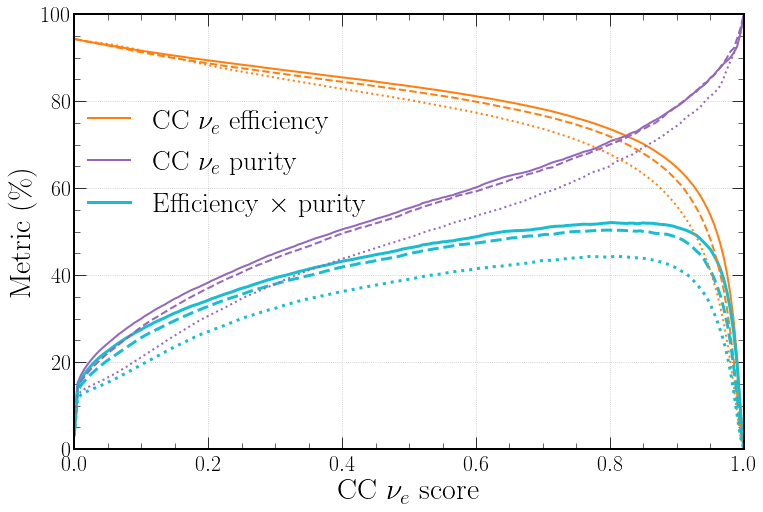

In [16]:
chipsnet.plotting.plot_eff_curves([out_0[0], out_1[0], out_2[0]], 0, save_path+"calib_noise_nuel_eff_curves", leg_pos=(0.0, 0.5))

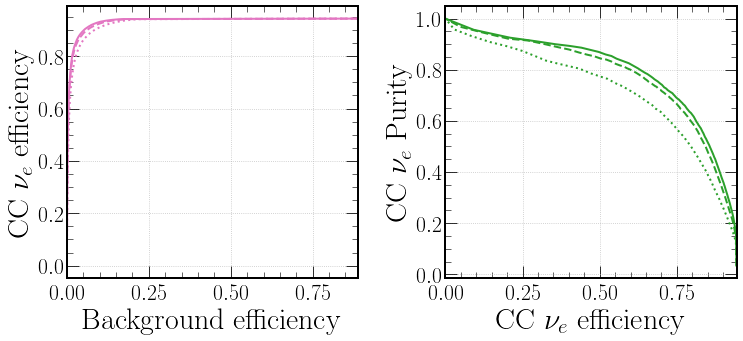

In [17]:
chipsnet.plotting.plot_comp_curves([out_0[0], out_1[0], out_2[0]], 0, save_path+"calib_noise_nuel_comp_curves")

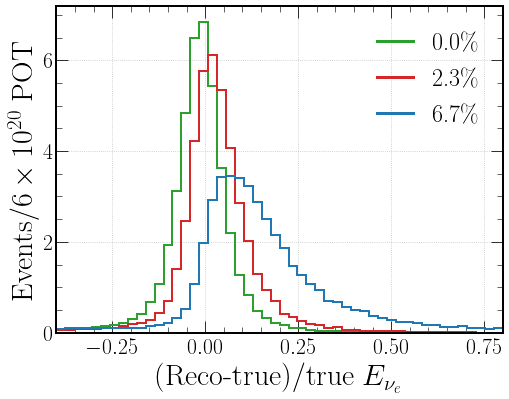

In [18]:
e_range = (-0.4,0.8)
e_bins = 50

fig, axs = plt.subplots(1, 1, figsize=(8, 6), gridspec_kw={"hspace": 0.2, "wspace": 0.3})
axs.hist(
    ev_0[((ev_0["t_all_cat"] == 0) | (ev_0["t_all_cat"] == 4)) & (ev_0["cut"] == 0)]["final_nuel_ccqel_e_frac_nu_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:green",
    linewidth=2,
    weights=ev_0[((ev_0["t_all_cat"] == 0) | (ev_0["t_all_cat"] == 4)) & (ev_0["cut"] == 0)]["w"],
    histtype="step",
    density=True
)
axs.hist(
    ev_1[((ev_1["t_all_cat"] == 0) | (ev_1["t_all_cat"] == 4)) & (ev_1["cut"] == 0)]["final_nuel_ccqel_e_frac_nu_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:red",
    linewidth=2,
    weights=ev_1[((ev_1["t_all_cat"] == 0) | (ev_1["t_all_cat"] == 4)) & (ev_1["cut"] == 0)]["w"],
    histtype="step",
    density=True
)
axs.hist(
    ev_2[((ev_2["t_all_cat"] == 0) | (ev_2["t_all_cat"] == 4)) & (ev_2["cut"] == 0)]["final_nuel_ccqel_e_frac_nu_energy"],
    range=e_range,
    bins=e_bins,
    color="tab:blue",
    linewidth=2,
    weights=ev_2[((ev_2["t_all_cat"] == 0) | (ev_2["t_all_cat"] == 4)) & (ev_2["cut"] == 0)]["w"],
    histtype="step",
    density=True
)

axs.grid()
axs.set_xlabel(r"(Reco-true)/true $E_{\nu_{e}}$", fontsize=30)
axs.set_ylabel(r"Events/$6\times10^{20}$ POT", fontsize=30)
qel = Line2D([0], [0], color="tab:green", linewidth=3, label=r"0.0\%")
res = Line2D([0], [0], color="tab:red", linewidth=3, label=r"2.3\%")
dis = Line2D([0], [0], color="tab:blue", linewidth=3, label=r"6.7\%")
axs.legend(handles=[qel, res, dis], loc="upper right", fontsize=24)

chipsnet.plotting.save(save_path + "calib_noise_energy")

In [19]:
# Tidy up
del ev_0, out_0
del ev_1, out_1
del ev_2, out_2

<a id='cosmic_cluster'></a>

## Clustering: cosmic classification

In [15]:
u_ev, u_out = chipsnet.utils.evaluate(config, "sample_uniform_cosmic", ["final_cosmic"], ["t_cosmic_cat"], exclude_images=False)
cosmic_events = u_ev[u_ev["t_cosmic_cat"] == 1][:5000]
beam_events = u_ev[u_ev["t_cosmic_cat"] == 0][:5000]
events = pd.concat([cosmic_events, beam_events]).sample(frac=1).reset_index(drop=True)


************************ Evaluating sample_uniform_cosmic ************************
Loading best checkpoint (6)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Weights: (0,0.00000), (0,0.00000), (28919,0.11595), (0,0.00000), (16821,71.97538)
count    16821.000000
mean         0.999264
std          0.015626
min          0.060418
25%          0.999993
50%          1.000000
75%          1.000000
max          1.000000
Name: final_cosmic_pred_t_cosmic_cat, dtype: float64
count    24067.000000
mean         0.943565
std          0.131641
min          0.000060
25%          0.955152
50%          0.993436
75%          0.999296
max          1.000000
Name: final_cosmic_pred_t_escapes, dtype: float64
Cuts:    (13847,0.94849), (8817,0.41328), (8651,0.76925), (0,0.00000)
took 44.75 seconds


In [16]:
pca_model = chipsnet.utils.model_from_conf(config, "final_cosmic")
events = chipsnet.utils.run_pca(events, pca_model, verbose=True, components=2, standardise=True)
cat_0_ev = events[events["t_cosmic_cat"] == 0]
cat_1_ev = events[events["t_cosmic_cat"] == 1]

Loading best checkpoint (6)
Explained variation per principal component: [0.40846747 0.22871462]


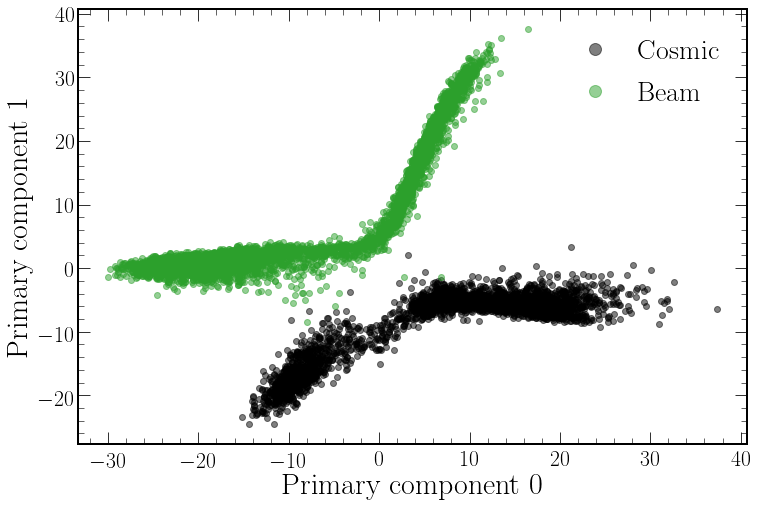

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_1_ev.pca0, cat_1_ev.pca1, marker='.', linestyle='', ms=12, label="Cosmic", alpha=0.5, color="black")
axs.plot(cat_0_ev.pca0, cat_0_ev.pca1, marker='.', linestyle='', ms=12, label="Beam", alpha=0.5, color="tab:green")
axs.legend(fontsize=28, markerscale=2.0)
axs.set_xlabel('Primary component 0', fontsize=30)
axs.set_ylabel('Primary component 1', fontsize=30)
chipsnet.plotting.save(save_path + "explain_cosmic_pca")

In [20]:
tsne_model = chipsnet.utils.model_from_conf(config, "final_cosmic")
events = chipsnet.utils.run_tsne(events, tsne_model, components=2, standardise=True, max_events=10000)
cat_0_ev = events[events["t_cosmic_cat"] == 0]
cat_1_ev = events[events["t_cosmic_cat"] == 1]

Loading best checkpoint (6)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 1.112s...
[t-SNE] Computed neighbors for 10000 samples in 132.097s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.267781
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.362640
[t-SNE] KL divergence after 300 iterations: 2.48

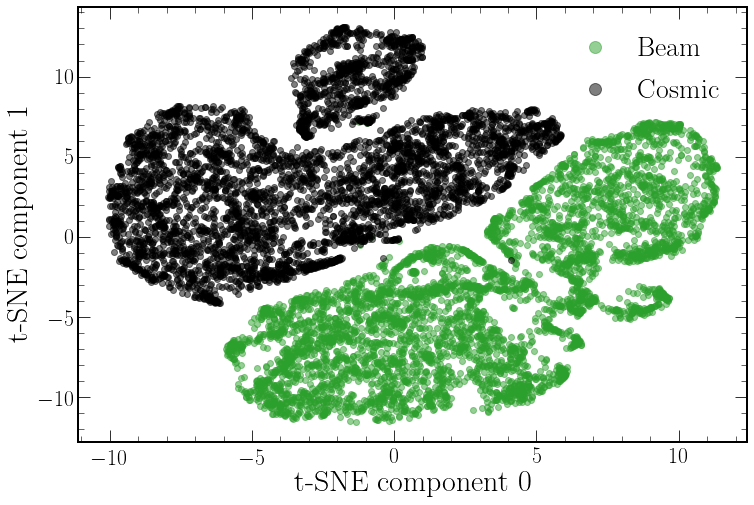

In [21]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.tsne0, cat_0_ev.tsne1, marker='.', linestyle='', ms=12, label="Beam", alpha=0.5, color="tab:green")
axs.plot(cat_1_ev.tsne0, cat_1_ev.tsne1, marker='.', linestyle='', ms=12, label="Cosmic", alpha=0.5, color="black")
axs.legend(fontsize=28, markerscale=2.0)
axs.set_xlabel('t-SNE component 0', fontsize=30)
axs.set_ylabel('t-SNE component 1', fontsize=30)
chipsnet.plotting.save(save_path + "explain_cosmic_tsne")

In [22]:
# Tidy up
del u_ev, u_out, events, cat_0_ev, cat_1_ev

<a id='beam_cluster'></a>

## Clustering: beam classification

In [4]:
u_ev, u_out = chipsnet.utils.evaluate(config, "sample_uniform", ["final_beam"], ["t_comb_cat"], exclude_images=False)
nuel_event = u_ev[u_ev["t_comb_cat"] == 0][:4000]
numu_events = u_ev[u_ev["t_comb_cat"] == 1][:4000]
nc_events = u_ev[u_ev["t_comb_cat"] == 2][:4000]
events = pd.concat([nuel_event, numu_events, nc_events]).sample(frac=1).reset_index(drop=True)


************************ Evaluating sample_uniform ************************
Loading best checkpoint (7)


/mnt/storage/jtingey/chips-net/.conda/envs/chipsnet/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:540: UserWarning: Input dict contained keys ['r_total_digi_q', 'r_first_ring_height', 'r_vtx_t'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


Weights: (0,0.00000), (0,0.00000), (15199,0.22062), (0,0.00000), (0,0.00000)
Cuts:    (9266,0.96975), (13185,0.92325), (6023,0.73775), (0,0.00000)

------------------------ final_beam report ------------------------
- Comb-> Prec: (0.96513,0.67744), Rec: (0.94541,0.91257), F1: (0.95222,0.75250)
- Cat->  Prec: (0.96513,0.67744), Rec: (0.94541,0.91257), F1: (0.95222,0.75250)

- Nuel-> ROC-AUC: 0.86578, PRC-AUC: 0.68202, S-Eff: 0.87845, S-Pur: 0.42665
- FOM1-> 0.46618, 0.82500, 24.51869, 11.75064, 3.43811, 0.75498, 0.61748
- FOM2-> 8.01282, 0.97000, 14.08254, 2.51647, 0.57234, 0.43363, 0.82012

- Numu-> ROC-AUC: 0.56042, PRC-AUC: 0.93080, S-Eff: 0.88375, S-Pur: 0.99704
- FOM1-> 0.91234, 0.03500, 2.32395, 1978.26258, 25.48833, 0.92517, 0.98614
- FOM2-> 11176.79395, 0.99500, 0.00578, 1569.70517, 0.01394, 0.73410, 0.99999

took 47.63 seconds


In [5]:
pca_model = chipsnet.utils.model_from_conf(config, "final_beam")
events = chipsnet.utils.run_pca(events, pca_model, verbose=True, components=2, standardise=True)
cat_0_ev = events[events["t_comb_cat"] == 0]
cat_1_ev = events[events["t_comb_cat"] == 1]
cat_2_ev = events[events["t_comb_cat"] == 2]

Loading best checkpoint (7)
Explained variation per principal component: [0.15199197 0.11340615]


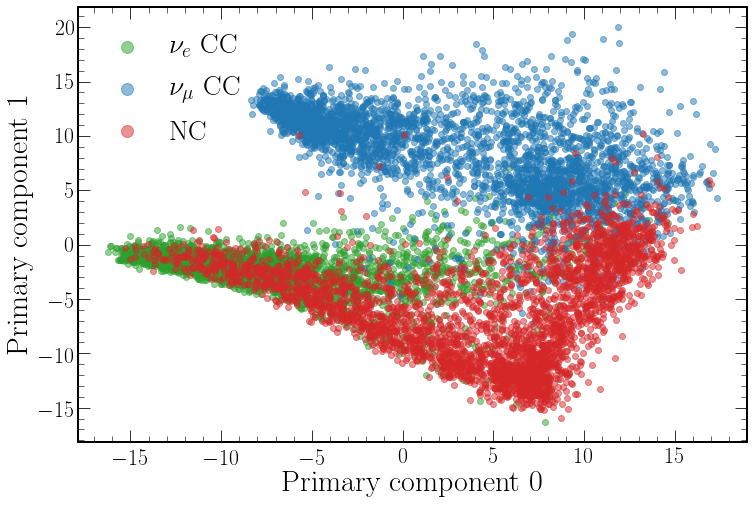

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.pca0, cat_0_ev.pca1, marker='.', linestyle='', ms=12, label=r"$\nu_{e}$ CC", alpha=0.5, color="tab:green")
axs.plot(cat_1_ev.pca0, cat_1_ev.pca1, marker='.', linestyle='', ms=12, label=r"$\nu_{\mu}$ CC", alpha=0.5, color="tab:blue")
axs.plot(cat_2_ev.pca0, cat_2_ev.pca1, marker='.', linestyle='', ms=12, label=r"NC", alpha=0.5, color="tab:red")
axs.legend(fontsize=28, markerscale=2.0)
axs.set_xlabel('Primary component 0', fontsize=30)
axs.set_ylabel('Primary component 1', fontsize=30)
chipsnet.plotting.save(save_path + "explain_beam_pca")

In [7]:
tsne_model = chipsnet.utils.model_from_conf(config, "final_beam")
events = chipsnet.utils.run_tsne(events, tsne_model, components=2, standardise=True, max_events=12000)
cat_0_ev = events[events.t_comb_cat == 0]
cat_1_ev = events[events.t_comb_cat == 1]
cat_2_ev = events[events.t_comb_cat == 2]

Loading best checkpoint (7)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12000 samples in 1.610s...
[t-SNE] Computed neighbors for 12000 samples in 185.150s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma:

In [8]:
nuel_index = events["final_beam_pred_t_comb_cat_0"].idxmax()
numu_index = events["final_beam_pred_t_comb_cat_1"].idxmax()
nc_index = events["final_beam_pred_t_comb_cat_2"].idxmax()
print("Nuel: ({:.3f},{:.3f}), Numu: ({:.3f},{:.3f}), NC: ({:.3f},{:.3f})".format(
    events["tsne0"][nuel_index],
    events["tsne1"][nuel_index],
    events["tsne0"][numu_index],
    events["tsne1"][numu_index],
    events["tsne0"][nc_index],
    events["tsne1"][nc_index],
))
markers_0 = [events["tsne0"][nuel_index], events["tsne0"][numu_index], events["tsne0"][nc_index]]
markers_1 = [events["tsne1"][nuel_index], events["tsne1"][numu_index], events["tsne1"][nc_index]]

Nuel: (1.754,6.217), Numu: (-1.270,9.106), NC: (-3.082,-7.118)


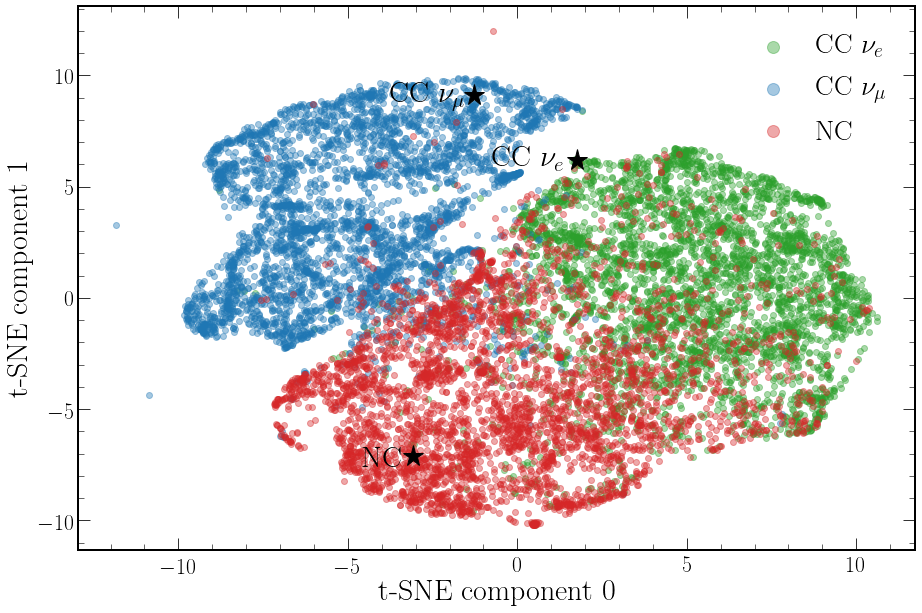

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(15, 10))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.tsne0, cat_0_ev.tsne1, marker='.', linestyle='', ms=12, label=r"CC $\nu_{e}$", alpha=0.4, color="tab:green")
axs.plot(cat_1_ev.tsne0, cat_1_ev.tsne1, marker='.', linestyle='', ms=12, label=r"CC $\nu_{\mu}$", alpha=0.4, color="tab:blue")
axs.plot(cat_2_ev.tsne0, cat_2_ev.tsne1, marker='.', linestyle='', ms=12, label=r"NC", alpha=0.4, color="tab:red")
axs.plot(markers_0, markers_1, marker='*', linestyle='', ms=22, color="black")
axs.text(markers_0[0]-2.5, markers_1[0]-0.5, r"CC $\nu_{e}$", fontsize=30, weight="bold")
axs.text(markers_0[1]-2.5, markers_1[1]-0.5, r"CC $\nu_{\mu}$", fontsize=30, weight="bold")
axs.text(markers_0[2]-1.5, markers_1[2]-0.5, r"NC", fontsize=30, weight="bold")
axs.legend(fontsize=28, markerscale=2.0)
axs.set_xlabel('t-SNE component 0', fontsize=30)
axs.set_ylabel('t-SNE component 1', fontsize=30)
chipsnet.plotting.save(save_path + "explain_beam_tsne")

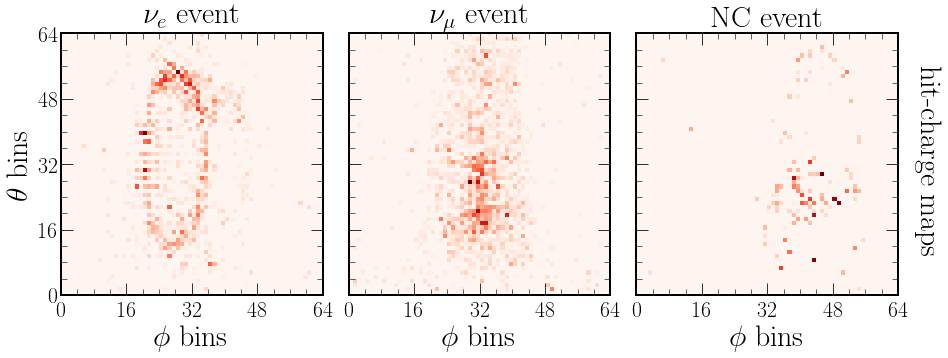

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={"hspace": 0.3, "wspace": 0.1})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
extent = (0, 64, 0, 64)
axs[0].imshow(events["image_0"][nuel_index][:, :, 0], cmap="Reds", origin="lower", extent=extent)
axs[0].set_title(r"$\nu_{e}$ event", fontsize=30)
axs[0].set_xlabel(r"$\phi$ bins", fontsize=30)
axs[0].set_ylabel(r"$\theta$ bins", fontsize=30)
axs[0].label_outer()
axs[1].imshow(events["image_0"][numu_index][:, :, 0], cmap="Reds", origin="lower", extent=extent)
axs[1].set_title(r"$\nu_{\mu}$ event", fontsize=30)
axs[1].set_xlabel(r"$\phi$ bins", fontsize=30)
axs[1].set_ylabel(r"$\theta$ bins", fontsize=30)
axs[1].label_outer()
axs[2].imshow(events["image_0"][nc_index][:, :, 0], cmap="Reds", origin="lower", extent=extent)
axs[2].set_title(r"NC event", fontsize=30)
axs[2].set_xlabel(r"$\phi$ bins", fontsize=30)
axs[2].set_ylabel(r"$\theta$ bins", fontsize=30)
axs[2].label_outer()
axs[2].text(68, 11, "hit-charge maps", rotation=-90, fontsize=30)
chipsnet.plotting.save(save_path + "explain_beam_tsne_events")

In [12]:
# Tidy up
del u_ev, u_out, events, cat_0_ev, cat_1_ev, cat_2_ev

<a id='explain'></a>

## Explanation: cosmic/beam/energy (explain)

In [13]:
num_events = 10
events, outputs = chipsnet.utils.evaluate(config, "stacked_noreco", exclude_images=False)
cosmic_model = chipsnet.utils.model_from_conf(config, "explain_cosmic")
beam_model = chipsnet.utils.model_from_conf(config, "explain_beam")
energy_model = chipsnet.utils.model_from_conf(config, "explain_energy")


************************ Evaluating stacked_noreco ************************
Weights: (2182,0.01782), (0,0.00000), (6809,0.49247), (0,0.00000), (10731,196.04020)
Cuts:    (11806,0.94835), (5333,0.90991), (1954,0.66036), (2178,0.20296)
took 12.88 seconds
Loading best checkpoint (9)
Loading best checkpoint (10)
Loading best checkpoint (5)


In [14]:
# Explain cosmic model
cosmic_activ_1 = chipsnet.utils.explain_activation(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block0_path0_conv1")
cosmic_activ_2 = chipsnet.utils.explain_activation(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block1_path0_conv1")
cosmic_activ_3 = chipsnet.utils.explain_activation(events, cosmic_model, num_events, output="t_cosmic_cat", layer_name="block2_conv1")

# Explain beam model
beam_activ_1 = chipsnet.utils.explain_activation(events, beam_model, num_events, output="t_all_cat", layer_name="block0_path0_conv1")
beam_activ_2 = chipsnet.utils.explain_activation(events, beam_model, num_events, output="t_all_cat", layer_name="block1_path0_conv1")
beam_activ_3 = chipsnet.utils.explain_activation(events, beam_model, num_events, output="t_all_cat", layer_name="block2_conv1")

# Explain energy model
energy_activ_1 = chipsnet.utils.explain_activation(events, energy_model, num_events, output="t_nu_energy", layer_name="block0_path0_conv1")
energy_activ_2 = chipsnet.utils.explain_activation(events, energy_model, num_events, output="t_nu_energy", layer_name="block1_path0_conv1")
energy_activ_3 = chipsnet.utils.explain_activation(events, energy_model, num_events, output="t_nu_energy", layer_name="block2_conv1")

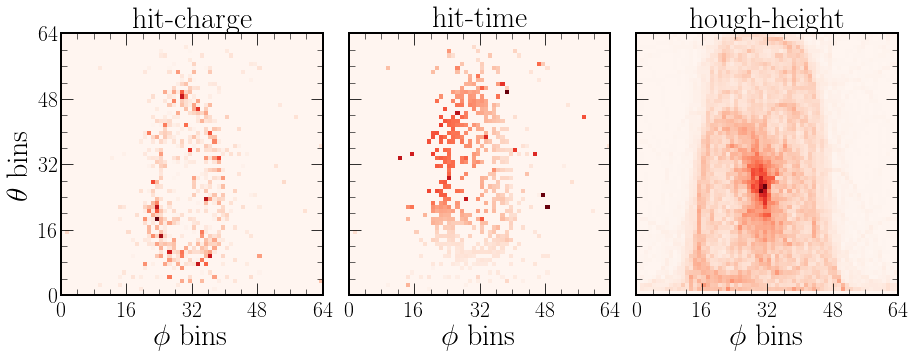

In [15]:
test_event = 5
fig, axs = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={"hspace": 0.3, "wspace": 0.1})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
extent = (0, 64, 0, 64)
axs[0].imshow(events["image_0"][test_event][:, :, 0], cmap="Reds", origin="lower", extent=extent)
axs[0].set_title(r"hit-charge", fontsize=30)
axs[0].set_xlabel(r"$\phi$ bins", fontsize=30)
axs[0].set_ylabel(r"$\theta$ bins", fontsize=30)
axs[0].label_outer()
axs[1].imshow(events["image_0"][test_event][:, :, 1], cmap="Reds", origin="lower", extent=extent)
axs[1].set_title(r"hit-time", fontsize=30)
axs[1].set_xlabel(r"$\phi$ bins", fontsize=30)
axs[1].set_ylabel(r"$\theta$ bins", fontsize=30)
axs[1].label_outer()
axs[2].imshow(events["image_0"][test_event][:, :, 2], cmap="Reds", origin="lower", extent=extent)
axs[2].set_title(r"hough-height", fontsize=30)
axs[2].set_xlabel(r"$\phi$ bins", fontsize=30)
axs[2].set_ylabel(r"$\theta$ bins", fontsize=30)
axs[2].label_outer()
chipsnet.plotting.save(save_path + "explain_example_event")

In [13]:
print(events["t_all_cat"][test_event])
print(events["t_nu_energy"][test_event])
print(events["t_lep_energy"][test_event])

1.0
2420.7099609375
1582.9100341796875


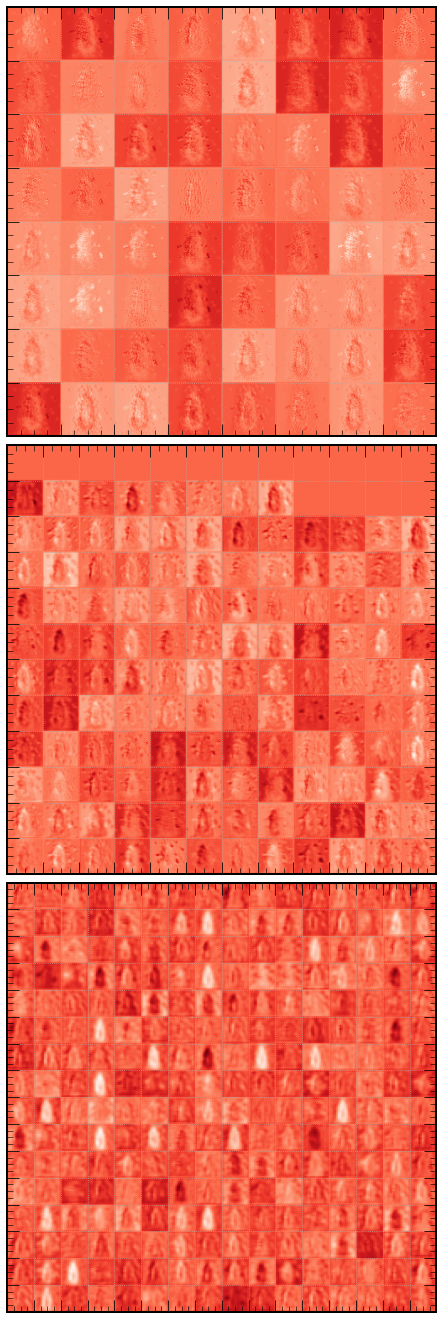

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(8, 24), gridspec_kw={"hspace": 0.02, "wspace": 0.3})
plt.rc('grid', linestyle="-", color='black')
axs[0].set_xticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_yticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_xticklabels('')
axs[0].set_yticklabels('')
axs[0].imshow(cosmic_activ_1[test_event], cmap='Reds', origin='lower', extent=(0, 256, 256, 0))
axs[0].grid()
axs[1].set_xticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_yticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')
axs[1].imshow(cosmic_activ_2[test_event], cmap='Reds', origin='lower', extent=(0, 192, 192, 0))
axs[1].grid()
axs[2].set_xticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_yticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_xticklabels('')
axs[2].set_yticklabels('')
axs[2].imshow(cosmic_activ_3[test_event], cmap='Reds', origin='lower', extent=(0, 128, 128, 0))
axs[2].grid()
chipsnet.plotting.save(save_path + "explain_cosmic_activations")

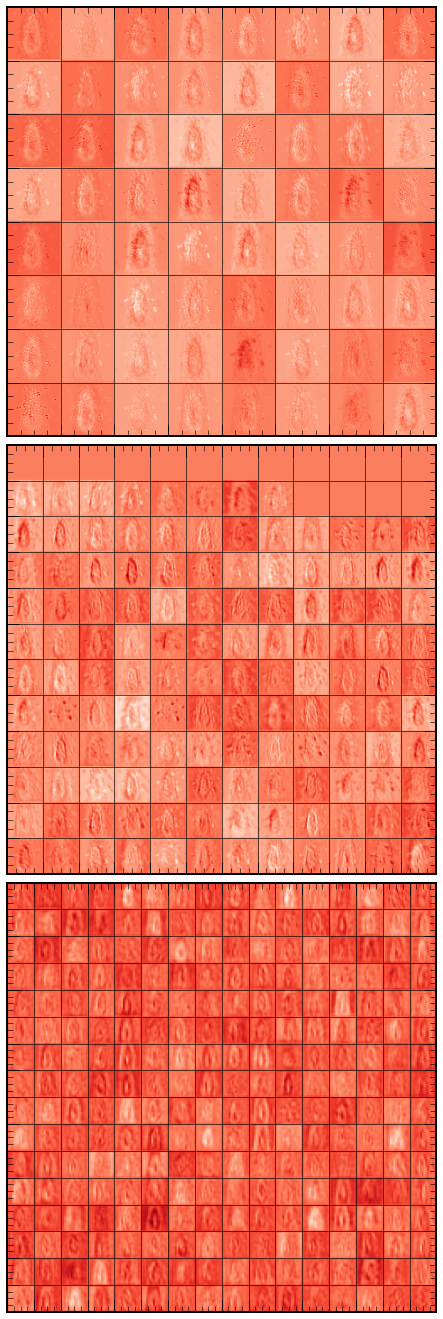

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(8, 24), gridspec_kw={"hspace": 0.02, "wspace": 0.3})
plt.rc('grid', linestyle="-", color='black')
axs[0].set_xticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_yticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_xticklabels('')
axs[0].set_yticklabels('')
axs[0].imshow(beam_activ_1[test_event], cmap='Reds', origin='lower', extent=(0, 256, 256, 0))
axs[0].grid()
axs[1].set_xticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_yticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')
axs[1].imshow(beam_activ_2[test_event], cmap='Reds', origin='lower', extent=(0, 192, 192, 0))
axs[1].grid()
axs[2].set_xticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_yticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_xticklabels('')
axs[2].set_yticklabels('')
axs[2].imshow(beam_activ_3[test_event], cmap='Reds', origin='lower', extent=(0, 128, 128, 0))
axs[2].grid()
chipsnet.plotting.save(save_path + "explain_beam_activations")

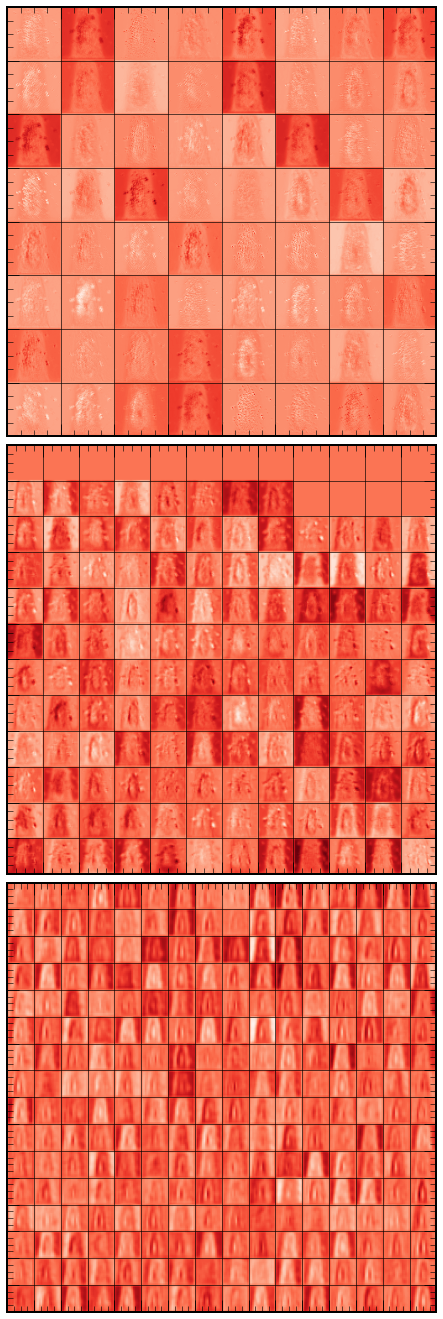

In [9]:
fig, axs = plt.subplots(3, 1, figsize=(8, 24), gridspec_kw={"hspace": 0.02, "wspace": 0.3})
plt.rc('grid', linestyle="-", color='black')
axs[0].set_xticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_yticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_xticklabels('')
axs[0].set_yticklabels('')
axs[0].imshow(energy_activ_1[test_event], cmap='Reds', origin='lower', extent=(0, 256, 256, 0))
axs[0].grid()
axs[1].set_xticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_yticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')
axs[1].imshow(energy_activ_2[test_event], cmap='Reds', origin='lower', extent=(0, 192, 192, 0))
axs[1].grid()
axs[2].set_xticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_yticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_xticklabels('')
axs[2].set_yticklabels('')
axs[2].imshow(energy_activ_3[test_event], cmap='Reds', origin='lower', extent=(0, 128, 128, 0))
axs[2].grid()
chipsnet.plotting.save(save_path + "explain_energy_activations")

In [14]:
# Tidy up
del events, outputs, cosmic_model, beam_model, energy_model
del cosmic_activ_1, cosmic_activ_2, cosmic_activ_3
del beam_activ_1, beam_activ_2, beam_activ_3
del energy_activ_1, energy_activ_2, energy_activ_3